# Openclassrooms PJ4 : transats dataset : modelisation notebook

# Global variables and functions used in the notebook

In [1]:
%matplotlib inline

import os
import zipfile
import urllib

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import qgrid

import glob

from pandas.plotting import scatter_matrix

from sklearn.model_selection import StratifiedShuffleSplit

SAMPLED_DATA = True  # If True : data is sampled (NB_SAMPLES instances only) for faster testing purposes
NB_SAMPLES = 800000
#NB_SAMPLES = 2000000
LEARNING_CURVE_STEP_SIZE = 50000 # Change that when you change NB_SAMPLES size

DATA_PATH = os.path.join("datasets", "transats")
DATA_PATH = os.path.join(DATA_PATH, "out")

DATA_PATH_FILE_INPUT = os.path.join(DATA_PATH, "transats_metadata_transformed.csv")


ALL_FEATURES = ['ORIGIN','CRS_DEP_TIME','MONTH','DAY_OF_MONTH','DAY_OF_WEEK','UNIQUE_CARRIER','DEST','CRS_ARR_TIME','DISTANCE','CRS_ELAPSED_TIME','ARR_DELAY','DEP_DELAY', 'TAXI_OUT', 'TAIL_NUM', 'NBFLIGHTS_FORDAYHOUR_FORAIRPORT', 'NBFLIGHTS_FORDAY_FORAIRPORT']

'''
MODEL1_FEATURES = ['ORIGIN','CRS_DEP_TIME','MONTH','DAY_OF_MONTH','DAY_OF_WEEK','UNIQUE_CARRIER','DEST','CRS_ARR_TIME','DISTANCE','CRS_ELAPSED_TIME']
MODEL1_LABEL = 'ARR_DELAY'
'''

MODEL1_FEATURES = ['ORIGIN','CRS_DEP_TIME','MONTH','DAY_OF_MONTH','DAY_OF_WEEK','UNIQUE_CARRIER','DEST','CRS_ARR_TIME','DISTANCE','CRS_ELAPSED_TIME', 'NBFLIGHTS_FORDAYHOUR_FORAIRPORT', 'NBFLIGHTS_FORDAY_FORAIRPORT']
MODEL1_FEATURES_QUANTITATIVE = ['CRS_DEP_TIME','MONTH','DAY_OF_MONTH','DAY_OF_WEEK','CRS_ARR_TIME','DISTANCE','CRS_ELAPSED_TIME', 'NBFLIGHTS_FORDAYHOUR_FORAIRPORT', 'NBFLIGHTS_FORDAY_FORAIRPORT']

MODEL1_GOUPBYMEAN_FEATURES = ['CRS_DEP_TIME','MONTH','DAY_OF_MONTH','DEST','DISTANCE','CRS_ELAPSED_TIME', 'NBFLIGHTS_FORDAYHOUR_FORAIRPORT', 'CRS_ARR_TIME', 'DAY_OF_WEEK', 'NBFLIGHTS_FORDAY_FORAIRPORT', 'ORIGIN', 'UNIQUE_CARRIER']
MODEL_GROUPBYMEAN_FEATURES_QUANTITATIVE = ['CRS_DEP_TIME','MONTH','DAY_OF_MONTH','DISTANCE','CRS_ELAPSED_TIME', 'DEST', 'CRS_ARR_TIME', 'DAY_OF_WEEK', 'NBFLIGHTS_FORDAYHOUR_FORAIRPORT', 'ORIGIN', 'UNIQUE_CARRIER' ]


MODEL1bis_FEATURES_QUANTITATIVE = ['CRS_DEP_TIME','CRS_ARR_TIME','DISTANCE','CRS_ELAPSED_TIME', 'NBFLIGHTS_FORDAYHOUR_FORAIRPORT', 'NBFLIGHTS_FORDAY_FORAIRPORT']
MODEL1_LABEL = 'ARR_DELAY'

MODEL_1HOTALL_FEATURES = ['DISTANCE', 'CRS_ELAPSED_TIME', 'NBFLIGHTS_FORDAY_FORAIRPORT', 'NBFLIGHTS_FORDAYHOUR_FORAIRPORT', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'ORIGIN', 'UNIQUE_CARRIER', 'CRS_DEP_TIME']
MODEL_1HOTALL_FEATURES_QUANTITATIVE = ['DISTANCE', 'CRS_ELAPSED_TIME', 'NBFLIGHTS_FORDAY_FORAIRPORT', 'NBFLIGHTS_FORDAYHOUR_FORAIRPORT']
# For later : maybe not include CRS_ELAPSED_TIME because close to DISTANCE

MODEL1_2FEATS = ['DISTANCE', 'NBFLIGHTS_FORDAYHOUR_FORAIRPORT', 'DEP_DELAY']
MODEL1_2FEATS_QUANTITATIVE = ['DISTANCE', 'NBFLIGHTS_FORDAYHOUR_FORAIRPORT', 'DEP_DELAY']


MODEL_cheat_FEATURES = ['ARR_DELAY','ORIGIN','CRS_DEP_TIME','MONTH','DAY_OF_MONTH','DAY_OF_WEEK','UNIQUE_CARRIER','DEST','CRS_ARR_TIME','DISTANCE','CRS_ELAPSED_TIME', 'NBFLIGHTS_FORDAYHOUR_FORAIRPORT', 'NBFLIGHTS_FORDAY_FORAIRPORT']
MODEL_cheat_FEATURES_QUANTITATIVE = ['ARR_DELAY','CRS_DEP_TIME','CRS_ARR_TIME','DISTANCE','CRS_ELAPSED_TIME', 'NBFLIGHTS_FORDAYHOUR_FORAIRPORT', 'NBFLIGHTS_FORDAY_FORAIRPORT']

plt.rcParams["figure.figsize"] = [16,9] # Taille par défaut des figures de matplotlib

import seaborn as sns
sns.set()

#import common_functions

####### Paramètres pour sauver et restaurer les modèles :
import pickle
####### Paramètres à changer par l'utilisateur selon son besoin :
RECOMPUTE_GRIDSEARCH = False  # CAUTION : computation is several hours long
SAVE_GRID_RESULTS = False # If True : grid results object will be saved to pickle files that have GRIDSEARCH_FILE_PREFIX
LOAD_GRID_RESULTS = False # If True : grid results object will be loaded from pickle files that have GRIDSEARCH_FILE_PREFIX
                          # Grid search results are loaded with full samples (SAMPLED_DATA must be False)

#GRIDSEARCH_CSV_FILE = 'grid_search_results.csv'

GRIDSEARCH_FILE_PREFIX = 'grid_search_results_'

EXECUTE_INTERMEDIATE_MODELS = True # If True: every intermediate model (which results are manually analyzed in the notebook) will be executed


# Necessary for predictors used in the notebook :
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.preprocessing import PolynomialFeatures


### For progress bar :
from tqdm import tqdm_notebook as tqdm

# Statsmodel : 
import statsmodels.formula.api as smf

import statsmodels.api as sm
from scipy import stats



In [2]:
def qgrid_show(df):
    display(qgrid.show_grid(df, grid_options={'forceFitColumns': False, 'defaultColumnWidth': 170}))

In [3]:
def load_data():
    # hhmm timed features formatted
    feats_hhmm = ['CRS_DEP_TIME',  'CRS_ARR_TIME']

    df = pd.read_csv(DATA_PATH_FILE_INPUT, sep=',', header=0, encoding='utf-8', low_memory=False, parse_dates=feats_hhmm)   
    
    # Drop outliers (low quantile data : extreme delays not enough represented)
    df.drop(index=df[(df['ARR_DELAY'] < df.ARR_DELAY.quantile(.01)) | (df['ARR_DELAY'] > df.ARR_DELAY.quantile(.99))].index, axis=0, inplace=True)
    
    return(df)

In [4]:
def custom_train_test_split_sample(df):
    from sklearn.model_selection import train_test_split
    
    if (SAMPLED_DATA == True):
        df_labels_discrete = pd.cut(df['ARR_DELAY'], bins=50)
        #df = df.sample(NB_SAMPLES).copy(deep=True)
        df, df2 = train_test_split(df, train_size=NB_SAMPLES, random_state=42, shuffle = True, stratify = df_labels_discrete)
        
    df_labels_discrete = pd.cut(df['ARR_DELAY'], bins=50)
    
    df_train, df_test = train_test_split(df, test_size=0.1, random_state=42, shuffle = True, stratify = df_labels_discrete)
    #df_train, df_test = train_test_split(df, test_size=0.1, random_state=42)
    
    df_train = df_train.copy()
    df_test = df_test.copy()

    '''
    # Old code: we sampled only training set. But that's a problem when you encounter values in test set (not sampled) that were not in training set
    if (SAMPLED_DATA == True):
        df_train = df_train.sample(NB_SAMPLES).copy(deep=True)
        df = df.loc[df_train.index]
    '''   
    
    return df, df_train, df_test

In [5]:
def custom_train_test_split_sample_random(df):
    from sklearn.model_selection import train_test_split
    
    if (SAMPLED_DATA == True):
        df = df.sample(NB_SAMPLES).copy(deep=True)
        
    df_train, df_test = train_test_split(df, test_size=0.1, random_state=42)
    
    df_train = df_train.copy()
    df_test = df_test.copy()

    '''
    # Old code: we sampled only training set. But that's a problem when you encounter values in test set (not sampled) that were not in training set
    if (SAMPLED_DATA == True):
        df_train = df_train.sample(NB_SAMPLES).copy(deep=True)
        df = df.loc[df_train.index]
    '''   
    
    return df, df_train, df_test

In [6]:
def print_column_information(df, column_name):
    column_type = df.dtypes[column_name]
    print(f'Column {column_name}, type {column_type}\n')
    print('--------------------------')

    print(df[[column_name]].groupby(column_name).size().sort_values(ascending=False))
    print(df[column_name].unique())    
    print('\n')


In [7]:
def display_percent_complete(df):
    not_na = 100 - (df.isnull().sum() * 100 / len(df))
    not_na_df = pd.DataFrame({'column_name': df.columns,
                                     'percent_complete': not_na}).sort_values(by='percent_complete', ascending=False)
    display(not_na_df)

In [8]:
def identify_features(df):
    all_features = ALL_FEATURES

    model1_features = MODEL1_FEATURES
    model1_label = MODEL1_LABEL
    
    quantitative_features = []
    qualitative_features = []
    features_todrop = []

    for feature_name in all_features:
        if (df[feature_name].dtype == 'object'):
            qualitative_features.append(feature_name)

        else:
            quantitative_features.append(feature_name)

    print(f'Quantitative features : {quantitative_features} \n')
    print(f'Qualitative features : {qualitative_features} \n')  
    
    return all_features, model1_features, model1_label, quantitative_features, qualitative_features

In [9]:
def save_or_load_search_params(grid_search, save_file_suffix):
    if (SAVE_GRID_RESULTS == True):
        #df_grid_search_results = pd.concat([pd.DataFrame(grid_search.cv_results_["params"]),pd.DataFrame(grid_search.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)
        #df_grid_search_results.to_csv(GRIDSEARCH_CSV_FILE)

        df_grid_search_results = pd.concat([pd.DataFrame(grid_search.cv_results_["params"]),pd.DataFrame(grid_search.cv_results_["mean_test_score"], columns=["mean_test_score"])],axis=1)
        df_grid_search_results = pd.concat([df_grid_search_results,pd.DataFrame(grid_search.cv_results_["std_test_score"], columns=["std_test_score"])],axis=1)
        df_grid_search_results = pd.concat([df_grid_search_results,pd.DataFrame(grid_search.cv_results_["mean_fit_time"], columns=["mean_fit_time"])],axis=1)
        df_grid_search_results = pd.concat([df_grid_search_results,pd.DataFrame(grid_search.cv_results_["mean_score_time"], columns=["mean_score_time"])],axis=1)
        df_grid_search_results.to_csv(GRIDSEARCH_FILE_PREFIX + save_file_suffix + '.csv')

        with open(GRIDSEARCH_FILE_PREFIX + save_file_suffix + '.pickle', 'wb') as f:
            pickle.dump(grid_search, f, pickle.HIGHEST_PROTOCOL)
            
        return(grid_search, df_grid_search_results)

    if (LOAD_GRID_RESULTS == True):
        if ((SAVE_GRID_RESULTS == True) or (RECOMPUTE_GRIDSEARCH == True)):
            print('Error : if want to load grid results, you should not have saved them or recomputed them before, or you will loose all your training data')

        else:
            with open(GRIDSEARCH_FILE_PREFIX + save_file_suffix + '.pickle', 'rb') as f:
                grid_search = pickle.load(f)

            df_grid_search_results = pd.concat([pd.DataFrame(grid_search.cv_results_["params"]),pd.DataFrame(grid_search.cv_results_["mean_test_score"], columns=["mean_test_score"])],axis=1)
            df_grid_search_results = pd.concat([df_grid_search_results,pd.DataFrame(grid_search.cv_results_["std_test_score"], columns=["std_test_score"])],axis=1)
            df_grid_search_results = pd.concat([df_grid_search_results,pd.DataFrame(grid_search.cv_results_["mean_fit_time"], columns=["mean_fit_time"])],axis=1)
            df_grid_search_results = pd.concat([df_grid_search_results,pd.DataFrame(grid_search.cv_results_["mean_score_time"], columns=["mean_score_time"])],axis=1)
            
            return(grid_search, df_grid_search_results)

In [10]:
def evaluate_model(model, X_test, Y_test):
    Y_predict = model.predict(X_test)
    mse = mean_squared_error(Y_test, Y_predict)
    rmse = np.sqrt(mse)
    print(f'RMSE : {rmse}')
    

In [11]:
def evaluate_model_MAE(model, X_test, Y_test):
    Y_predict = model.predict(X_test)
    mae = mean_absolute_error(Y_test, Y_predict)
    print(f'MAE : {mae}')
    

In [12]:
def minibatch_generate_indexes(df_train_transformed, step_size):
    nb_instances = df_train_transformed.shape[0]
    final_index = nb_instances - 1

    for m in range(int(nb_instances/step_size)):
        left_index = m*step_size
        right_index = m*step_size + step_size - 1

        yield((left_index, right_index))

    # Last step :
    yield((left_index + step_size, final_index))

In [13]:
def plot_learning_curves(model, X_train, X_test, y_train, y_test, step_size, evaluation_method='RMSE'):
    train_errors, val_errors = [], []
    
    minibatch_indexes = minibatch_generate_indexes(X_train, step_size)
    
    # Initiate progress bar
    #nb_instances = len(df_train_transformed)
    nb_instances = df_train_transformed.shape[0]
    nb_iter = int(nb_instances/step_size) + 1    
    progbar = tqdm(range(nb_iter))
    #cnt = 0
    print(f'Calculating learning curve for {nb_iter} iterations')
    
    for (left_index, right_index) in minibatch_indexes:
        model.fit(X_train[:right_index], y_train[:right_index])
        y_train_predict = model.predict(X_train[:right_index])
        y_test_predict = model.predict(X_test)
        
        if (evaluation_method == 'RMSE'):
            train_errors.append(mean_squared_error(y_train[:right_index], y_train_predict))
            val_errors.append(mean_squared_error(y_test, y_test_predict))
            
        elif (evaluation_method == 'MAE'):
            train_errors.append(mean_absolute_error(y_train[:right_index], y_train_predict))
            val_errors.append(mean_absolute_error(y_test, y_test_predict))            
        
        # Update progress bar
        progbar.update(1)
        #cnt += 1

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="test")
    plt.legend(loc="upper right", fontsize=14)   # not shown in the book
    plt.xlabel("Training set iterations", fontsize=14) # not shown
    
    if (evaluation_method == 'RMSE'):
        plt.ylabel("RMSE", fontsize=14)              # not shown
        
    elif (evaluation_method == 'MAE'):
         plt.ylabel("MAE", fontsize=14)  

In [14]:
#minibatches = minibatch_generate_indexes(df_train_transformed)

In [15]:
def reset_data():
    df = load_data()
    all_features, model1_features, model1_label, quantitative_features, qualitative_features = identify_features(df)
    df, df_train, df_test = custom_train_test_split_sample(df)

    df_train_transformed = preparation_pipeline_meansort.fit_transform(df_train, categoricalfeatures_1hotencoder__categorical_features_totransform=None)
    df_train_transformed = prediction_pipeline_without_sparse.fit_transform(df_train_transformed)

    df_test_transformed = preparation_pipeline_meansort.transform(df_test)
    df_test_transformed = prediction_pipeline_without_sparse.transform(df_test_transformed)
    
    return df, df_train, df_test, df_train_transformed, df_test_transformed

def reset_data_old():
    df = load_data()
    all_features, model1_features, model1_label, quantitative_features, qualitative_features = identify_features(df)
    df, df_train, df_test = custom_train_test_split_sample(df)

    df_train_transformed = preparation_pipeline_meansort.fit_transform(df_train)
    df_train_transformed = prediction_pipeline_without_sparse.fit_transform(df_train_transformed)

    df_test_transformed = preparation_pipeline_meansort.transform(df_test)
    df_test_transformed = prediction_pipeline_without_sparse.transform(df_test_transformed)
    df_test_transformed.shape
    
    return df, df_train, df_test, df_train_transformed, df_test_transformed

In [16]:
from IPython.display import display, Markdown

def display_freq_table(df, col_names):
    for col_name in col_names:    
        effectifs = df[col_name].value_counts(bins=50)

        modalites = effectifs.index # l'index de effectifs contient les modalités


        tab = pd.DataFrame(modalites, columns = [col_name]) # création du tableau à partir des modalités
        tab["Nombre"] = effectifs.values
        tab["Frequence"] = tab["Nombre"] / len(df) # len(data) renvoie la taille de l'échantillon
        tab = tab.sort_values(col_name) # tri des valeurs de la variable X (croissant)
        tab["Freq. cumul"] = tab["Frequence"].cumsum() # cumsum calcule la somme cumulée
        
        display(Markdown('#### ' + col_name))
        display(tab)

# Data load

In [16]:
df = load_data()

In [17]:
df.shape

(5438823, 16)

In [18]:
display_percent_complete(df)

,column_name,percent_complete
ORIGIN,ORIGIN,100.0
CRS_DEP_TIME,CRS_DEP_TIME,100.0
MONTH,MONTH,100.0
DAY_OF_MONTH,DAY_OF_MONTH,100.0
DAY_OF_WEEK,DAY_OF_WEEK,100.0
UNIQUE_CARRIER,UNIQUE_CARRIER,100.0
DEST,DEST,100.0
CRS_ARR_TIME,CRS_ARR_TIME,100.0
DISTANCE,DISTANCE,100.0
CRS_ELAPSED_TIME,CRS_ELAPSED_TIME,100.0


In [19]:
'''
for column_name in df.columns:
    print_column_information(df, column_name)
    
'''

'\nfor column_name in df.columns:\n    print_column_information(df, column_name)\n    \n'

# Identification of features

In [20]:
# Below are feature from dataset that we decided to keep: 
'''
all_features = ['ORIGIN','CRS_DEP_TIME','MONTH','DAY_OF_MONTH','DAY_OF_WEEK','UNIQUE_CARRIER','DEST','CRS_ARR_TIME','DISTANCE','CRS_ELAPSED_TIME','ARR_DELAY','DEP_DELAY', 'TAXI_OUT', 'TAIL_NUM']

model1_features = ['ORIGIN','CRS_DEP_TIME','MONTH','DAY_OF_MONTH','DAY_OF_WEEK','UNIQUE_CARRIER','DEST','CRS_ARR_TIME','DISTANCE','CRS_ELAPSED_TIME']
model1_label = 'ARR_DELAY'
'''

all_features, model1_features, model1_label, quantitative_features, qualitative_features = identify_features(df)

Quantitative features : ['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'DISTANCE', 'CRS_ELAPSED_TIME', 'ARR_DELAY', 'DEP_DELAY', 'TAXI_OUT', 'NBFLIGHTS_FORDAYHOUR_FORAIRPORT', 'NBFLIGHTS_FORDAY_FORAIRPORT'] 

Qualitative features : ['ORIGIN', 'CRS_DEP_TIME', 'UNIQUE_CARRIER', 'DEST', 'CRS_ARR_TIME', 'TAIL_NUM'] 



# Split train set, test set

In [21]:
df, df_train, df_test = custom_train_test_split_sample(df)

'''
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.1, random_state=42)
df_train = df_train.copy()
df_test = df_test.copy()

if (SAMPLED_DATA == True):
    df_train = df_train.sample(NB_SAMPLES).copy(deep=True)
    df = df.loc[df_train.index]
'''

'\nfrom sklearn.model_selection import train_test_split\n\ndf_train, df_test = train_test_split(df, test_size=0.1, random_state=42)\ndf_train = df_train.copy()\ndf_test = df_test.copy()\n\nif (SAMPLED_DATA == True):\n    df_train = df_train.sample(NB_SAMPLES).copy(deep=True)\n    df = df.loc[df_train.index]\n'

In [22]:
df_train

,ORIGIN,CRS_DEP_TIME,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,DEST,CRS_ARR_TIME,DISTANCE,CRS_ELAPSED_TIME,ARR_DELAY,DEP_DELAY,TAXI_OUT,TAIL_NUM,NBFLIGHTS_FORDAY_FORAIRPORT,NBFLIGHTS_FORDAYHOUR_FORAIRPORT
1429048,PDX,1030,5,1,7,DL,JFK,1845,2454.0,315.0,35.0,-3.0,28.0,N184DN,155,13
1934633,ATL,1105,12,20,2,DL,MKE,1210,669.0,125.0,-10.0,-1.0,13.0,N899AT,1028,46
4005924,IAH,1022,1,3,7,EV,IND,1340,844.0,138.0,-8.0,-5.0,16.0,N16999,433,37
3374879,HOU,1415,4,7,4,WN,AUS,1500,148.0,45.0,55.0,54.0,10.0,N474WN,157,11
4722460,LGA,1530,11,27,7,VX,DAL,1835,1381.0,245.0,-3.0,1.0,30.0,N524VA,260,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3091034,ORF,1900,2,29,1,DL,ATL,2109,516.0,129.0,-16.0,-2.0,13.0,N986DL,30,3
3335806,BOS,0859,3,13,7,B6,SEA,1216,2496.0,377.0,12.0,9.0,13.0,N706JB,422,38
2699423,SFO,2155,3,18,5,VX,LAS,2325,414.0,90.0,-5.0,8.0,7.0,N635VA,547,22
3221536,OAK,0800,2,26,5,WN,HOU,1340,1642.0,220.0,-10.0,-3.0,14.0,N8657B,125,5


In [23]:
df_train[['ARR_DELAY', 'UNIQUE_CARRIER']].groupby('UNIQUE_CARRIER').mean().sort_values(by='ARR_DELAY', ascending=True)

,ARR_DELAY
UNIQUE_CARRIER,
DL,-3.153781
AS,-1.989257
UA,-0.648205
HA,-0.634857
OO,0.892716
EV,1.398271
WN,2.644652
AA,2.756738
F9,3.367969


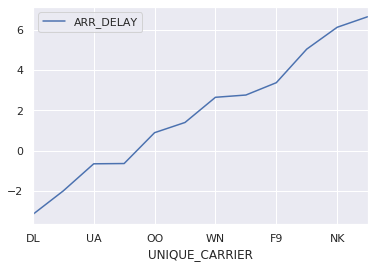

In [24]:
df_train[['ARR_DELAY', 'UNIQUE_CARRIER']].groupby('UNIQUE_CARRIER').mean().sort_values(by='ARR_DELAY', ascending=True).plot()

# Features encoding

In [17]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

from sklearn import decomposition
from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

import statistics

from scipy import sparse

'''
Cette fonction fait un 1 hot encoding des features qui sont des catégories
Old function not used anymore
'''
    
def add_categorical_features_1hot(df, categorical_features_totransform):
    #df.drop(labels=categorical_features_totransform, axis=1, inplace=True)
    
    
    #df_encoded = pd.get_dummies(df, columns=categorical_features_totransform, sparse=True)
    
    for feature_totransform in categorical_features_totransform:
        print(f'Adding 1hot Feature : {feature_totransform}')
        
        print('First')
        df_transformed = df[feature_totransform].str.get_dummies().add_prefix(feature_totransform +'_')   
        
        #df_new = pd.get_dummies(df, columns=['ORIGIN'])
        
        
        
        
        #df.drop(labels=feature_totransform, axis=1, inplace=True)
        print('Second')
        del df[feature_totransform]
        
        print('Third')
        df = pd.concat([df, df_transformed], axis=1)
        
    return(df)


class HHMM_to_Minutes(BaseEstimator, TransformerMixin):
    def __init__(self, features_toconvert = ['CRS_DEP_TIME', 'CRS_ARR_TIME']):
        self.features_toconvert = features_toconvert
        return None
    
    def fit(self, df):      
        return self
    
    def transform(self, df):       
        for feature_toconvert in self.features_toconvert:
            print(f'Converting feature {feature_toconvert}\n')
            #print('1\n')
            df_concat = pd.concat([df[feature_toconvert].str.slice(start=0,stop=2, step=1),df[feature_toconvert].str.slice(start=2,stop=4, step=1)], axis=1).astype(int).copy(deep=True)
                    
            #print('2\n')
            df[feature_toconvert] = (df_concat.iloc[:, [0]] * 60 + df_concat.iloc[:, [1]])[feature_toconvert]
            del df_concat
            
            #print('3\n')
        
        return(df)

    
class HHMM_to_HH(BaseEstimator, TransformerMixin):
    def __init__(self, features_toconvert = ['CRS_DEP_TIME', 'CRS_ARR_TIME']):
        self.features_toconvert = features_toconvert
        return None
    
    def fit(self, df):      
        return self
    
    def transform(self, df):       
        for feature_toconvert in self.features_toconvert:
            print(f'Converting feature {feature_toconvert}\n')
            #print('1\n')

            df.loc[:, feature_toconvert] = df[feature_toconvert].str.slice(start=0,stop=2, step=1)
        
        return(df)
    
'''
class CategoricalFeatures1HotEncoder_old(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_features_totransform=['ORIGIN', 'UNIQUE_CARRIER', 'DEST']):
        self.categorical_features_totransform = categorical_features_totransform
    
    def fit(self, df, labels=None):      
        return self
    
    def transform(self, df):
        # /!\ Array will not have the same shape if we fit an ensemble of samples that have less values than total dataset
        df_encoded = pd.get_dummies(df, columns=self.categorical_features_totransform, sparse=True)  # Sparse allows to gain memory. But then, standardscale must be with_mean=False
        #df_encoded = pd.get_dummies(df, columns=self.categorical_features_totransform, sparse=False)
        print('type of df : ' + str(type(df_encoded)))
        return(df_encoded)
'''

class CategoricalFeatures1HotEncoder(BaseEstimator, TransformerMixin):
    #def __init__(self, categorical_features_totransform=['ORIGIN', 'UNIQUE_CARRIER', 'DEST']):
    def __init__(self):
        #self.categorical_features_totransform = categorical_features_totransform
        self.fitted = False
        self.all_feature_values = {}
        #self.df_encoded = None
    
    #def fit(self, df, labels=None):      
    def fit(self, df, categorical_features_totransform=['ORIGIN', 'UNIQUE_CARRIER', 'DEST']):      
        print('Fit data')
        self.categorical_features_totransform = categorical_features_totransform
        print('!! categorical_features_totransform' + str(self.categorical_features_totransform))

        if (self.categorical_features_totransform != None):
            for feature_name in self.categorical_features_totransform:
                df[feature_name] = df[feature_name].astype(str) # Convert features to str in case they are not already     
                self.all_feature_values[feature_name] = feature_name + '_' + df[feature_name].unique()
        
        self.fitted = True
        
        return self
    
    def transform(self, df):
        if (self.fitted == False):
            self.fit(df)
        
        if (self.categorical_features_totransform != None):
            print('Transform data')
            
            print('1hot encode categorical features...')
            #df_encoded = pd.get_dummies(df, columns=self.categorical_features_totransform, sparse=True)  # Sparse allows to gain memory. But then, standardscale must be with_mean=False
            df_encoded = pd.get_dummies(df, columns=self.categorical_features_totransform, sparse=False)

            # Get category values that were in fitted data, but that are not in data to transform 
            for feature_name, feature_values in self.all_feature_values.items():
                diff_columns = list(set(feature_values) - set(df_encoded.columns.tolist()))
                print(f'Column values that were in fitted data but not in current data: {diff_columns}')

                if (len(diff_columns) > 0):
                    print('Adding those column with 0 values to the DataFrme...')
                    # Create columns with 0 for the above categories, in order to preserve same matrix shape between train et test set
                    zeros_dict = dict.fromkeys(diff_columns, 0)
                    df_encoded = df_encoded.assign(**zeros_dict)

            print('type of df : ' + str(type(df_encoded)))
            return(df_encoded)

        else:
            return(df)

class Aggregate_then_GroupByMean_then_Sort_numericalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_features_totransform=['ORIGIN', 'UNIQUE_CARRIER', 'DEST']):
        self.categorical_features_totransform = categorical_features_totransform
        self.fitted = False
        self.all_feature_values = {}
    
    def fit(self, df, labels=None):      
        print('Fit data')
        
        self.feature_maps = {}
        
        for feature_name in self.categorical_features_totransform:
            print(f'Fitting feature {feature_name}')
            # List all feature values ordered by mean delay
            list_feature_mean_ordered = df[['ARR_DELAY', feature_name]].groupby(feature_name).mean().sort_values(by='ARR_DELAY', ascending=True).index.tolist()
            
            # Generate a dictionary of feature values as keys and index as values
            self.feature_maps[feature_name] = {}
            self.feature_maps[feature_name]['list_feature_mean_ordered_dict'] = {list_feature_mean_ordered[i] : i for i in range(len(list_feature_mean_ordered))  }
            
            #print('Dictionnary : ' + str(self.feature_maps[feature_name]['list_feature_mean_ordered_dict']))
            
            # BUG : we had to do that line of code in transform instead, not in fit (result is the same, no difference)
            #self.feature_maps[feature_name]['list_feature_mean_ordered_mapper'] = lambda k : self.feature_maps[feature_name]['list_feature_mean_ordered_dict'][k]
                  
        self.fitted = True
        
        return self
    
    def transform(self, df):
        if (self.fitted == False):
            print('Launching fit first (if you see this message : ensure that you have passed training set as input, not test set)')
            self.fit(df)
        
        print('Encode categorical features...')
        
        for feature_name in self.categorical_features_totransform:
            print(f'Encoding feature {feature_name} ...')
            #print('Dictionnary : ' + str(self.feature_maps[feature_name]['list_feature_mean_ordered_dict']))
            
            # Replace each feature value by its index (the lowest the index, the lowest the mean delay is for this feature)
            list_feature_mean_ordered_mapper = lambda k : self.feature_maps[feature_name]['list_feature_mean_ordered_dict'][k]
                            
            #df[feature_name] = df.loc[:, feature_name].apply(self.feature_maps[feature_name]['list_feature_mean_ordered_mapper'])  # BUG (we had to use line below instead)
            df[feature_name] = df.loc[:, feature_name].apply(list_feature_mean_ordered_mapper)

        return(df)
    
    
class FeaturesSelector(BaseEstimator, TransformerMixin):
    def __init__(self, features_toselect = None):  # If None : every column is kept, nothing is done
        self.features_toselect = features_toselect
    
    def fit(self, df, labels=None):      
        return self
    
    def transform(self, df):       
        if (self.features_toselect != None):
            filter_cols = [col for col in df if (col.startswith(tuple(self.features_toselect)))]
            
            filter_cols.sort()
            
            print("Features selected (in order): " + str(df[filter_cols].columns))
            
            df = df.loc[:, filter_cols]
            return(df)

        else:
            return(df)

'''
In order have less features globally: we Keep only features_tofilter that represent percent_tokeep% of total values
Features which values represent less than percent_tokeep% will be set "OTHERS" value instead of their real value
'''

class Filter_High_Percentile(BaseEstimator, TransformerMixin):
    def __init__(self, features_tofilter = ['ORIGIN', 'DEST'], percent_tokeep = 80):
        self.features_tofilter = features_tofilter
        self.percent_tokeep = percent_tokeep
        self.high_percentile = None
        self.low_percentile = None
    
    def fit(self, df, labels=None): 
        print('Fit high percentile filter...')
        for feature_tofilter in self.features_tofilter:
            # Get feature_tofilter values that represent 80% of data
            self.high_percentile = ((((df[[feature_tofilter]].groupby(feature_tofilter).size() / len(df)).sort_values(ascending=False)) * 100).cumsum() < self.percent_tokeep).where(lambda x : x == True).dropna().index.values.tolist()
            self.low_percentile = ((((df[[feature_tofilter]].groupby(feature_tofilter).size() / len(df)).sort_values(ascending=False)) * 100).cumsum() >= self.percent_tokeep).where(lambda x : x == True).dropna().index.values.tolist()

            total = len(df[feature_tofilter].unique())
            high_percentile_sum = len(self.high_percentile)
            low_percentile_sum = len(self.low_percentile)
            high_low_sum = high_percentile_sum + low_percentile_sum

            print(f'Total number of {feature_tofilter} values : {total}')
            print(f'Number of {feature_tofilter} high percentile (> {self.percent_tokeep}%) values : {high_percentile_sum}')
            print(f'Number of {feature_tofilter} low percentile values : {low_percentile_sum}')
            print(f'Sum of high percentile + low percentile values : {high_low_sum}')
        
        print('End of high percentile filter fit')
        return self
    
    def transform(self, df):       
        if (self.features_tofilter != None):
            print('Apply high percentile filter...')
            
            for feature_tofilter in self.features_tofilter:
                print(f'Apply filter on feature {feature_tofilter}')
                # To do for later : apply low_percentile specific to the feature, and not only last calculated low_percentile  (in our case it's the same percentile for ORIGIN and DEST so this is not a problem)
                df.loc[df[feature_tofilter].isin(self.low_percentile), feature_tofilter] = 'OTHERS'   
            
            return(df)    

        else:
            return(df)
        

    
class DenseToSparseConverter(BaseEstimator, TransformerMixin):
    def __init__(self):  # If None : every column is kept, nothing is done
        return None
    
    def fit(self, matrix, labels=None):      
        return self
    
    def transform(self, matrix):   
        return(sparse.csr_matrix(matrix))

    
'''
This class adds polynomial features in univariate way  (if feature X and n_degree 3 :  then it will add X², X³, and an intercept at the end)

Requires ndarray as input
'''    
class PolynomialFeaturesUnivariateAdder(BaseEstimator, TransformerMixin):
    def __init__(self, n_degrees=2):
        self.n_degrees = n_degrees
        self.fitted = False
    
    def fit(self, df, labels=None):
        self.fitted = True
        return self
    
    def transform(self, df):
        if (self.fitted == False):
            self.fit(df)

        nb_instances, n_features = df.shape
        df_poly = np.empty((nb_instances, 0)) # Create empty array of nb_instances line and 0 features yet (we'll concatenate polynomial features to it)

        progbar = tqdm(range(n_features))
        print('Adding polynomial features')

        for feature_index in range(n_features):    
            df_1feature = df[:,feature_index]  # Reshape 

            for n_degree in range(self.n_degrees):
                df_poly = np.c_[df_poly, np.power(df_1feature, n_degree + 1)]

            progbar.update(1)

        # Add bias (intercept)
        df_poly = np.c_[df_poly, np.ones((len(df_poly), 1))]  # add x0 = 1 feature        
        
        return(df_poly)

'''
This class adds polynomial features in univariate way  (if feature X and n_degree 3 :  then it will add X², X³, and an intercept at the end)

Requires DataFrame as input
'''        
    
class PolynomialFeaturesUnivariateAdder_DataFrame(BaseEstimator, TransformerMixin):
    def __init__(self, n_degrees=2):
        self.n_degrees = n_degrees
        self.fitted = False
    
    def fit(self, df, features_toadd=None):  
        print('fit')
        self.features_toadd = features_toadd
        print('Features to add :')
        print(self.features_toadd)
        self.fitted = True
        return self
    
    def transform(self, df):
        print('transform')
        if (self.fitted == False):
            self.fit(df)

        nb_instances, n_features = df.shape
        #df_poly = np.empty((nb_instances, 0)) # Create empty array of nb_instances line and 0 features yet (we'll concatenate polynomial features to it)
        #df_poly = pd.DataFrame(index=df.index,columns=None)
        
        progbar = tqdm(range(len(self.features_toadd)))
        print('Adding polynomial features')

        for column_name in self.features_toadd:    
            #df_1feature = df.loc[:, column_name]

            for n_degree in range(1, self.n_degrees):
                #df = pd.concat([df, np.power(df.loc[:, column_name], n_degree + 1)], axis=1)
                df = pd.concat([df, np.power(df[[column_name]], n_degree + 1).rename(columns={column_name : column_name+'_DEG'+str(n_degree+1)})], axis=1)

            progbar.update(1)

        # Add bias (intercept)
        #df_poly = pd.concat([df_poly, np.ones((len(df_poly), 1))])  # add x0 = 1 feature        
        #del df
        return(df)    
    
    
class StandardScalerMultiple_old(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.fitted = False
    
    def fit(self, df, columns=None):              
        self.columns = columns
        self.scaler = StandardScaler()
  
        if (self.columns == None):
            return(df)
        else:
            self.scaler.fit(df[self.columns].to_numpy())            
        
        return self
    
    def transform(self, df):
        if (self.fitted == False):
            self.fit(df)
        
        if (self.columns == None):
            return(df)
        
        else:
            df[self.columns] = self.scaler.transform(df[self.columns].to_numpy())

        return(df)
        
class StandardScalerMultiple(BaseEstimator, TransformerMixin):
    def __init__(self, features_toscale=None):
        self.fitted = False
        self.columns = features_toscale
    
    def fit(self, df):              
        print('Fit Std scale multiple')
        self.scaler = StandardScaler()
  
        if (self.columns == None):
            self.fitted = True
            return(df)
        else:
            self.scaler.fit(df[self.columns].to_numpy())            
            self.fitted = True
        
        return self
    
    def transform(self, df):
        print('Transform Std scale multiple')
        if (self.fitted == False):
            self.fit(df)
        
        if (self.columns == None):
            return(df)
        
        else:
            df.loc[:, self.columns] = self.scaler.transform(df.loc[:, self.columns].to_numpy())

        return(df)
        

class MinMaxScalerMultiple(BaseEstimator, TransformerMixin):
    def __init__(self, features_toscale=None):
        self.fitted = False
        self.columns = features_toscale
    
    def fit(self, df):              
        print('Fit Min max scaler multiple')
        self.scaler = MinMaxScaler()
  
        if (self.columns == None):
            self.fitted = True
            return(df)
        else:
            self.scaler.fit(df[self.columns].to_numpy())            
            self.fitted = True
        
        return self
    
    def transform(self, df):
        print('Transform Min max scaler multiple')
        if (self.fitted == False):
            self.fit(df)
        
        if (self.columns == None):
            return(df)
        
        else:
            df.loc[:, self.columns] = self.scaler.transform(df.loc[:, self.columns].to_numpy())

        return(df)        
        
class LogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, features_totransform = None):  # If None : every column is kept, nothing is done
        self.features_toselect = features_toselect
    
    def fit(self, df, labels=None):      
        return self
    
    def transform(self, df):       
        if (self.features_toselect != None):
            filter_cols = [col for col in df if (col.startswith(tuple(self.features_toselect)))]
            
            filter_cols.sort()
            
            print("Features selected (in order): " + str(df[filter_cols].columns))
            
            df = df.loc[:, filter_cols]
            return(df)

        else:
            return(df)
 
        
        
'''
conversion_pipeline = Pipeline([
    ('data_converter', HHMM_to_Minutes()),
    #('categoricalfeatures_1hotencoder', CategoricalFeatures1HotEncoder()),
    #('standardscaler', preprocessing.StandardScaler()),
])
'''

preparation_pipeline = Pipeline([
    ('filter_highpercentile', Filter_High_Percentile()),
    ('data_converter', HHMM_to_Minutes()),
    ('categoricalfeatures_1hotencoder', CategoricalFeatures1HotEncoder()),
    #('standardscaler', preprocessing.StandardScaler()),
])


'''
preparation_pipeline_meansort = Pipeline([
    #('filter_highpercentile', Filter_High_Percentile()),
    ('data_converter', HHMM_to_Minutes()),
    ('numericalEncoder', Aggregate_then_GroupByMean_then_Sort_numericalEncoder()),
    #('standardscaler', preprocessing.StandardScaler()),
])
'''

preparation_pipeline_meansort = Pipeline([
    #('filter_highpercentile', Filter_High_Percentile()),
    ('data_converter', HHMM_to_Minutes()),
    ('numericalEncoder', Aggregate_then_GroupByMean_then_Sort_numericalEncoder()),
    ('categoricalfeatures_1hotencoder', CategoricalFeatures1HotEncoder()),
    #('standardscaler', preprocessing.StandardScaler()),
])


# If matrix is sparse, with_mean=False must be passed to StandardScaler
prediction_pipeline = Pipeline([
    ('features_selector', FeaturesSelector(features_toselect=MODEL1_FEATURES)),
    ('standardscaler', ColumnTransformer([
        ('standardscaler_specific', StandardScaler(), MODEL1_FEATURES_QUANTITATIVE)
    ], remainder='passthrough', sparse_threshold=1)),
    
    ('dense_to_sparse_converter', DenseToSparseConverter()),
    #('predictor', To_Complete(predictor_params =  {'n_neighbors':6, 'algorithm':'ball_tree', 'metric':'minkowski'})),
])
#copy=False passed to StandardScaler() allows to gain memory


prediction_pipeline_without_sparse = Pipeline([
    ('features_selector', FeaturesSelector(features_toselect=MODEL1_FEATURES)),
    ('standardscaler', ColumnTransformer([
        ('standardscaler_specific', StandardScaler(), MODEL1_FEATURES_QUANTITATIVE)
    #], remainder='passthrough', sparse_threshold=1)), # For sparse output. Seems not to work well.
    ], remainder='passthrough')),
    
    #('dense_to_sparse_converter', DenseToSparseConverter()),
    #('predictor', To_Complete(predictor_params =  {'n_neighbors':6, 'algorithm':'ball_tree', 'metric':'minkowski'})),
])

prediction_pipeline_groupbymean = Pipeline([
    ('features_selector', FeaturesSelector(features_toselect=MODEL1_GOUPBYMEAN_FEATURES)),
    ('standardscaler', ColumnTransformer([
        ('standardscaler_specific', StandardScaler(), MODEL_GROUPBYMEAN_FEATURES_QUANTITATIVE)
    ], remainder='passthrough')),
    #], remainder='passthrough', sparse_threshold=1)), # For sparse output. Seems not to work well.
    
    #('dense_to_sparse_converter', DenseToSparseConverter()),
    #('predictor', To_Complete(predictor_params =  {'n_neighbors':6, 'algorithm':'ball_tree', 'metric':'minkowski'})),
])



prediction_pipeline_1hotall_without_sparse = Pipeline([
    ('features_selector', FeaturesSelector(features_toselect=MODEL1_FEATURES)),
    ('standardscaler', ColumnTransformer([
        ('standardscaler_specific', StandardScaler(), MODEL1bis_FEATURES_QUANTITATIVE)
    ], remainder='passthrough', sparse_threshold=1)),
    
    #('dense_to_sparse_converter', DenseToSparseConverter()),
    #('predictor', To_Complete(predictor_params =  {'n_neighbors':6, 'algorithm':'ball_tree', 'metric':'minkowski'})),
])

prediction_pipeline_cheat_without_sparse = Pipeline([
    ('features_selector', FeaturesSelector(features_toselect=MODEL_cheat_FEATURES)),
    ('standardscaler', ColumnTransformer([
        ('standardscaler_specific', StandardScaler(), MODEL_cheat_FEATURES_QUANTITATIVE)
    ], remainder='passthrough', sparse_threshold=1)),
    
    #('dense_to_sparse_converter', DenseToSparseConverter()),
    #('predictor', To_Complete(predictor_params =  {'n_neighbors':6, 'algorithm':'ball_tree', 'metric':'minkowski'})),
])



preparation_pipeline_meansort_stdscale = Pipeline([
    ('data_converter', HHMM_to_Minutes()),
    ('numericalEncoder', Aggregate_then_GroupByMean_then_Sort_numericalEncoder()),
    #('categoricalfeatures_1hotencoder', CategoricalFeatures1HotEncoder()),
    ('features_selector', FeaturesSelector(features_toselect=MODEL1_GOUPBYMEAN_FEATURES)),
    ('standardscaler', StandardScalerMultiple(features_toscale=MODEL1_GOUPBYMEAN_FEATURES)),
])


# To defined features to 1hot encode, pass fit_transform parameter below:  
# categoricalfeatures_1hotencoder__categorical_features_totransform=['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'ORIGIN', 'UNIQUE_CARRIER', 'CRS_DEP_TIME']
preparation_pipeline_1hotall_minmax = Pipeline([
    ('filter_highpercentile', Filter_High_Percentile()),
    ('hour_extractor', HHMM_to_HH()),
    ('categoricalfeatures_1hotencoder', CategoricalFeatures1HotEncoder()), 
    
    ('features_selector', FeaturesSelector(features_toselect=MODEL_1HOTALL_FEATURES)),
    ('minmaxscaler', MinMaxScalerMultiple(features_toscale=MODEL_1HOTALL_FEATURES_QUANTITATIVE)),
])


preparation_pipeline_2feats_stdscale = Pipeline([
    #('filter_highpercentile', Filter_High_Percentile()),
    #('hour_extractor', HHMM_to_HH()),
    #('categoricalfeatures_1hotencoder', CategoricalFeatures1HotEncoder()), 
    
    ('features_selector', FeaturesSelector(features_toselect=MODEL1_2FEATS)),
    #('standardscaler', StandardScalerMultiple(features_toscale=MODEL1_2FEATS_QUANTITATIVE)),
])


'''
# Old code that used scikit learn OneHotEncoder (which does not keep DataFrame type) instead of Pandas
preparation_pipeline2 = Pipeline([
    ('data_converter', HHMM_to_Minutes()),
    ('multiple_encoder', ColumnTransformer([
        ('categoricalfeatures_1hotencoder', OneHotEncoder(), ['ORIGIN', 'UNIQUE_CARRIER', 'DEST'])
    ], remainder='passthrough')),
    #('standardscaler', preprocessing.StandardScaler()),
])
'''

'''
ColumnTransformer([
        ('standardscaler_specific', StandardScaler(), ['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'DISTANCE', 'CRS_ELAPSED_TIME', 'ARR_DELAY', 'DEP_DELAY', 'TAXI_OUT'])
    ], remainder='passthrough')
'''

"\nColumnTransformer([\n        ('standardscaler_specific', StandardScaler(), ['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'DISTANCE', 'CRS_ELAPSED_TIME', 'ARR_DELAY', 'DEP_DELAY', 'TAXI_OUT'])\n    ], remainder='passthrough')\n"

In [34]:
df

,ORIGIN,CRS_DEP_TIME,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,DEST,CRS_ARR_TIME,DISTANCE,CRS_ELAPSED_TIME,ARR_DELAY,DEP_DELAY,TAXI_OUT,TAIL_NUM,NBFLIGHTS_FORDAY_FORAIRPORT,NBFLIGHTS_FORDAYHOUR_FORAIRPORT
4940638,SLC,0855,11,25,5,OO,DEN,1030,391.0,95.0,-18.0,-1.0,8.0,N751SK,195,6
4409300,PDX,0600,10,3,1,AA,DFW,1153,1616.0,233.0,-18.0,-1.0,16.0,N3KVAA,171,19
4621357,SDF,1228,11,10,4,DL,ATL,1357,321.0,89.0,-7.0,-1.0,14.0,N920DE,28,3
2360236,JFK,0930,3,7,1,DL,LAX,1300,2475.0,390.0,-32.0,3.0,11.0,N706TW,405,30
4849184,LAX,0955,11,1,2,OO,SEA,1252,954.0,177.0,-6.0,-7.0,21.0,N784SK,576,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5497570,LAS,0800,8,19,5,WN,BDL,1550,2297.0,290.0,-2.0,-3.0,10.0,N473WN,435,27
2463407,SFO,2300,3,25,5,DL,CVG,0629,2036.0,269.0,-7.0,-3.0,23.0,N318US,568,22
1472848,LAX,1305,5,20,5,DL,MSP,1843,1535.0,218.0,-1.0,0.0,20.0,N128DL,595,38
16064,DFW,1252,9,20,2,AA,BOS,1737,1562.0,225.0,-1.0,-5.0,28.0,N3AXAA,545,49


In [48]:
np.power(df[['MONTH']], 2).rename(columns={'MONTH' : 'MONTH2'})

,MONTH2
4940638,121
4409300,100
4621357,121
2360236,9
4849184,121
...,...
5497570,64
2463407,9
1472848,25
16064,81


In [40]:
df[['MONTH']].rename(columns={'MONTH' : 'MONTH2'})

,MONTH2
4940638,11
4409300,10
4621357,11
2360236,3
4849184,11
...,...
5497570,8
2463407,3
1472848,5
16064,9


In [46]:
(df.loc[:, 'MONTH'].rename(columns={'MONTH' : 'MONTH2'}))

4940638    11
4409300    10
4621357    11
2360236     3
4849184    11
           ..
5497570     8
2463407     3
1472848     5
16064       9
2439177     3
Length: 800000, dtype: int64

In [ ]:
np.power(df.loc[:, column_name], n_degree + 1).rename(columns={column_name : 'bla'})]

In [20]:
df

NameError: name 'df' is not defined

In [26]:
df_train_transformed = preparation_pipeline.fit_transform(df_train)

Fit high percentile filter...
Total number of ORIGIN values : 308
Number of ORIGIN high percentile (> 80%) values : 45
Number of ORIGIN low percentile values : 263
Sum of high percentile + low percentile values : 308
Total number of DEST values : 308
Number of DEST high percentile (> 80%) values : 45
Number of DEST low percentile values : 263
Sum of high percentile + low percentile values : 308
End of high percentile filter fit
Apply high percentile filter...
Apply filter on feature ORIGIN
Apply filter on feature DEST
Converting feature CRS_DEP_TIME

Converting feature CRS_ARR_TIME

Fit data
!! categorical_features_totransform['ORIGIN', 'UNIQUE_CARRIER', 'DEST']
Transform data
1hot encode categorical features...
Column values that were in fitted data but not in current data: []
Column values that were in fitted data but not in current data: []
Column values that were in fitted data but not in current data: []
type of df : <class 'pandas.core.frame.DataFrame'>


In [27]:
df_train_transformed

,CRS_DEP_TIME,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,CRS_ARR_TIME,DISTANCE,CRS_ELAPSED_TIME,ARR_DELAY,DEP_DELAY,TAXI_OUT,...,DEST_SAN,DEST_SAT,DEST_SEA,DEST_SFO,DEST_SJC,DEST_SLC,DEST_SMF,DEST_SNA,DEST_STL,DEST_TPA
1429048,630,5,1,7,1125,2454.0,315.0,35.0,-3.0,28.0,...,0,0,0,0,0,0,0,0,0,0
1934633,665,12,20,2,730,669.0,125.0,-10.0,-1.0,13.0,...,0,0,0,0,0,0,0,0,0,0
4005924,622,1,3,7,820,844.0,138.0,-8.0,-5.0,16.0,...,0,0,0,0,0,0,0,0,0,0
3374879,855,4,7,4,900,148.0,45.0,55.0,54.0,10.0,...,0,0,0,0,0,0,0,0,0,0
4722460,930,11,27,7,1115,1381.0,245.0,-3.0,1.0,30.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3091034,1140,2,29,1,1269,516.0,129.0,-16.0,-2.0,13.0,...,0,0,0,0,0,0,0,0,0,0
3335806,539,3,13,7,736,2496.0,377.0,12.0,9.0,13.0,...,0,0,1,0,0,0,0,0,0,0
2699423,1315,3,18,5,1405,414.0,90.0,-5.0,8.0,7.0,...,0,0,0,0,0,0,0,0,0,0
3221536,480,2,26,5,820,1642.0,220.0,-10.0,-3.0,14.0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
df_train_transformed.shape

(1800000, 117)

In [29]:
df_train_transformed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1800000 entries, 1429048 to 857811
Columns: 117 entries, CRS_DEP_TIME to DEST_TPA
dtypes: float64(5), int64(7), object(1), uint8(104)
memory usage: 370.8+ MB


In [30]:
#df_train_transformed = prediction_pipeline.fit_transform(df_train_transformed)  # Used if standard scale not commented out
df_train_transformed = prediction_pipeline_without_sparse.fit_transform(df_train_transformed)

Features selected (in order): Index(['CRS_ARR_TIME', 'CRS_DEP_TIME', 'CRS_ELAPSED_TIME', 'DAY_OF_MONTH',
       'DAY_OF_WEEK', 'DEST_ATL', 'DEST_AUS', 'DEST_BNA', 'DEST_BOS',
       'DEST_BWI',
       ...
       'UNIQUE_CARRIER_B6', 'UNIQUE_CARRIER_DL', 'UNIQUE_CARRIER_EV',
       'UNIQUE_CARRIER_F9', 'UNIQUE_CARRIER_HA', 'UNIQUE_CARRIER_NK',
       'UNIQUE_CARRIER_OO', 'UNIQUE_CARRIER_UA', 'UNIQUE_CARRIER_VX',
       'UNIQUE_CARRIER_WN'],
      dtype='object', length=113)


In [31]:
df_train_transformed.shape

(1800000, 113)

In [32]:
from scipy import sparse
sparse.issparse(df_train_transformed)

False

In [33]:
#pd.DataFrame.sparse.from_spmatrix(df_train_transformed)

In [34]:
pd.set_option('display.max_columns', 400)

In [35]:
all_features, model1_features, model1_label, quantitative_features, qualitative_features = identify_features(df)

Quantitative features : ['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'DISTANCE', 'CRS_ELAPSED_TIME', 'ARR_DELAY', 'DEP_DELAY', 'TAXI_OUT', 'NBFLIGHTS_FORDAYHOUR_FORAIRPORT', 'NBFLIGHTS_FORDAY_FORAIRPORT'] 

Qualitative features : ['ORIGIN', 'CRS_DEP_TIME', 'UNIQUE_CARRIER', 'DEST', 'CRS_ARR_TIME', 'TAIL_NUM'] 



# Test set encoding

In [36]:
df_test_transformed = preparation_pipeline.transform(df_test)
#df_test_transformed = prediction_pipeline.transform(df_test_transformed)  # Used if standardscale not commented out
df_test_transformed = prediction_pipeline_without_sparse.transform(df_test_transformed)
DATA_LOADED = True
df_test_transformed.shape

Apply high percentile filter...
Apply filter on feature ORIGIN
Apply filter on feature DEST
Converting feature CRS_DEP_TIME

Converting feature CRS_ARR_TIME

Transform data
1hot encode categorical features...
Column values that were in fitted data but not in current data: []
Column values that were in fitted data but not in current data: []
Column values that were in fitted data but not in current data: []
type of df : <class 'pandas.core.frame.DataFrame'>
Features selected (in order): Index(['CRS_ARR_TIME', 'CRS_DEP_TIME', 'CRS_ELAPSED_TIME', 'DAY_OF_MONTH',
       'DAY_OF_WEEK', 'DEST_ATL', 'DEST_AUS', 'DEST_BNA', 'DEST_BOS',
       'DEST_BWI',
       ...
       'UNIQUE_CARRIER_B6', 'UNIQUE_CARRIER_DL', 'UNIQUE_CARRIER_EV',
       'UNIQUE_CARRIER_F9', 'UNIQUE_CARRIER_HA', 'UNIQUE_CARRIER_NK',
       'UNIQUE_CARRIER_OO', 'UNIQUE_CARRIER_UA', 'UNIQUE_CARRIER_VX',
       'UNIQUE_CARRIER_WN'],
      dtype='object', length=113)


(200000, 113)

In [37]:
df_train_transformed

array([[-0.60570708, -0.44602123, -1.68170455, ...,  0.        ,
         0.        ,  0.        ],
       [-0.4867488 ,  1.60774767,  0.47632656, ...,  0.        ,
         0.        ,  0.        ],
       [-0.63289755, -1.61960346, -1.45454338, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.72247645, -1.03281234,  0.24916539, ...,  0.        ,
         1.        ,  0.        ],
       [-1.11552829, -1.3262079 ,  1.15781006, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.34595918,  0.14076988, -0.5458987 , ...,  0.        ,
         0.        ,  0.        ]])

In [38]:
df_test[model1_label]

4466760     3.0
1378222    -5.0
2439283    -8.0
2575882    13.0
361488    -25.0
           ... 
2734407   -31.0
1922997    -4.0
2403892     9.0
3906369   -23.0
1651982     8.0
Name: ARR_DELAY, Length: 200000, dtype: float64

In [39]:
df_test.index

Int64Index([4466760, 1378222, 2439283, 2575882,  361488,  814770, 2008247,
            4356557, 4140071, 1404108,
            ...
            5078673, 2007753, 3526158, 4181538, 5438811, 2734407, 1922997,
            2403892, 3906369, 1651982],
           dtype='int64', length=200000)

In [40]:
df.loc[df_test.index, model1_label]

4466760     3.0
1378222    -5.0
2439283    -8.0
2575882    13.0
361488    -25.0
           ... 
2734407   -31.0
1922997    -4.0
2403892     9.0
3906369   -23.0
1651982     8.0
Name: ARR_DELAY, Length: 200000, dtype: float64

# Linear regression

In [41]:
df_train[model1_label].shape

(1800000,)

In [42]:
# Add bias :
df_train_transformed = np.c_[np.ones((len(df_train_transformed), 1)), df_train_transformed]  # add x0 = 1 to each instance
df_test_transformed = np.c_[np.ones((len(df_test_transformed), 1)), df_test_transformed]  # add x0 = 1 to each instance

In [43]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    lin_reg = LinearRegression(normalize=False, fit_intercept=True)
    #lin_reg = TransformedTargetRegressor(regressor=lin_reg, transformer=StandardScaler())  # To scale y variable
    lin_reg.fit(df_train_transformed, df_train[model1_label])

In [46]:
lin_reg = linear_model.SGDRegressor(alpha=0,max_iter=200)
lin_reg.fit(df_train_transformed, df_train[model1_label])

SGDRegressor(alpha=0, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=200,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [92]:
df_train.iloc[25, :]

ORIGIN                                LAS
CRS_DEP_TIME                          660
MONTH                                   7
DAY_OF_MONTH                            1
DAY_OF_WEEK                             5
UNIQUE_CARRIER                         WN
DEST                               OTHERS
CRS_ARR_TIME                          895
DISTANCE                              775
CRS_ELAPSED_TIME                      115
ARR_DELAY                             -10
DEP_DELAY                              -6
TAXI_OUT                                8
TAIL_NUM                           N951WN
NBFLIGHTS_FORDAY_FORAIRPORT           436
NBFLIGHTS_FORDAYHOUR_FORAIRPORT        33
Name: 461608, dtype: object

In [93]:
df_train.iloc[25, :]

ORIGIN                                LAS
CRS_DEP_TIME                          660
MONTH                                   7
DAY_OF_MONTH                            1
DAY_OF_WEEK                             5
UNIQUE_CARRIER                         WN
DEST                               OTHERS
CRS_ARR_TIME                          895
DISTANCE                              775
CRS_ELAPSED_TIME                      115
ARR_DELAY                             -10
DEP_DELAY                              -6
TAXI_OUT                                8
TAIL_NUM                           N951WN
NBFLIGHTS_FORDAY_FORAIRPORT           436
NBFLIGHTS_FORDAYHOUR_FORAIRPORT        33
Name: 461608, dtype: object

In [94]:
df

,ORIGIN,CRS_DEP_TIME,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,DEST,CRS_ARR_TIME,DISTANCE,CRS_ELAPSED_TIME,ARR_DELAY,DEP_DELAY,TAXI_OUT,TAIL_NUM,NBFLIGHTS_FORDAY_FORAIRPORT,NBFLIGHTS_FORDAYHOUR_FORAIRPORT
2223958,EWR,1551,12,5,1,UA,DFW,1853,1372.0,242.0,19.0,24.0,13.0,N16701,355,26
4098092,FLL,1020,1,19,2,WN,MCI,1250,1242.0,210.0,-20.0,-5.0,14.0,N205WN,234,14
2639568,DLH,0515,3,8,2,OO,MSP,0619,144.0,64.0,-17.0,-4.0,14.0,N816SK,8,1
17417,PHX,2010,9,23,5,AA,ONT,2128,325.0,78.0,64.0,71.0,16.0,N3CYAA,428,33
410962,EWR,0835,9,26,1,EV,PWM,0953,284.0,78.0,6.0,4.0,25.0,N13995,348,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3964180,ORD,1510,1,17,7,AA,CLT,1803,599.0,113.0,-4.0,2.0,12.0,N701UW,557,40
2163350,SEA,1515,12,19,1,OO,PHX,1910,1107.0,175.0,2.0,-5.0,39.0,N242SY,374,19
3954652,ATL,1030,1,16,6,DL,JAX,1136,270.0,66.0,-3.0,-2.0,17.0,N942DL,700,66
3482781,MYR,2043,4,10,7,NK,DTW,2239,636.0,116.0,-11.0,-9.0,9.0,N616NK,12,1


In [95]:
df_train.iloc[50, :]

ORIGIN                                IAH
CRS_DEP_TIME                          525
MONTH                                   5
DAY_OF_MONTH                            3
DAY_OF_WEEK                             2
UNIQUE_CARRIER                         EV
DEST                               OTHERS
CRS_ARR_TIME                          630
DISTANCE                              562
CRS_ELAPSED_TIME                      105
ARR_DELAY                             -19
DEP_DELAY                              -7
TAXI_OUT                               12
TAIL_NUM                           N14168
NBFLIGHTS_FORDAY_FORAIRPORT           359
NBFLIGHTS_FORDAYHOUR_FORAIRPORT        18
Name: 1517165, dtype: object

In [45]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    df_test_predictions = lin_reg.predict(df_test_transformed)
    lin_mse = mean_squared_error(df_test[model1_label], df_test_predictions)
    lin_rmse = np.sqrt(lin_mse)
    print(lin_rmse)

27.00563263795778


=> 42.17  (42.16679389006135)  
=> 26.998703285049196  with outliers removed  
=> 26.998703285632104 with TransformedTargetRegressor  
=> 26.99870280932372 without standardscale  
=> 27.00905767522797 with SGDRegressor ((alpha=0,max_iter=200) and standarscale

In [51]:
print("Evaluation on training set :")
evaluate_model(lin_reg, df_train_transformed, df_train[model1_label])

Evaluation on training set :
RMSE : 27.003038599792692


In [52]:
df_train_transformed.shape[0]

720000

Calculating learning curve for 73 iterations


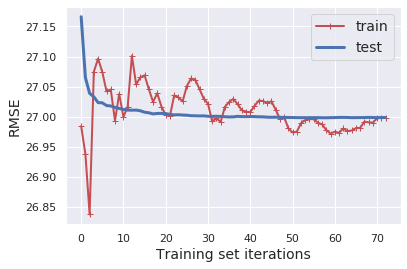

In [53]:
plot_learning_curves(lin_reg, df_train_transformed, df_test_transformed, df_train[model1_label], df_test[model1_label], LEARNING_CURVE_STEP_SIZE)

In [54]:
df_train

,ORIGIN,CRS_DEP_TIME,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,DEST,CRS_ARR_TIME,DISTANCE,CRS_ELAPSED_TIME,ARR_DELAY,DEP_DELAY,TAXI_OUT,TAIL_NUM,NBFLIGHTS_FORDAY_FORAIRPORT,NBFLIGHTS_FORDAYHOUR_FORAIRPORT
1802104,EWR,820,5,21,6,AA,PHX,963,2133.0,323.0,4.0,24.0,15.0,N3NDAA,238,14
5353235,SAN,946,8,16,2,OO,OTHERS,1134,749.0,128.0,-5.0,-2.0,10.0,N178SY,229,11
1778352,LAX,750,5,9,1,AA,JFK,1269,2475.0,339.0,2.0,0.0,16.0,N791AA,591,33
4923518,IAD,755,11,23,3,UA,ORD,818,588.0,123.0,-3.0,1.0,13.0,N18243,108,10
2470767,LAS,645,3,1,2,WN,MCI,925,1139.0,160.0,-7.0,-3.0,11.0,N8601C,449,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2964919,SMF,597,2,6,6,AA,PHX,761,647.0,104.0,-2.0,-2.0,10.0,N836AW,70,4
2348397,ATL,1177,3,1,2,DL,MKE,1250,669.0,133.0,-8.0,-3.0,27.0,N951DN,1782,164
231953,OTHERS,815,9,18,7,VX,LAX,1310,2486.0,315.0,40.0,44.0,8.0,N284VA,63,7
173151,LAX,495,9,27,2,OO,SMF,590,373.0,95.0,-14.0,-5.0,25.0,N805SK,591,49


In [56]:
df_train[[model1_label]]

,ARR_DELAY
1802104,4.0
5353235,-5.0
1778352,2.0
4923518,-3.0
2470767,-7.0
...,...
2964919,-2.0
2348397,-8.0
231953,40.0
173151,-14.0


In [51]:
lin_reg.coef_

array([ 4.02958229e-03,  9.60701740e-03, -1.33942019e-01,  3.30595990e-02,
        5.38154658e-02, -6.92368736e+08, -6.92368736e+08, -6.92368737e+08,
       -6.92368736e+08, -6.92368738e+08, -6.92368738e+08, -6.92368736e+08,
       -6.92368735e+08, -6.92368736e+08, -6.92368736e+08, -6.92368733e+08,
       -6.92368737e+08, -6.92368730e+08, -6.92368735e+08, -6.92368733e+08,
       -6.92368735e+08, -6.92368739e+08, -6.92368736e+08, -6.92368734e+08,
       -6.92368735e+08, -6.92368729e+08, -6.92368729e+08, -6.92368737e+08,
       -6.92368735e+08, -6.92368738e+08, -6.92368733e+08, -6.92368738e+08,
       -6.92368735e+08, -6.92368737e+08, -6.92368734e+08, -6.92368732e+08,
       -6.92368737e+08, -6.92368735e+08, -6.92368736e+08, -6.92368734e+08,
       -6.92368737e+08, -6.92368736e+08, -6.92368737e+08, -6.92368733e+08,
       -6.92368727e+08, -6.92368734e+08, -6.92368737e+08, -6.92368735e+08,
       -6.92368737e+08, -6.92368737e+08, -6.92368736e+08,  1.47490799e-02,
        1.32803679e-01,  

array([  3.0601343 ,   0.54106613,   0.49255945,  -0.02052923,
         1.6354574 ,  10.62073489, -12.18551101,   0.27450354,
        -1.33980503,   0.10149764,   0.31685657,  -0.65541914,
        -1.53379643,  -0.56033462,   2.17482374,   0.23276129,
        -1.26869889,   3.05226253,   0.18607054,   5.51988916,
         1.42903568,  -4.32234874,   0.30318026,  -0.94593642,
        -1.40645942,   4.27814774,  -0.06934268,   2.69507292,
         4.87336364,  -1.91588117,   1.21284379,  -1.94274921,
         4.73238555,  -3.20774291,   0.47564597,  -1.6987073 ,
         0.14379464,   4.40476573,  -1.74618153,  -2.76805405,
         0.45234394,  -1.60170948,   1.1685909 ,  -2.46122663,
        -1.75186943,  -0.42718454,   3.2389558 ,  -0.80286191,
        -3.11232599,  -0.71881518,  -3.40806787,  -1.02946792,
        -0.57180507,   0.58845347,  -5.32955616,   4.14911968,
        -3.77501356,   1.94734073,   5.04213062,  -3.46294331,
         4.36932467,   1.10828485,  -3.07715486,  -2.1540515 ,
         0.59406537,  -0.21559221,  -1.4864192 ,  -1.92685958,
        -1.13360134,  -2.79307414,  -3.16535316,  -2.14418489,
        -0.3786179 ,  -1.35651547,  -0.65089003,   3.72717084,
        -0.5316482 ,   6.38411318,   0.56280763,   2.32285819,
        -0.71875407,  -3.7427498 ,  -0.72443612,   3.01913525,
         0.0259135 ,   6.05048444,   6.88297842,  -2.05348981,
         0.57619293,  -3.06150148,   2.91489312,  -3.69821352,
         1.39265583,  -2.73996445,   0.48819288,   3.78111808,
        -2.73090349,  -0.99799275,  -1.41459568,  -0.14998697,
        -1.16199228,  -1.2855059 ,  -2.33902093,   2.26562809,
         9.46369559,  -0.27437885,  -1.82963879,   0.47213692,
        -2.5256052 ,  -2.053249  ,  -1.04523965])

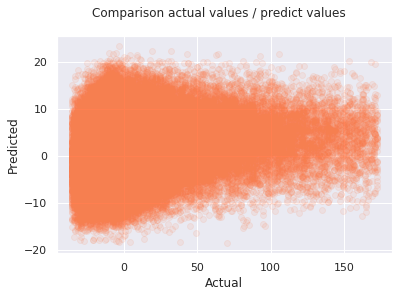

In [46]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison actual values / predict values')
    plt.ylabel("Predicted")
    plt.xlabel("Actual")
    plt.scatter(df_test[model1_label], df_test_predictions, color='coral', alpha=0.1)

In [44]:
df_train_transformed

,CRS_ARR_TIME,CRS_DEP_TIME,CRS_ELAPSED_TIME,DAY_OF_MONTH,DAY_OF_WEEK,DEST_ATL,DEST_AUS,DEST_BNA,DEST_BOS,DEST_BWI,DEST_CLE,DEST_CLT,DEST_DAL,DEST_DCA,DEST_DEN,DEST_DFW,DEST_DTW,DEST_EWR,DEST_FLL,DEST_HNL,DEST_HOU,DEST_IAD,DEST_IAH,DEST_JFK,DEST_LAS,DEST_LAX,DEST_LGA,DEST_MCI,DEST_MCO,DEST_MDW,DEST_MIA,DEST_MKE,DEST_MSP,DEST_MSY,DEST_OAK,DEST_ORD,DEST_OTHERS,DEST_PDX,DEST_PHL,DEST_PHX,DEST_RDU,DEST_SAN,DEST_SAT,DEST_SEA,DEST_SFO,DEST_SJC,DEST_SLC,DEST_SMF,DEST_SNA,DEST_STL,DEST_TPA,DISTANCE,MONTH,NBFLIGHTS_FORDAYHOUR_FORAIRPORT,NBFLIGHTS_FORDAY_FORAIRPORT,ORIGIN_ATL,ORIGIN_AUS,ORIGIN_BNA,ORIGIN_BOS,ORIGIN_BWI,ORIGIN_CLE,ORIGIN_CLT,ORIGIN_DAL,ORIGIN_DCA,ORIGIN_DEN,ORIGIN_DFW,ORIGIN_DTW,ORIGIN_EWR,ORIGIN_FLL,ORIGIN_HNL,ORIGIN_HOU,ORIGIN_IAD,ORIGIN_IAH,ORIGIN_JFK,ORIGIN_LAS,ORIGIN_LAX,ORIGIN_LGA,ORIGIN_MCI,ORIGIN_MCO,ORIGIN_MDW,ORIGIN_MIA,ORIGIN_MKE,ORIGIN_MSP,ORIGIN_MSY,ORIGIN_OAK,ORIGIN_ORD,ORIGIN_OTHERS,ORIGIN_PDX,ORIGIN_PHL,ORIGIN_PHX,ORIGIN_RDU,ORIGIN_SAN,ORIGIN_SAT,ORIGIN_SEA,ORIGIN_SFO,ORIGIN_SJC,ORIGIN_SLC,ORIGIN_SMF,ORIGIN_SNA,ORIGIN_STL,ORIGIN_TPA,UNIQUE_CARRIER_AA,UNIQUE_CARRIER_AS,UNIQUE_CARRIER_B6,UNIQUE_CARRIER_DL,UNIQUE_CARRIER_EV,UNIQUE_CARRIER_F9,UNIQUE_CARRIER_HA,UNIQUE_CARRIER_NK,UNIQUE_CARRIER_OO,UNIQUE_CARRIER_UA,UNIQUE_CARRIER_VX,UNIQUE_CARRIER_WN
1802104,963,820,323.0,21,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2133.0,5,14,238,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
5353235,1134,946,128.0,16,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,749.0,8,11,229,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1778352,1269,750,339.0,9,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2475.0,5,33,591,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4923518,818,755,123.0,23,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,588.0,11,10,108,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2470767,925,645,160.0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1139.0,3,34,449,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2964919,761,597,104.0,6,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,647.0,2,4,70,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2348397,1250,1177,133.0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,669.0,3,164,1782,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
231953,1310,815,315.0,18,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2486.0,9,7,63,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
173151,590,495,95.0,27,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,373.0,9,49,591,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


(array([1.2000e+01, 1.1000e+01, 1.0000e+01, 4.1000e+01, 8.6000e+01,
        1.4300e+02, 3.1400e+02, 5.1600e+02, 9.9800e+02, 1.5450e+03,
        1.9250e+03, 2.2870e+03, 3.2120e+03, 4.1710e+03, 5.1260e+03,
        6.0440e+03, 7.2120e+03, 8.1830e+03, 9.1620e+03, 1.0025e+04,
        1.0758e+04, 1.1151e+04, 1.1585e+04, 1.1640e+04, 1.1407e+04,
        1.1149e+04, 1.0440e+04, 9.5390e+03, 9.3110e+03, 8.1950e+03,
        7.0980e+03, 6.1890e+03, 5.3320e+03, 4.3050e+03, 3.2400e+03,
        2.3030e+03, 1.6080e+03, 1.0520e+03, 8.4200e+02, 6.4400e+02,
        4.0300e+02, 2.9000e+02, 1.9900e+02, 1.2000e+02, 9.5000e+01,
        4.7000e+01, 2.0000e+01, 1.0000e+01, 4.0000e+00, 1.0000e+00]),
 array([-18.671875, -17.82875 , -16.985625, -16.1425  , -15.299375,
        -14.45625 , -13.613125, -12.77    , -11.926875, -11.08375 ,
        -10.240625,  -9.3975  ,  -8.554375,  -7.71125 ,  -6.868125,
         -6.025   ,  -5.181875,  -4.33875 ,  -3.495625,  -2.6525  ,
         -1.809375,  -0.96625 ,  -0.123125,   

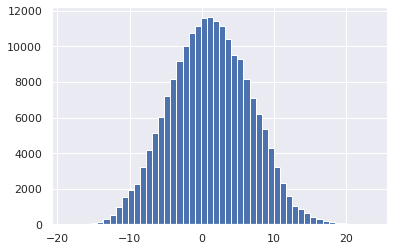

In [47]:
plt.hist(df_test_predictions, bins=50)

(array([ 2615.,  4303.,  7930., 13266., 19370., 24155., 25258., 27159.,
        16161., 11704.,  8476.,  6329.,  4728.,  3734.,  3693.,  2353.,
         1987.,  1686.,  1478.,  1277.,  1118.,  1247.,   876.,   791.,
          711.,   654.,   597.,   552.,   620.,   457.,   413.,   385.,
          359.,   335.,   307.,   364.,   262.,   244.,   229.,   220.,
          199.,   194.,   222.,   164.,   149.,   144.,   134.,   131.,
          118.,   142.]),
 array([-35.  , -30.86, -26.72, -22.58, -18.44, -14.3 , -10.16,  -6.02,
         -1.88,   2.26,   6.4 ,  10.54,  14.68,  18.82,  22.96,  27.1 ,
         31.24,  35.38,  39.52,  43.66,  47.8 ,  51.94,  56.08,  60.22,
         64.36,  68.5 ,  72.64,  76.78,  80.92,  85.06,  89.2 ,  93.34,
         97.48, 101.62, 105.76, 109.9 , 114.04, 118.18, 122.32, 126.46,
        130.6 , 134.74, 138.88, 143.02, 147.16, 151.3 , 155.44, 159.58,
        163.72, 167.86, 172.  ]),
 <a list of 50 Patch objects>)

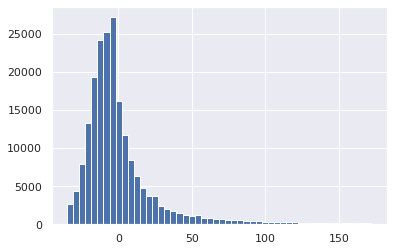

In [48]:
plt.hist(df_test[model1_label], bins=50)

In [78]:
 df_train_predictions = lin_reg.predict(df_train_transformed)

In [70]:
plt.hist(df_train_predictions, bins=50)

NameError: name 'df_train_predictions' is not defined

In [ ]:
from sklearn.model_selection import cross_validate

#scores = cross_validate(lin_reg, df_train_transformed, df_train[model1_label], scoring='neg_root_mean_squared_error', cv=5)

In [48]:
#scores['test_score'].mean()

# ElasticNET regression

In [49]:
from sklearn.model_selection import ShuffleSplit


shuffled_split_train = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)


In [50]:
from sklearn.linear_model import ElasticNet

In [51]:
from sklearn.model_selection import GridSearchCV

eNet = ElasticNet()

grid_search = GridSearchCV(eNet, param_grid = {"max_iter": [1, 5, 10],
                      "alpha": [10, 100],
                      "l1_ratio": np.arange(0.0, 1.0, 0.4)},cv=shuffled_split_train, scoring='neg_mean_squared_error', error_score=np.nan, verbose=2)

In [52]:
'''
from sklearn.model_selection import GridSearchCV

eNet = ElasticNet()

grid_search = GridSearchCV(eNet, param_grid = {"max_iter": [1, 5, 10],
                      "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                      "l1_ratio": np.arange(0.0, 1.0, 0.1)},cv=shuffled_split_train, scoring='neg_mean_squared_error', error_score=np.nan, verbose=2)
'''

'\nfrom sklearn.model_selection import GridSearchCV\n\neNet = ElasticNet()\n\ngrid_search = GridSearchCV(eNet, param_grid = {"max_iter": [1, 5, 10],\n                      "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],\n                      "l1_ratio": np.arange(0.0, 1.0, 0.1)},cv=shuffled_split_train, scoring=\'neg_mean_squared_error\', error_score=np.nan, verbose=2)\n'

In [53]:
if (RECOMPUTE_GRIDSEARCH == True):
    grid_search.fit(df_train_transformed, df_train[model1_label])

In [54]:
if ((EXECUTE_INTERMEDIATE_MODELS == True) and (LOAD_GRID_RESULTS == True)):
    grid_search, df_grid_search_results = save_or_load_search_params(grid_search, 'eNet_20200319')

In [55]:
if ((EXECUTE_INTERMEDIATE_MODELS == True) and (LOAD_GRID_RESULTS == True)):
    df_grid_search_results.sort_values(by='mean_test_score', ascending=False)

In [56]:
np.sqrt(1741.47)

41.73092378560532

=> 41.73092378560532

In [57]:
if ((EXECUTE_INTERMEDIATE_MODELS == True) and (LOAD_GRID_RESULTS == True)):
    grid_search.best_estimator_

In [58]:
if ((EXECUTE_INTERMEDIATE_MODELS == True) and (LOAD_GRID_RESULTS == True)):
    df_test_predictions = grid_search.best_estimator_.predict(df_test_transformed)
    mse = mean_squared_error(df_test[model1_label], df_test_predictions)
    rmse = np.sqrt(mse)
    print(rmse)


In [59]:
if ((EXECUTE_INTERMEDIATE_MODELS == True) and (LOAD_GRID_RESULTS == True)):
    grid_search.best_estimator_.coef_

array([ 3.81842241e-01,  5.38463257e-02,  4.20287224e-02,  5.22019019e-04,
        3.01660130e-01, -5.81861174e-02, -6.72278997e-02, -1.27034969e-02,
       -2.24325259e-04,  4.09514301e-04, -3.70631003e-03, -2.53436510e-03,
       -7.75208542e-04,  9.33417957e-05,  4.17993863e-03, -9.42512871e-04,
       -1.11806550e-03,  1.44798574e-02, -3.13856400e-03,  3.29966151e-03,
        3.99529584e-03, -4.48915797e-03,  1.95911581e-03, -2.36326646e-03,
       -4.08853652e-03,  1.66741438e-03,  5.08260117e-03,  1.27353349e-02,
        9.28815390e-04, -1.23422335e-03,  3.00267997e-03, -1.85353662e-03,
        6.23418838e-03, -1.61411894e-03, -2.91269348e-03, -6.75664468e-04,
        1.69775346e-03,  1.63447325e-02, -2.33087459e-02, -2.59028581e-03,
       -1.74542702e-03, -1.45041347e-04,  6.16849621e-05, -9.03449295e-04,
       -5.89810820e-04, -5.62947068e-03,  9.74750809e-03,  2.35807415e-04,
       -6.16562051e-03,  9.79361758e-04, -9.11503285e-04,  2.40351790e-04,
       -8.00703606e-04,  2.80040048e-02, -1.62362534e-02,  2.32015532e-02,
       -7.01852245e-02,  1.65919140e-02,  7.25363024e-03, -4.83051956e-03,
        1.41858822e-02,  6.85437437e-03, -1.58676117e-02,  4.82723839e-03,
        6.33969777e-03, -2.46758789e-02,  2.42193209e-04, -1.45870754e-04,
        4.15867207e-03, -2.83023087e-03,  7.62388260e-05, -4.24610507e-03,
        5.26083293e-04,  1.47810804e-03, -9.19516190e-03,  8.25254437e-03,
       -5.18481866e-03,  1.03654765e-02,  2.87040417e-03, -1.10418835e-03,
        9.52434223e-05, -2.21408556e-03, -6.79991381e-03,  6.17574698e-03,
       -8.83819104e-04,  1.25073748e-02,  1.17980381e-02, -6.81557286e-04,
        3.04168241e-03, -4.21957706e-03,  3.05120532e-03, -7.89844324e-04,
       -2.93426593e-03, -8.38652464e-04,  1.05935638e-03,  6.74906118e-03,
       -5.14042339e-03, -2.37742304e-03, -4.46900931e-04, -2.72629361e-03,
        9.62469273e-04, -1.57391539e-03, -1.61121536e-05, -5.49546918e-03,
        1.91647269e-02, -4.83097086e-05, -6.78384591e-03,  1.00960720e-03,
       -2.12687675e-03, -2.30717357e-04,  1.28182126e-04])

In [60]:
from sklearn import metrics 
sorted(metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'brier_score_loss',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'v_measure_score']

## Naive approach

### Random value between min and max

In [61]:
y_pred_random = np.random.randint(df['ARR_DELAY'].min(), df['ARR_DELAY'].max(), df_test['ARR_DELAY'].shape)
naive_mse = mean_squared_error(df_test[model1_label], y_pred_random)
naive_rmse = np.sqrt(naive_mse)
naive_rmse

93.62362121815198

### Always mean naive approach

In [49]:
from sklearn import dummy

dum = dummy.DummyRegressor(strategy='mean')

# Entraînement
dum.fit(df_train_transformed, df_train[model1_label])

# Prédiction sur le jeu de test
y_pred_dum = dum.predict(df_test_transformed)

# Evaluate
print("RMSE : {:.2f}".format(np.sqrt(mean_squared_error(df_test[model1_label], y_pred_dum)) ))
print("MAE : {:.2f}".format(np.sqrt(mean_absolute_error(df_test[model1_label], y_pred_dum)) ))


RMSE : 27.57
MAE : 4.21


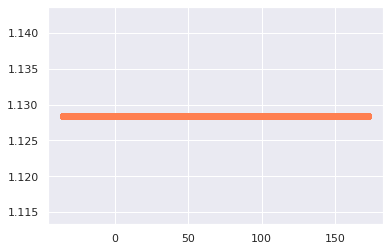

In [63]:
plt.scatter(df_test[model1_label], y_pred_dum, color='coral')

In [64]:
df_test[model1_label]

454845     -8.0
4235029   -17.0
1706111    -6.0
3426078     0.0
932515    -16.0
           ... 
3003726    -2.0
2252284     9.0
537736     -5.0
1738775   -17.0
517545     17.0
Name: ARR_DELAY, Length: 80000, dtype: float64

In [65]:
y_pred_dum

array([1.12847222, 1.12847222, 1.12847222, ..., 1.12847222, 1.12847222,
       1.12847222])

In [66]:
df['ARR_DELAY'].abs().mean()

17.32877625

=> With all samples and 70% most represented features, without StandardScale :  on test set : lin_rmse = 42.17  
=> With all samples and 80% most represented features, without StandardScale :  on test set : lin_rmse = 42.16  
=> With all samples and 80% most represented features, with StandardScale :  on test set : lin_rmse = 42.16

# Random forest

In [67]:
from sklearn.ensemble import RandomForestRegressor

if (EXECUTE_INTERMEDIATE_MODELS == True):
    random_reg = RandomForestRegressor(n_estimators=10, max_depth=2, random_state=42)
    random_reg.fit(df_train_transformed, df_train[model1_label])

In [68]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    df_test_predictions = random_reg.predict(df_test_transformed)
    mse = mean_squared_error(df_test[model1_label], df_test_predictions)
    rmse = np.sqrt(mse)
    print(rmse)

=> 42.373691516139964

# SVM

In [69]:
'''
from sklearn.svm import SVR

svm_reg = SVR(kernel="rbf", verbose=True)
svm_reg.fit(df_train_transformed, df_train[model1_label])
'''

'\nfrom sklearn.svm import SVR\n\nsvm_reg = SVR(kernel="rbf", verbose=True)\nsvm_reg.fit(df_train_transformed, df_train[model1_label])\n'

In [70]:
from sklearn.svm import LinearSVR

svm_reg = LinearSVR(random_state=42, tol=1e-5, verbose=True)

if (EXECUTE_INTERMEDIATE_MODELS == True):
    svm_reg.fit(df_train_transformed, df_train[model1_label])

[LibLinear]

In [71]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    evaluate_model(svm_reg, df_test_transformed, df_test[model1_label])

RMSE : 28.09256195797021


=> RMSE : 43.45607643335432

In [72]:
grid_search_SVR = GridSearchCV(svm_reg, param_grid = {"epsilon": [0, 0.5],
                              "C": [1, 5, 10, 100, 1000],
                              "loss": ['epsilon_insensitive', 'squared_epsilon_insensitive'],},cv=shuffled_split_train, scoring='neg_mean_squared_error', error_score=np.nan, verbose=2)

In [73]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    if (RECOMPUTE_GRIDSEARCH == True):
        grid_search_SVR.fit(df_train_transformed, df_train[model1_label])

=> Warning at execution : /home/francois/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)  

In [74]:
if ((EXECUTE_INTERMEDIATE_MODELS == True) and (LOAD_GRID_RESULTS == True)):
    grid_search_SVR, df_grid_search_results = save_or_load_search_params(grid_search_SVR, 'LinearSVR_20200319')

In [75]:
if ((EXECUTE_INTERMEDIATE_MODELS == True) and (LOAD_GRID_RESULTS == True)):
    df_grid_search_results.sort_values(by='mean_test_score', ascending=False)

In [76]:
if ((EXECUTE_INTERMEDIATE_MODELS == True) and (LOAD_GRID_RESULTS == True)):
    np.sqrt(1709.197402)

In [77]:
if ((EXECUTE_INTERMEDIATE_MODELS == True) and (LOAD_GRID_RESULTS == True)):
    grid_search_SVR.best_estimator_

In [78]:
if ((EXECUTE_INTERMEDIATE_MODELS == True) and (LOAD_GRID_RESULTS == True)):
    evaluate_model(grid_search_SVR.best_estimator_, df_test_transformed, df_test[model1_label])

=> Best estimator :  inearSVR(C=1, dual=True, epsilon=0, fit_intercept=True, intercept_scaling=1.0,
          loss='squared_epsilon_insensitive', max_iter=1000, random_state=0,
          tol=1e-05, verbose=True)  

=> RMSE : 42.16

# Polynomial features + linear regression

In [79]:
df_train_transformed

<720000x113 sparse matrix of type '<class 'numpy.float64'>'
	with 8640000 stored elements in Compressed Sparse Row format>

In [80]:
poly = ColumnTransformer([
                                ('poly', PolynomialFeatures(degree=2), [0, 1, 2, 3, 4, 5, 6])     
                                ], remainder='passthrough', sparse_threshold=1)

#poly.fit(df_train_transformed, df_train[model1_label])
#poly.fit(df_train_transformed)

In [81]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    df_train_transformed = poly.fit_transform(df_train_transformed)
    df_test_transformed = poly.transform(df_test_transformed)

In [82]:
df_train_transformed.shape

(720000, 142)

In [83]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    lin_reg = LinearRegression()
    lin_reg.fit(df_train_transformed, df_train[model1_label])

In [84]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    evaluate_model(lin_reg, df_test_transformed, df_test[model1_label])

RMSE : 26.94101675082222


=> 42.11719088178065

# Polynomial features + random forest

In [85]:
from sklearn.ensemble import RandomForestRegressor

if (EXECUTE_INTERMEDIATE_MODELS == True):
    random_reg = RandomForestRegressor(n_estimators=10, max_depth=2, random_state=42)
    random_reg.fit(df_train_transformed, df_train[model1_label])

In [86]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    df_test_predictions = random_reg.predict(df_test_transformed)
    evaluate_model(random_reg, df_test_transformed, df_test[model1_label])

RMSE : 27.225161548914524


In [87]:
#evaluate_model(polynomial_reg, df_test_transformed, df_test[model1_label])

# New try with group by + mean + sort encoding of categorical features
With preparation_pipeline_meansort instead of preparation_pipeline

In [254]:
if (DATA_LOADED == True):
    del df
    del df_train
    del df_test
    del df_train_transformed
    del df_test_transformed

In [255]:
df = load_data()

In [256]:
all_features, model1_features, model1_label, quantitative_features, qualitative_features = identify_features(df)

Quantitative features : ['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'DISTANCE', 'CRS_ELAPSED_TIME', 'ARR_DELAY', 'DEP_DELAY', 'TAXI_OUT', 'NBFLIGHTS_FORDAYHOUR_FORAIRPORT', 'NBFLIGHTS_FORDAY_FORAIRPORT'] 

Qualitative features : ['ORIGIN', 'CRS_DEP_TIME', 'UNIQUE_CARRIER', 'DEST', 'CRS_ARR_TIME', 'TAIL_NUM'] 



In [257]:
df, df_train, df_test = custom_train_test_split_sample_random(df)

In [258]:
#df_train_transformed = preparation_pipeline_meansort_standardscale.fit_transform(df_train, categoricalfeatures_1hotencoder__categorical_features_totransform=None)

In [259]:
df_train_transformed = preparation_pipeline_meansort_stdscale.fit_transform(df_train)
df_test_transformed = preparation_pipeline_meansort_stdscale.transform(df_test)
DATA_LOADED = True
df_test_transformed.shape

Converting feature CRS_DEP_TIME

Converting feature CRS_ARR_TIME

Fit data
Fitting feature ORIGIN
Fitting feature UNIQUE_CARRIER
Fitting feature DEST
Encode categorical features...
Encoding feature ORIGIN ...
Encoding feature UNIQUE_CARRIER ...
Encoding feature DEST ...
Features selected (in order): Index(['CRS_ARR_TIME', 'CRS_DEP_TIME', 'CRS_ELAPSED_TIME', 'DAY_OF_MONTH',
       'DAY_OF_WEEK', 'DEST', 'DISTANCE', 'MONTH',
       'NBFLIGHTS_FORDAYHOUR_FORAIRPORT', 'NBFLIGHTS_FORDAY_FORAIRPORT',
       'ORIGIN', 'UNIQUE_CARRIER'],
      dtype='object')
Fit Std scale multiple
Transform Std scale multiple
Converting feature CRS_DEP_TIME

Converting feature CRS_ARR_TIME

Encode categorical features...
Encoding feature ORIGIN ...
Encoding feature UNIQUE_CARRIER ...
Encoding feature DEST ...
Features selected (in order): Index(['CRS_ARR_TIME', 'CRS_DEP_TIME', 'CRS_ELAPSED_TIME', 'DAY_OF_MONTH',
       'DAY_OF_WEEK', 'DEST', 'DISTANCE', 'MONTH',
       'NBFLIGHTS_FORDAYHOUR_FORAIRPORT', 'NBFL

(80000, 12)

In [260]:
df_train

,ORIGIN,CRS_DEP_TIME,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,DEST,CRS_ARR_TIME,DISTANCE,CRS_ELAPSED_TIME,ARR_DELAY,DEP_DELAY,TAXI_OUT,TAIL_NUM,NBFLIGHTS_FORDAY_FORAIRPORT,NBFLIGHTS_FORDAYHOUR_FORAIRPORT
714829,191,1280,7,9,6,0,293,1421,762.0,141.0,-11.0,-5.0,15.0,N371NW,944,59
4562153,249,987,10,31,1,3,54,1259,1009.0,152.0,-13.0,-3.0,10.0,N76523,381,29
1138997,285,1315,6,20,1,6,279,1400,337.0,85.0,-15.0,-3.0,8.0,N345SA,519,22
2391335,268,540,3,20,7,0,43,693,746.0,153.0,-17.0,-3.0,17.0,N995AT,406,27
1008174,191,845,6,26,7,0,273,945,481.0,100.0,71.0,-2.0,95.0,N953DL,1100,67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4118288,196,1345,1,26,2,6,179,1415,283.0,70.0,19.0,32.0,9.0,N212WN,234,18
4495725,244,536,10,23,7,5,293,738,764.0,142.0,-7.0,-3.0,9.0,N722EV,150,15
2695460,268,895,3,4,5,3,279,1084,2454.0,369.0,4.0,4.0,14.0,N14107,415,17
2837691,220,1090,2,23,2,11,145,1184,473.0,94.0,18.0,3.0,29.0,N641NK,195,19


In [261]:
df_train_transformed

,CRS_ARR_TIME,CRS_DEP_TIME,CRS_ELAPSED_TIME,DAY_OF_MONTH,DAY_OF_WEEK,DEST,DISTANCE,MONTH,NBFLIGHTS_FORDAYHOUR_FORAIRPORT,NBFLIGHTS_FORDAY_FORAIRPORT,ORIGIN,UNIQUE_CARRIER
714829,1.667183,1.602625,-0.042363,-0.775664,1.043483,1.599834,-0.130074,0.144318,1.747999,1.995824,-0.426408,-1.623413
4562153,1.143526,0.606955,0.103512,1.723050,-1.476643,-1.371020,0.273149,1.025155,0.310498,0.125953,0.522919,-0.582087
1138997,1.599301,1.721562,-0.785003,0.473693,-1.476643,1.425809,-0.823879,-0.149295,-0.024919,0.584287,1.112156,0.459239
2391335,-0.686043,-0.912036,0.116774,0.473693,1.547509,-1.507753,-0.156194,-1.030133,0.214664,0.208984,0.833905,-1.623413
1008174,0.128535,0.124412,-0.586082,1.155161,1.547509,1.351227,-0.588802,-0.149295,2.131332,2.513942,-0.426408,-1.623413
...,...,...,...,...,...,...,...,...,...,...,...,...
4118288,1.647788,1.823508,-0.983925,1.155161,-0.972617,0.182774,-0.912033,-1.617358,-0.216586,-0.362273,-0.344569,0.459239
4495725,-0.540582,-0.925629,-0.029102,0.814427,1.547509,1.599834,-0.126809,1.025155,-0.360336,-0.641260,0.441081,0.112130
2695460,0.577846,0.294322,2.981242,-1.343554,0.539458,1.425809,2.632085,-1.030133,-0.264503,0.238876,0.833905,-0.582087
2837691,0.901092,0.956969,-0.665650,0.814427,-0.972617,-0.239858,-0.601861,-1.323746,-0.168669,-0.491803,0.048256,2.194782


In [171]:
df_train_transformed.shape[1]

12

In [172]:
len(MODEL1_GOUPBYMEAN_FEATURES)

12

In [173]:
df_train_transformed.shape[1]

12

In [226]:
df_train[df_train['CRS_DEP_TIME'] < 200]

,ORIGIN,CRS_DEP_TIME,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,DEST,CRS_ARR_TIME,DISTANCE,CRS_ELAPSED_TIME,ARR_DELAY,DEP_DELAY,TAXI_OUT,TAIL_NUM,NBFLIGHTS_FORDAY_FORAIRPORT,NBFLIGHTS_FORDAYHOUR_FORAIRPORT
2065732,256,55,12,27,2,7,105,421,1999.0,246.0,6.0,-1.0,23.0,N109AA,488,12
4772,295,15,9,12,1,7,234,505,2342.0,310.0,1.0,7.0,23.0,N3BMAA,613,8
5111201,256,75,8,12,5,7,86,495,1773.0,240.0,9.0,-1.0,13.0,N154UW,465,1
4842743,249,155,11,25,5,10,243,330,1176.0,175.0,-22.0,-3.0,6.0,N625NK,2,1
2789224,64,40,3,27,7,1,121,325,1542.0,225.0,-13.0,-2.0,17.0,N323AS,73,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625993,282,60,7,4,1,7,148,522,2176.0,282.0,-8.0,-1.0,16.0,N661AW,362,6
365985,64,45,9,16,5,0,108,307,1448.0,202.0,-17.0,-2.0,10.0,N3730B,46,4
3580344,282,58,4,20,3,7,155,345,1055.0,167.0,-24.0,-5.0,17.0,N870AA,373,9
642084,267,45,7,11,1,7,155,358,1345.0,193.0,-4.0,15.0,12.0,N3JXAA,45,1


In [227]:
df['CRS_DEP_TIME']

2223958    1551
4098092    1020
2639568    0515
17417      2010
410962     0835
           ... 
3964180    1510
2163350    1515
3954652    1030
3482781    2043
420053     1455
Name: CRS_DEP_TIME, Length: 800000, dtype: object

In [239]:
df_train['CRS_DEP_TIME']

1802104     820
5353235     946
1778352     750
4923518     755
2470767     645
           ... 
2964919     597
2348397    1177
231953      815
173151      495
1616932    1190
Name: CRS_DEP_TIME, Length: 720000, dtype: int64

(array([  682.,  1310.,   493.,   327.,   149.,    81.,   118.,    53.,
           40.,    30.,  3616.,  9022., 24025., 20330., 27258., 21415.,
        20658., 22134., 23471., 19065., 20933., 22908., 21736., 23285.,
        17209., 21817., 20653., 20469., 22974., 17500., 19833., 23004.,
        21436., 16895., 20648., 21689., 23697., 19613., 19379., 19726.,
        18876., 19551., 17044., 12926., 10109., 10246., 10543.,  5100.,
         2884.,  3040.]),
 array([1.00000e+00, 2.97600e+01, 5.85200e+01, 8.72800e+01, 1.16040e+02,
        1.44800e+02, 1.73560e+02, 2.02320e+02, 2.31080e+02, 2.59840e+02,
        2.88600e+02, 3.17360e+02, 3.46120e+02, 3.74880e+02, 4.03640e+02,
        4.32400e+02, 4.61160e+02, 4.89920e+02, 5.18680e+02, 5.47440e+02,
        5.76200e+02, 6.04960e+02, 6.33720e+02, 6.62480e+02, 6.91240e+02,
        7.20000e+02, 7.48760e+02, 7.77520e+02, 8.06280e+02, 8.35040e+02,
        8.63800e+02, 8.92560e+02, 9.21320e+02, 9.50080e+02, 9.78840e+02,
        1.00760e+03, 1.03636e+0

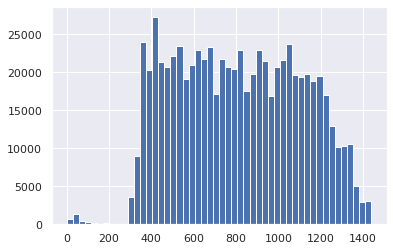

In [224]:
plt.hist(df_train['CRS_DEP_TIME'], bins=50)

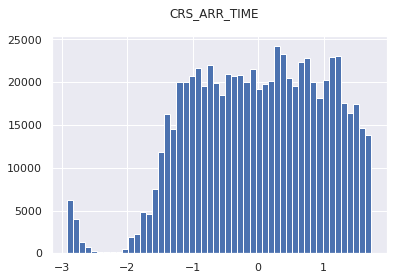

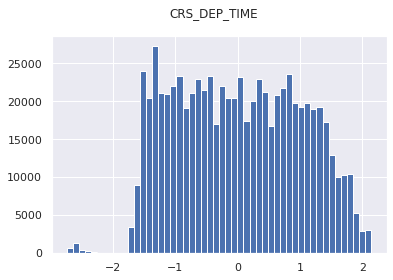

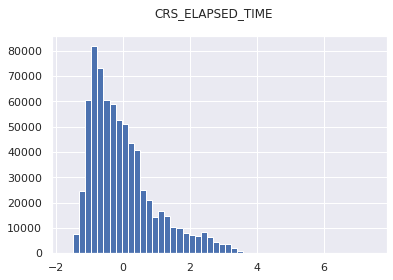

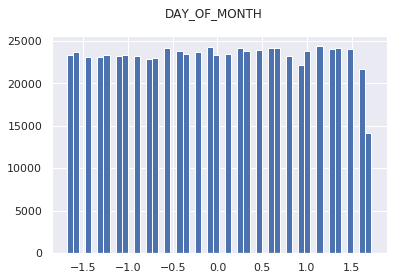

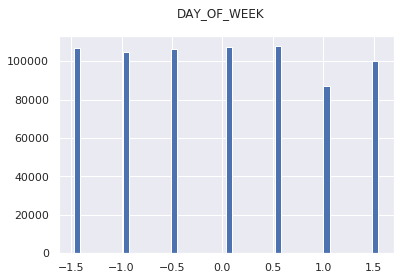

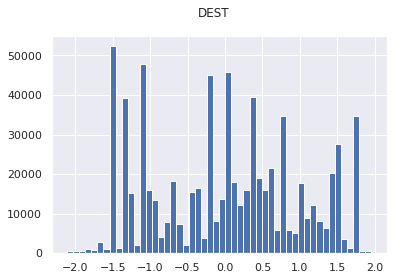

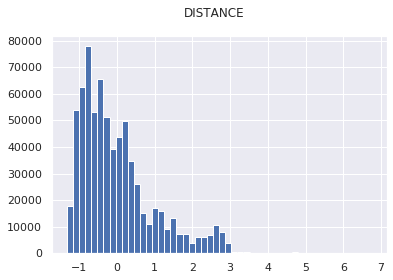

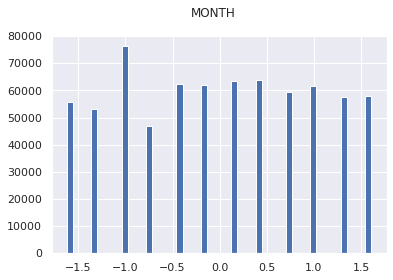

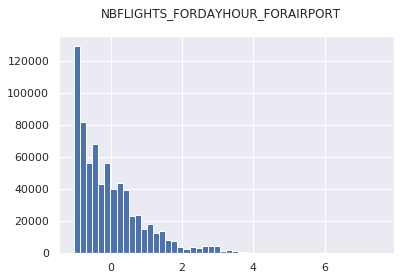

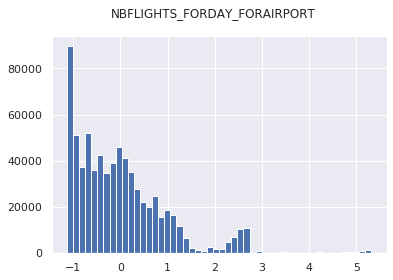

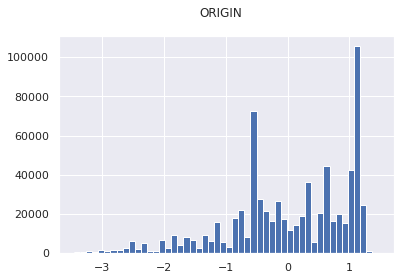

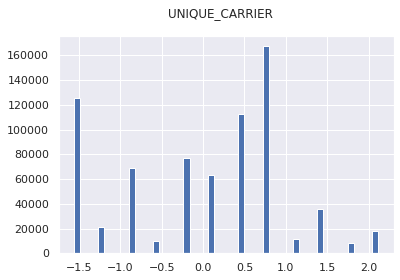

In [174]:
for feat_name in df_train_transformed.columns:
    fig = plt.figure()
    fig.suptitle(feat_name)
    plt.hist(df_train_transformed[feat_name], bins=50)
    plt.plot()

In [175]:
abs(df_train['ARR_DELAY'].min())

35.0

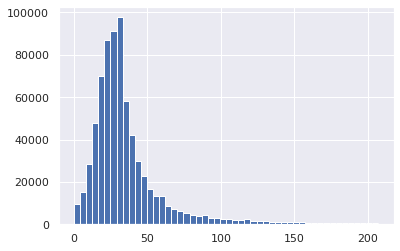

In [176]:
(df_train['ARR_DELAY'] + abs(df_train['ARR_DELAY'].min())).hist(bins=50)

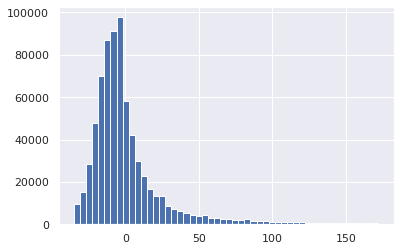

In [177]:
df_train['ARR_DELAY'].hist(bins=50)

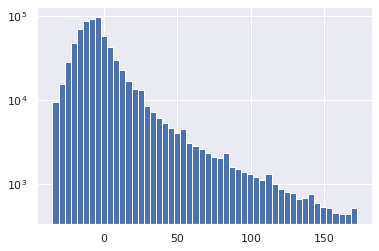

In [178]:
df_train['ARR_DELAY'].hist(bins=50, log=True)

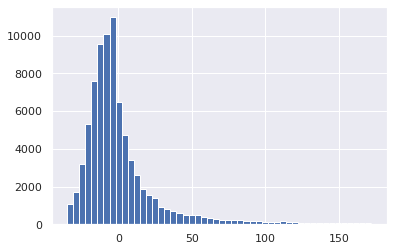

In [179]:
df_test['ARR_DELAY'].hist(bins=50)

In [199]:
df_train_labels = df_train[model1_label]

In [200]:
df_train_labels_positive = df_train[model1_label] + abs(df_train[model1_label].min()) + 1

In [201]:
pt = preprocessing.PowerTransformer(method='box-cox', standardize=False)

In [202]:
df_train_labels_positive_log = pt.fit_transform(df_train_labels_positive.to_numpy().reshape(-1, 1))

In [203]:
#df_train_labels_positive_log_inverse = pt.inverse_transform(df_train_labels_positive_log) -1 - abs(df_train['ARR_DELAY'].min())

## With scaling of labels

In [204]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()

lin_reg.fit(df_train_transformed, df_train_labels_positive_log)

df_train_predictions_positive_log = lin_reg.predict(df_train_transformed)
df_train_predictions_positive = pt.inverse_transform(df_train_predictions_positive_log)
df_train_predictions = df_train_predictions_positive -1 - abs(df_train['ARR_DELAY'].min())

mse = mean_squared_error(df_labels, df_train_predictions)
rmse = np.sqrt(mse)
print(f'RMSE on training set : {rmse}')

RMSE on training set : 28.448808804455727


=> Log scaling of labels does not seem to make a difference. Result is even worse  (28.4 instead of 27)

(array([1.0000e+00, 1.0000e+00, 1.0000e+00, 9.0000e+00, 1.5000e+01,
        2.4000e+01, 4.8000e+01, 1.0300e+02, 1.5000e+02, 2.9000e+02,
        5.2600e+02, 7.3100e+02, 1.3190e+03, 2.1780e+03, 3.3600e+03,
        4.9780e+03, 6.8810e+03, 9.4190e+03, 1.1810e+04, 1.4628e+04,
        1.7640e+04, 2.1265e+04, 2.5321e+04, 2.9755e+04, 3.2909e+04,
        3.6460e+04, 3.9036e+04, 4.1468e+04, 4.3152e+04, 4.3463e+04,
        4.3163e+04, 4.2016e+04, 4.1426e+04, 3.9119e+04, 3.5036e+04,
        3.0309e+04, 2.5479e+04, 2.0717e+04, 1.7095e+04, 1.3392e+04,
        1.0314e+04, 7.0420e+03, 4.3600e+03, 2.2230e+03, 8.6900e+02,
        3.2000e+02, 9.7000e+01, 5.6000e+01, 2.1000e+01, 5.0000e+00]),
 array([3.1348906 , 3.1674596 , 3.20002861, 3.23259761, 3.26516662,
        3.29773562, 3.33030462, 3.36287363, 3.39544263, 3.42801164,
        3.46058064, 3.49314965, 3.52571865, 3.55828765, 3.59085666,
        3.62342566, 3.65599467, 3.68856367, 3.72113268, 3.75370168,
        3.78627068, 3.81883969, 3.85140869, 3.

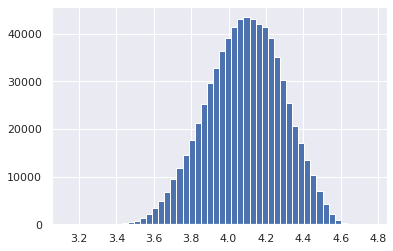

In [205]:
plt.hist(df_train_predictions_positive_log, bins=50)

(array([1.0000e+00, 6.0000e+00, 2.4000e+01, 4.5000e+01, 1.4100e+02,
        3.0600e+02, 6.7900e+02, 1.2070e+03, 2.5050e+03, 4.2920e+03,
        6.8870e+03, 1.0010e+04, 1.3436e+04, 1.6786e+04, 2.0341e+04,
        2.4636e+04, 2.9216e+04, 3.3043e+04, 3.6269e+04, 3.8076e+04,
        4.0344e+04, 4.1535e+04, 4.1429e+04, 4.0927e+04, 3.9493e+04,
        3.8013e+04, 3.6534e+04, 3.4161e+04, 3.0465e+04, 2.6663e+04,
        2.2920e+04, 1.9263e+04, 1.6015e+04, 1.3540e+04, 1.0980e+04,
        9.0630e+03, 7.0580e+03, 5.1720e+03, 3.5330e+03, 2.3890e+03,
        1.2760e+03, 6.7300e+02, 3.2300e+02, 1.5900e+02, 7.2000e+01,
        3.7000e+01, 3.5000e+01, 1.4000e+01, 5.0000e+00, 3.0000e+00]),
 array([-20.65182276, -19.96703136, -19.28223997, -18.59744857,
        -17.91265718, -17.22786578, -16.54307438, -15.85828299,
        -15.17349159, -14.4887002 , -13.8039088 , -13.11911741,
        -12.43432601, -11.74953462, -11.06474322, -10.37995182,
         -9.69516043,  -9.01036903,  -8.32557764,  -7.64078624

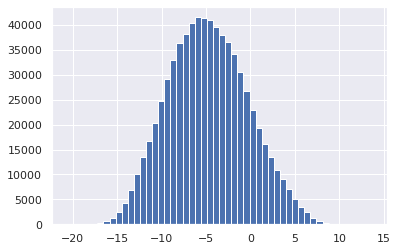

In [206]:
plt.hist(df_train_predictions, bins=50)

## Without scaling of labels

In [228]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()

lin_reg.fit(df_train_transformed, df_train[model1_label])

df_test_predictions = lin_reg.predict(df_test_transformed)

print("Evaluation on test set :")
evaluate_model(lin_reg, df_test_transformed, df_test[model1_label])

print('\n')

print("Evaluation on training set :")
evaluate_model(lin_reg, df_train_transformed, df_train[model1_label])

Evaluation on test set :
RMSE : 27.355237519961292


Evaluation on training set :
RMSE : 27.34320391431211


=> Evaluation on test set :  
RMSE : 27.079383490783385  

  
Evaluation on training set :  
RMSE : 27.07763523727725  



En ayant enlevé  :  'NBFLIGHTS_FORDAY_FORAIRPORT',  
       'ORIGIN', 'UNIQUE_CARRIER' :  

Evaluation on test set :  
RMSE : 27.19385016531133  

Remettre juste 'NBFLIGHTS_FORDAY_FORAIRPORT' n'y change rien  
En remettant ORIGIN => passage à 27.14  
En remettant UNIQUE_CARRIER => passage à 27.08

(array([1.0000e+00, 6.0000e+00, 2.4000e+01, 4.5000e+01, 1.4100e+02,
        3.0600e+02, 6.7900e+02, 1.2070e+03, 2.5050e+03, 4.2920e+03,
        6.8870e+03, 1.0010e+04, 1.3436e+04, 1.6786e+04, 2.0341e+04,
        2.4636e+04, 2.9216e+04, 3.3043e+04, 3.6269e+04, 3.8076e+04,
        4.0344e+04, 4.1535e+04, 4.1429e+04, 4.0927e+04, 3.9493e+04,
        3.8013e+04, 3.6534e+04, 3.4161e+04, 3.0465e+04, 2.6663e+04,
        2.2920e+04, 1.9263e+04, 1.6015e+04, 1.3540e+04, 1.0980e+04,
        9.0630e+03, 7.0580e+03, 5.1720e+03, 3.5330e+03, 2.3890e+03,
        1.2760e+03, 6.7300e+02, 3.2300e+02, 1.5900e+02, 7.2000e+01,
        3.7000e+01, 3.5000e+01, 1.4000e+01, 5.0000e+00, 3.0000e+00]),
 array([-20.65182276, -19.96703136, -19.28223997, -18.59744857,
        -17.91265718, -17.22786578, -16.54307438, -15.85828299,
        -15.17349159, -14.4887002 , -13.8039088 , -13.11911741,
        -12.43432601, -11.74953462, -11.06474322, -10.37995182,
         -9.69516043,  -9.01036903,  -8.32557764,  -7.64078624

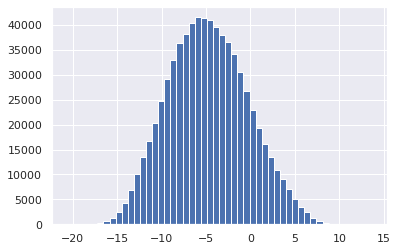

In [192]:
plt.hist(df_train_predictions, bins=50)

=> RMSE on training set : 41.35267146874754 (close to RMSE on test set => under fitting)

(array([5.000e+00, 2.000e+00, 2.300e+01, 3.000e+01, 4.200e+01, 9.900e+01,
        1.720e+02, 2.320e+02, 3.460e+02, 3.880e+02, 5.110e+02, 6.440e+02,
        7.500e+02, 1.013e+03, 1.216e+03, 1.399e+03, 1.833e+03, 2.079e+03,
        2.298e+03, 2.460e+03, 2.825e+03, 3.128e+03, 3.311e+03, 3.490e+03,
        3.638e+03, 3.736e+03, 3.963e+03, 3.994e+03, 3.805e+03, 3.680e+03,
        3.597e+03, 3.333e+03, 3.293e+03, 3.059e+03, 2.849e+03, 2.375e+03,
        2.129e+03, 1.753e+03, 1.587e+03, 1.397e+03, 1.183e+03, 8.480e+02,
        6.110e+02, 4.240e+02, 2.280e+02, 1.100e+02, 6.200e+01, 2.900e+01,
        1.400e+01, 7.000e+00]),
 array([-16.95554682, -16.28544992, -15.61535301, -14.94525611,
        -14.2751592 , -13.6050623 , -12.93496539, -12.26486849,
        -11.59477158, -10.92467467, -10.25457777,  -9.58448086,
         -8.91438396,  -8.24428705,  -7.57419015,  -6.90409324,
         -6.23399634,  -5.56389943,  -4.89380253,  -4.22370562,
         -3.55360871,  -2.88351181,  -2.2134149 ,  -1.54

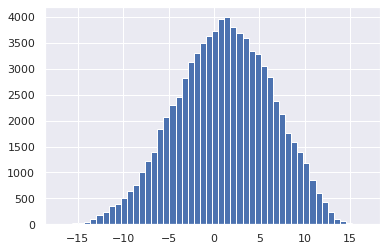

In [191]:
plt.hist(df_test_predictions, bins=50)

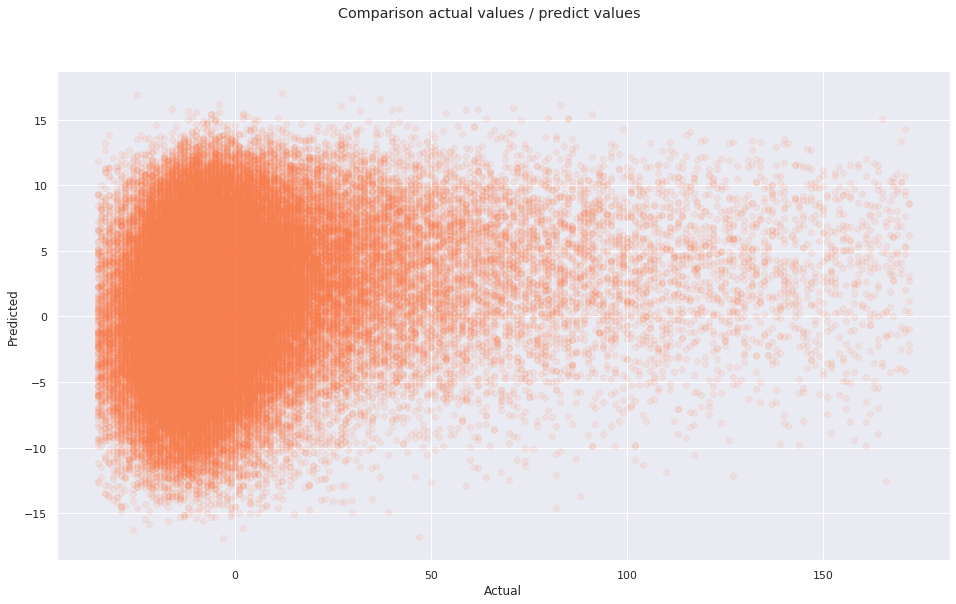

In [200]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison actual values / predict values on test set')
    plt.ylabel("Predicted")
    plt.xlabel("Actual")
    plt.scatter(df_test[model1_label], df_test_predictions, color='coral', alpha=0.1)

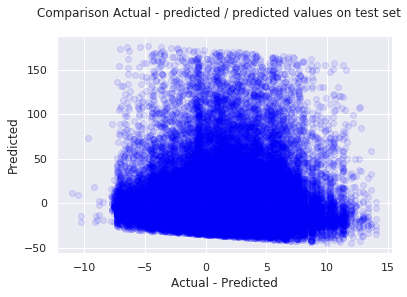

In [230]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison Actual - predicted / predicted values on test set')
    plt.xlabel("Predicted")
    plt.ylabel("Actual - Predicted")
    plt.scatter(df_test[model1_label] - df_test_predictions, df_test_predictions, color='blue', alpha=0.1)

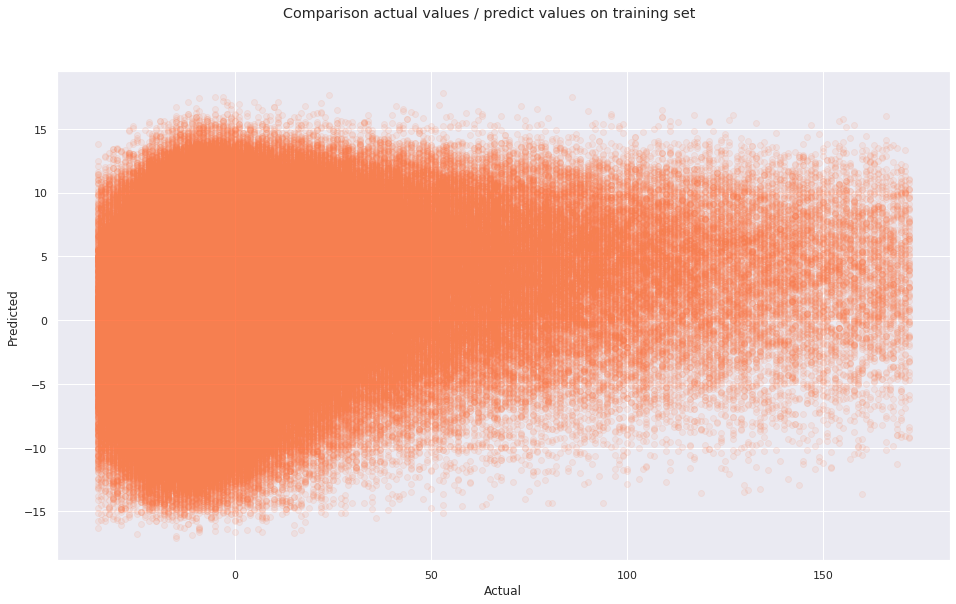

In [201]:
df_train_predictions = lin_reg.predict(df_train_transformed)

if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison actual values / predict values on training set')
    plt.ylabel("Predicted")
    plt.xlabel("Actual")
    plt.scatter(df_train[model1_label], df_train_predictions, color='coral', alpha=0.1)

In [141]:
lin_reg.coef_

array([ 2.70039537e+00,  4.25952747e-01,  3.16829484e-01,  4.66270732e+00,
       -5.17679527e+00,  2.32738490e+00,  1.25119873e+00,  1.36515516e-03,
       -4.26802502e-01,  1.91351639e-03])

In [202]:
# Feature importances :
(abs(lin_reg.coef_) / (abs(lin_reg.coef_).sum()))

array([1.66207419e-01, 2.49993254e-02, 2.04759987e-02, 1.90822897e-01,
       2.32357637e-01, 9.80429872e-02, 7.06016861e-02, 9.36629938e-04,
       7.16255762e-04, 8.76662202e-02, 1.07137714e-01, 3.52286879e-05])

Features < 0.01 importance :   
'NBFLIGHTS_FORDAY_FORAIRPORT',
       'ORIGIN', 'UNIQUE_CARRIER'
       
=> NBFLIGHTS_FORDAY_FORAIRPORT removed from MODEL1_GOUPBYMEAN_FEATURES  
=> ORIGIN and UNIQUE_CARRIER kept   

In [ ]:
df_train_transformed.shape

In [ ]:
df_train_transformed

In [ ]:
plot_learning_curves(lin_reg, df_train_transformed, df_test_transformed, df_train[model1_label], df_test[model1_label], LEARNING_CURVE_STEP_SIZE)

## Polynomial regression degree 2

In [103]:
poly = PolynomialFeatures(degree=2)
poly.fit(df_train_transformed)
df_train_transformed = poly.transform(df_train_transformed)
df_test_transformed = poly.transform(df_test_transformed)

In [104]:
poly.n_output_features_

91

In [105]:
df_train_transformed.shape

(720000, 91)

In [106]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    lin_reg = LinearRegression()
    lin_reg.fit(df_train_transformed, df_train[model1_label])

In [107]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    evaluate_model(lin_reg, df_test_transformed, df_test[model1_label])

RMSE : 26.962742760959262


=> RMSE on test set : RMSE : 42.12678182212536

In [108]:
evaluate_model(lin_reg, df_train_transformed, df_train[model1_label])

RMSE : 26.961186529991995


=> RMSE on training set : 41.26055791264713

Calculating learning curve for 73 iterations


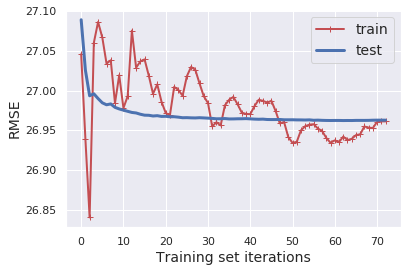

In [109]:
plot_learning_curves(lin_reg, df_train_transformed, df_test_transformed, df_train[model1_label], df_test[model1_label], LEARNING_CURVE_STEP_SIZE)

In [110]:
# Feature importances :
(abs(lin_reg.coef_) / (abs(lin_reg.coef_).sum()))

array([4.53879449e-15, 2.48049767e-02, 2.21778464e-03, 5.74837030e-03,
       2.47499342e-03, 2.96015980e-02, 1.19370191e-01, 1.12684155e-01,
       8.38457464e-03, 1.35996047e-02, 1.71903192e-04, 3.89596225e-04,
       1.29284527e-02, 2.11341123e-02, 2.91737995e-04, 4.38283462e-03,
       2.93207926e-03, 1.25077331e-02, 3.32209266e-02, 2.50021828e-02,
       4.24386595e-03, 3.23064264e-03, 4.93615444e-05, 5.70045701e-05,
       3.29635761e-03, 1.08563688e-02, 7.47349559e-03, 2.61165485e-03,
       8.63307401e-04, 2.90245122e-02, 3.14528208e-02, 5.78385734e-03,
       4.22040474e-03, 4.38680165e-05, 8.83620798e-06, 1.35074100e-03,
       5.33727790e-03, 1.27756672e-03, 4.97968670e-05, 1.50547845e-03,
       1.47804084e-03, 1.40270744e-03, 2.65665684e-04, 1.26642448e-05,
       2.21221212e-05, 6.64153097e-04, 6.97085328e-03, 2.35500661e-04,
       1.37526659e-02, 1.31937812e-02, 4.67518290e-03, 5.10116362e-03,
       5.51233170e-06, 2.96227839e-06, 5.86193391e-04, 2.89949500e-03,
      

In [111]:
df_train_transformed[:,0].shape

(720000,)

## Polynomial regression univariate, and higher degree

### Degree 8

In [208]:
if (DATA_LOADED == True):
    del df
    del df_train
    del df_test
    del df_train_transformed
    del df_test_transformed

In [209]:
df = load_data()

In [210]:
all_features, model1_features, model1_label, quantitative_features, qualitative_features = identify_features(df)

Quantitative features : ['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'DISTANCE', 'CRS_ELAPSED_TIME', 'ARR_DELAY', 'DEP_DELAY', 'TAXI_OUT', 'NBFLIGHTS_FORDAYHOUR_FORAIRPORT', 'NBFLIGHTS_FORDAY_FORAIRPORT'] 

Qualitative features : ['ORIGIN', 'CRS_DEP_TIME', 'UNIQUE_CARRIER', 'DEST', 'CRS_ARR_TIME', 'TAIL_NUM'] 



In [211]:
df, df_train, df_test = custom_train_test_split_sample(df)

In [212]:
df_train_transformed = preparation_pipeline_meansort.fit_transform(df_train, categoricalfeatures_1hotencoder__categorical_features_totransform=None)
df_train_transformed = prediction_pipeline_without_sparse.fit_transform(df_train_transformed)

df_test_transformed = preparation_pipeline_meansort.transform(df_test)
df_test_transformed = prediction_pipeline_without_sparse.transform(df_test_transformed)
DATA_LOADED = True
df_test_transformed.shape

Converting feature CRS_DEP_TIME

Converting feature CRS_ARR_TIME

Fit data
Fitting feature ORIGIN
Fitting feature UNIQUE_CARRIER
Fitting feature DEST
Encode categorical features...
Encoding feature ORIGIN ...
Encoding feature UNIQUE_CARRIER ...
Encoding feature DEST ...
Fit data
!! categorical_features_totransformNone
Features selected (in order): Index(['CRS_ARR_TIME', 'CRS_DEP_TIME', 'CRS_ELAPSED_TIME', 'DAY_OF_MONTH',
       'DAY_OF_WEEK', 'DEST', 'DISTANCE', 'MONTH',
       'NBFLIGHTS_FORDAYHOUR_FORAIRPORT', 'NBFLIGHTS_FORDAY_FORAIRPORT',
       'ORIGIN', 'UNIQUE_CARRIER'],
      dtype='object')
Converting feature CRS_DEP_TIME

Converting feature CRS_ARR_TIME

Encode categorical features...
Encoding feature ORIGIN ...
Encoding feature UNIQUE_CARRIER ...
Encoding feature DEST ...
Features selected (in order): Index(['CRS_ARR_TIME', 'CRS_DEP_TIME', 'CRS_ELAPSED_TIME', 'DAY_OF_MONTH',
       'DAY_OF_WEEK', 'DEST', 'DISTANCE', 'MONTH',
       'NBFLIGHTS_FORDAYHOUR_FORAIRPORT', 'NBFLIGH

(80000, 12)

In [213]:
nb_instances = df_train_transformed.shape[0]

In [214]:
poly = PolynomialFeaturesUnivariateAdder(n_degrees = 8)

In [215]:
df_train_transformed = poly.fit_transform(df_train_transformed)
df_test_transformed = poly.fit_transform(df_test_transformed)

Adding polynomial features


Adding polynomial features


In [216]:
lin_reg = LinearRegression()

lin_reg.fit(df_train_transformed, df_train[model1_label])

df_test_predictions = lin_reg.predict(df_test_transformed)

print("Evaluation on test set :")
evaluate_model(lin_reg, df_test_transformed, df_test[model1_label])

print('\n')

print("Evaluation on training set :")
evaluate_model(lin_reg, df_train_transformed, df_train[model1_label])

Evaluation on test set :
RMSE : 27.355237519961292


Evaluation on training set :
RMSE : 27.34320391431211


Calculating learning curve for 15 iterations


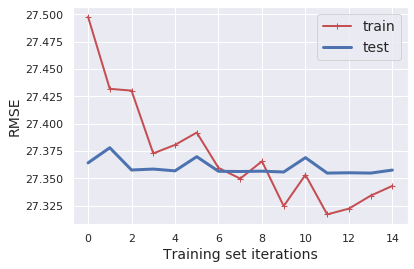

In [221]:
plot_learning_curves(lin_reg, df_train_transformed, df_test_transformed, df_train[model1_label], df_test[model1_label], LEARNING_CURVE_STEP_SIZE)

### Degree 4

In [127]:
del df
del df_train
del df_test
del df_train_transformed
del df_test_transformed

In [128]:
df, df_train, df_test, df_train_transformed, df_test_transformed = reset_data()

Quantitative features : ['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'DISTANCE', 'CRS_ELAPSED_TIME', 'ARR_DELAY', 'DEP_DELAY', 'TAXI_OUT', 'NBFLIGHTS_FORDAYHOUR_FORAIRPORT', 'NBFLIGHTS_FORDAY_FORAIRPORT'] 

Qualitative features : ['ORIGIN', 'CRS_DEP_TIME', 'UNIQUE_CARRIER', 'DEST', 'CRS_ARR_TIME', 'TAIL_NUM'] 

Converting feature CRS_DEP_TIME

Converting feature CRS_ARR_TIME

Fit data
Fitting feature ORIGIN
Fitting feature UNIQUE_CARRIER
Fitting feature DEST
Encode categorical features...
Encoding feature ORIGIN ...
Encoding feature UNIQUE_CARRIER ...
Encoding feature DEST ...
Fit data
!! categorical_features_totransformNone
Features selected (in order): Index(['CRS_ARR_TIME', 'CRS_DEP_TIME', 'CRS_ELAPSED_TIME', 'DAY_OF_MONTH',
       'DAY_OF_WEEK', 'DEST', 'DISTANCE', 'MONTH',
       'NBFLIGHTS_FORDAYHOUR_FORAIRPORT', 'NBFLIGHTS_FORDAY_FORAIRPORT',
       'ORIGIN', 'UNIQUE_CARRIER'],
      dtype='object')
Converting feature CRS_DEP_TIME

Converting feature CRS_ARR_TIME

Encode categorical

In [129]:
df_train_transformed

array([[ 4.04563321e-02, -4.47018985e-01,  5.89247464e-01, ...,
         1.77000000e+02,  2.65000000e+02,  7.00000000e+00],
       [ 4.68399791e-01,  4.33873299e-01,  2.15283807e-02, ...,
         2.01000000e+02,  2.31000000e+02,  4.00000000e+00],
       [-1.97290034e-01, -4.47018985e-01, -7.73278336e-01, ...,
         2.18000000e+02,  2.95000000e+02,  7.00000000e+00],
       ...,
       [ 2.34744488e-02,  7.27504060e-01,  2.48616014e-01, ...,
         2.78000000e+02,  1.75000000e+02,  1.10000000e+01],
       [-1.06336608e+00,  7.27504060e-01,  1.27051036e+00, ...,
         2.53000000e+02,  2.95000000e+02,  4.00000000e+00],
       [ 1.29711569e+00, -4.47018985e-01,  4.75703648e-01, ...,
         1.08000000e+02,  2.32000000e+02,  6.00000000e+00]])

In [130]:
poly = PolynomialFeaturesUnivariateAdder(n_degrees = 4)
df_train_transformed = poly.fit_transform(df_train_transformed)
df_test_transformed = poly.transform(df_test_transformed)

Adding polynomial features



Adding polynomial features


RMSE : 26.897941501198357


Calculating learning curve for 73 iterations


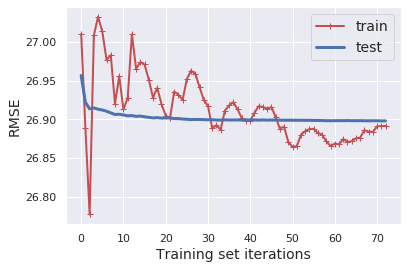

In [131]:
lin_reg = LinearRegression()

lin_reg.fit(df_train_transformed, df_train[model1_label])

df_test_predictions = lin_reg.predict(df_test_transformed)
evaluate_model(lin_reg, df_test_transformed, df_test[model1_label])
plot_learning_curves(lin_reg, df_train_transformed, df_test_transformed, df_train[model1_label], df_test[model1_label], LEARNING_CURVE_STEP_SIZE)

In [ ]:
#lin_reg.summary

# New try with 1 hot encode of : 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK'

In [59]:
if (DATA_LOADED == True):
    del df
    del df_train
    del df_test
    del df_train_transformed
    del df_test_transformed

In [18]:
df = load_data()

In [19]:
all_features, model1_features, model1_label, quantitative_features, qualitative_features = identify_features(df)

Quantitative features : ['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'DISTANCE', 'CRS_ELAPSED_TIME', 'ARR_DELAY', 'DEP_DELAY', 'TAXI_OUT', 'NBFLIGHTS_FORDAYHOUR_FORAIRPORT', 'NBFLIGHTS_FORDAY_FORAIRPORT'] 

Qualitative features : ['ORIGIN', 'CRS_DEP_TIME', 'UNIQUE_CARRIER', 'DEST', 'CRS_ARR_TIME', 'TAIL_NUM'] 



In [20]:
df, df_train, df_test = custom_train_test_split_sample(df)

In [21]:
df_train_transformed = preparation_pipeline_meansort.fit_transform(df_train, categoricalfeatures_1hotencoder__categorical_features_totransform=['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK'])
df_train_transformed = prediction_pipeline_1hotall_without_sparse.fit_transform(df_train_transformed)

df_test_transformed = preparation_pipeline_meansort.transform(df_test)
df_test_transformed = prediction_pipeline_1hotall_without_sparse.transform(df_test_transformed)
DATA_LOADED = True
df_test_transformed.shape

Converting feature CRS_DEP_TIME

Converting feature CRS_ARR_TIME

Fit data
Fitting feature ORIGIN
Fitting feature UNIQUE_CARRIER
Fitting feature DEST
Encode categorical features...
Encoding feature ORIGIN ...
Encoding feature UNIQUE_CARRIER ...
Encoding feature DEST ...
Fit data
!! categorical_features_totransform['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK']
Transform data
1hot encode categorical features...
Column values that were in fitted data but not in current data: []
Column values that were in fitted data but not in current data: []
Column values that were in fitted data but not in current data: []
type of df : <class 'pandas.core.frame.DataFrame'>
Features selected (in order): Index(['CRS_ARR_TIME', 'CRS_DEP_TIME', 'CRS_ELAPSED_TIME', 'DAY_OF_MONTH_1',
       'DAY_OF_MONTH_10', 'DAY_OF_MONTH_11', 'DAY_OF_MONTH_12',
       'DAY_OF_MONTH_13', 'DAY_OF_MONTH_14', 'DAY_OF_MONTH_15',
       'DAY_OF_MONTH_16', 'DAY_OF_MONTH_17', 'DAY_OF_MONTH_18',
       'DAY_OF_MONTH_19', 'DAY_OF_MONTH_2'

(80000, 59)

In [22]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()

lin_reg.fit(df_train_transformed, df_train[model1_label])

df_test_predictions = lin_reg.predict(df_test_transformed)
evaluate_model(lin_reg, df_test_transformed, df_test[model1_label])

RMSE : 26.888713713245284


=> RMSE : 41.98  
=> RMSE without outliers : 26.88

In [23]:
evaluate_model(lin_reg, df_train_transformed, df_train[model1_label])

RMSE : 26.881049367568203


=> RMSE on training set : 41.12  
=> RMSE training set without outliers : 26.89

In [24]:
lin_reg.coef_

array([ 2.66947620e+00,  1.25039481e+00,  2.89203262e+00, -3.63194739e+00,
        2.13128148e-01, -1.91628963e-01,  2.63989368e+10,  2.63989368e+10,
        2.63989368e+10,  2.63989368e+10,  2.63989368e+10,  2.63989368e+10,
        2.63989368e+10,  2.63989368e+10,  2.63989368e+10,  2.63989368e+10,
        2.63989368e+10,  2.63989368e+10,  2.63989368e+10,  2.63989368e+10,
        2.63989368e+10,  2.63989368e+10,  2.63989368e+10,  2.63989368e+10,
        2.63989368e+10,  2.63989368e+10,  2.63989368e+10,  2.63989368e+10,
        2.63989368e+10,  2.63989368e+10,  2.63989368e+10,  2.63989368e+10,
        2.63989368e+10,  2.63989368e+10,  2.63989368e+10,  2.63989368e+10,
        2.63989368e+10, -5.62127352e+09, -5.62127352e+09, -5.62127352e+09,
       -5.62127352e+09, -5.62127352e+09, -5.62127352e+09, -5.62127352e+09,
        2.09808350e-02,  3.41521759e+08,  3.41521758e+08,  3.41521757e+08,
        3.41521764e+08,  3.41521758e+08,  3.41521761e+08,  3.41521759e+08,
        3.41521760e+08,  

In [25]:
# Feature importances :
(abs(lin_reg.coef_) / (abs(lin_reg.coef_).sum()))

array([3.09750773e-12, 1.45088673e-12, 3.35574949e-12, 4.21430433e-12,
       2.47301731e-13, 2.22355305e-13, 3.06318187e-02, 3.06318187e-02,
       3.06318187e-02, 3.06318187e-02, 3.06318187e-02, 3.06318187e-02,
       3.06318187e-02, 3.06318187e-02, 3.06318187e-02, 3.06318187e-02,
       3.06318187e-02, 3.06318187e-02, 3.06318187e-02, 3.06318187e-02,
       3.06318187e-02, 3.06318187e-02, 3.06318187e-02, 3.06318187e-02,
       3.06318187e-02, 3.06318187e-02, 3.06318187e-02, 3.06318187e-02,
       3.06318187e-02, 3.06318187e-02, 3.06318187e-02, 3.06318187e-02,
       3.06318187e-02, 3.06318187e-02, 3.06318187e-02, 3.06318187e-02,
       3.06318187e-02, 6.52260477e-03, 6.52260477e-03, 6.52260477e-03,
       6.52260477e-03, 6.52260477e-03, 6.52260477e-03, 6.52260477e-03,
       2.43449627e-14, 3.96282346e-04, 3.96282344e-04, 3.96282343e-04,
       3.96282351e-04, 3.96282344e-04, 3.96282347e-04, 3.96282345e-04,
       3.96282346e-04, 3.96282350e-04, 3.96282353e-04, 3.96282351e-04,
      

In [26]:
df_train_transformed.shape

(720000, 59)

In [27]:
df_train_transformed

array([[0.04045633206911063, 0.18733106695105436, 2.1096789265942824,
        ..., 0, 265, 7],
       [0.46839979077179467, 0.7400812450526321, -0.15140600506077734,
        ..., 0, 231, 4],
       [-0.19729003387682495, 1.1764629646065092, 2.6684152319599113,
        ..., 0, 295, 7],
       ...,
       [0.023474448787258087, 1.3089937090636126, 2.6863862827172853,
        ..., 1, 175, 11],
       [-1.0633660812513046, -1.0183754618903986, -0.7656891945855624,
        ..., 1, 295, 4],
       [1.2971156949261986, 1.389805138610627, 1.4561861717806812, ...,
        0, 232, 6]], dtype=object)

Calculating learning curve for 73 iterations


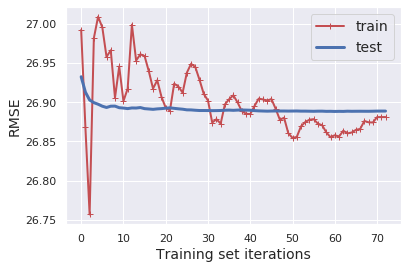

In [28]:
plot_learning_curves(lin_reg, df_train_transformed, df_test_transformed, df_train[model1_label], df_test[model1_label], LEARNING_CURVE_STEP_SIZE)

In [155]:
'''
To gain memory
y_train = df_train[model1_label]
y_test = df_test[model1_label]
del df_train
del df_test
'''

'\nTo gain memory\ny_train = df_train[model1_label]\ny_test = df_test[model1_label]\ndel df_train\ndel df_test\n'

In [32]:
df_train_transformed.shape

(720000, 59)

In [37]:
np.asarray(df_train_transformed)

array([[0.04045633206911063, 0.18733106695105436, 2.1096789265942824,
        ..., 0, 265, 7],
       [0.46839979077179467, 0.7400812450526321, -0.15140600506077734,
        ..., 0, 231, 4],
       [-0.19729003387682495, 1.1764629646065092, 2.6684152319599113,
        ..., 0, 295, 7],
       ...,
       [0.023474448787258087, 1.3089937090636126, 2.6863862827172853,
        ..., 1, 175, 11],
       [-1.0633660812513046, -1.0183754618903986, -0.7656891945855624,
        ..., 1, 295, 4],
       [1.2971156949261986, 1.389805138610627, 1.4561861717806812, ...,
        0, 232, 6]], dtype=object)

In [39]:
#X2 = sm.add_constant(df_train_transformed)
est = sm.OLS(df_train[model1_label], np.asarray(df_train_transformed.astype(float)))
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:              ARR_DELAY   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     667.2
Date:                Wed, 01 Apr 2020   Prob (F-statistic):               0.00
Time:                        16:17:51   Log-Likelihood:            -3.3915e+06
No. Observations:              720000   AIC:                         6.783e+06
Df Residuals:                  719943   BIC:                         6.784e+06
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.6695      0.044     60.752      0.0

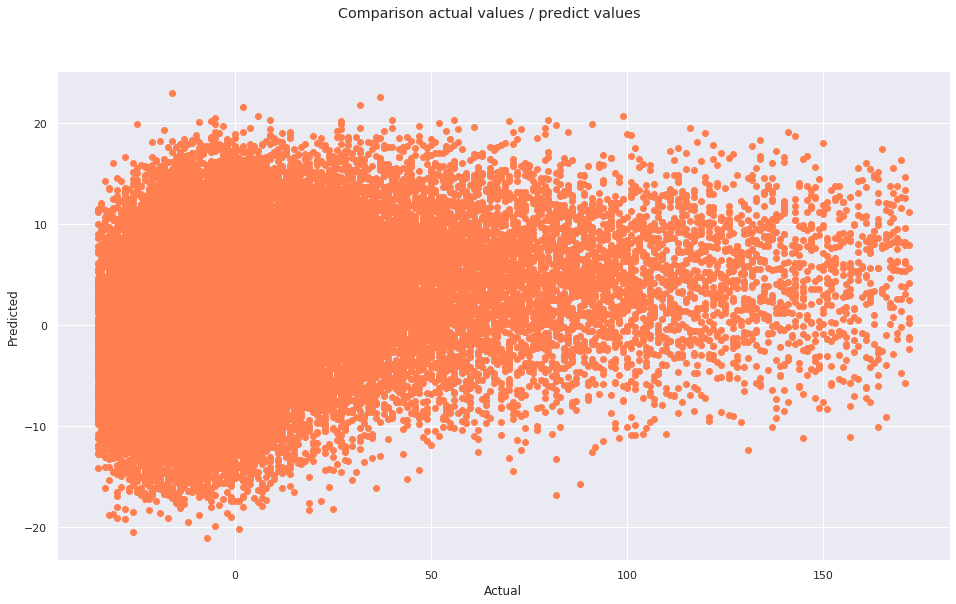

In [40]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison actual values / predict values')
    plt.ylabel("Predicted")
    plt.xlabel("Actual")
    plt.scatter(df_test[model1_label], df_test_predictions, color='coral')

(array([2.000e+00, 3.000e+00, 1.000e+01, 1.400e+01, 4.000e+01, 6.800e+01,
        1.080e+02, 1.890e+02, 2.520e+02, 3.720e+02, 5.250e+02, 6.950e+02,
        8.880e+02, 1.177e+03, 1.464e+03, 1.774e+03, 2.180e+03, 2.493e+03,
        2.928e+03, 3.247e+03, 3.643e+03, 4.046e+03, 4.154e+03, 4.183e+03,
        4.388e+03, 4.441e+03, 4.449e+03, 4.230e+03, 4.114e+03, 3.872e+03,
        3.475e+03, 3.061e+03, 2.765e+03, 2.343e+03, 1.992e+03, 1.559e+03,
        1.253e+03, 1.050e+03, 7.970e+02, 6.050e+02, 4.230e+02, 2.850e+02,
        1.720e+02, 1.190e+02, 8.600e+01, 3.400e+01, 2.300e+01, 5.000e+00,
        2.000e+00, 2.000e+00]),
 array([-21.10660553, -20.22522873, -19.34385193, -18.46247513,
        -17.58109833, -16.69972153, -15.81834473, -14.93696793,
        -14.05559113, -13.17421432, -12.29283752, -11.41146072,
        -10.53008392,  -9.64870712,  -8.76733032,  -7.88595352,
         -7.00457672,  -6.12319992,  -5.24182312,  -4.36044632,
         -3.47906952,  -2.59769272,  -1.71631592,  -0.83

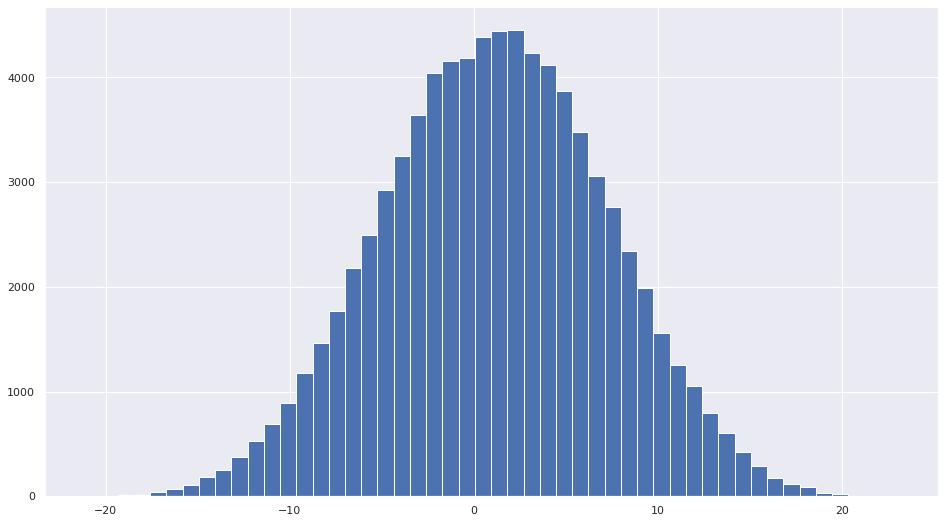

In [54]:
plt.hist(df_test_predictions, bins=50)

(array([ 1046.,  1721.,  3172.,  5307.,  7748.,  9662., 10103., 10864.,
         6464.,  4682.,  3390.,  2532.,  1891.,  1494.,  1477.,   941.,
          795.,   674.,   591.,   511.,   447.,   499.,   350.,   316.,
          284.,   262.,   239.,   221.,   248.,   183.,   165.,   154.,
          144.,   134.,   123.,   146.,   105.,    97.,    91.,    88.,
           80.,    78.,    89.,    65.,    60.,    58.,    53.,    52.,
           47.,    57.]),
 array([-35.  , -30.86, -26.72, -22.58, -18.44, -14.3 , -10.16,  -6.02,
         -1.88,   2.26,   6.4 ,  10.54,  14.68,  18.82,  22.96,  27.1 ,
         31.24,  35.38,  39.52,  43.66,  47.8 ,  51.94,  56.08,  60.22,
         64.36,  68.5 ,  72.64,  76.78,  80.92,  85.06,  89.2 ,  93.34,
         97.48, 101.62, 105.76, 109.9 , 114.04, 118.18, 122.32, 126.46,
        130.6 , 134.74, 138.88, 143.02, 147.16, 151.3 , 155.44, 159.58,
        163.72, 167.86, 172.  ]),
 <a list of 50 Patch objects>)

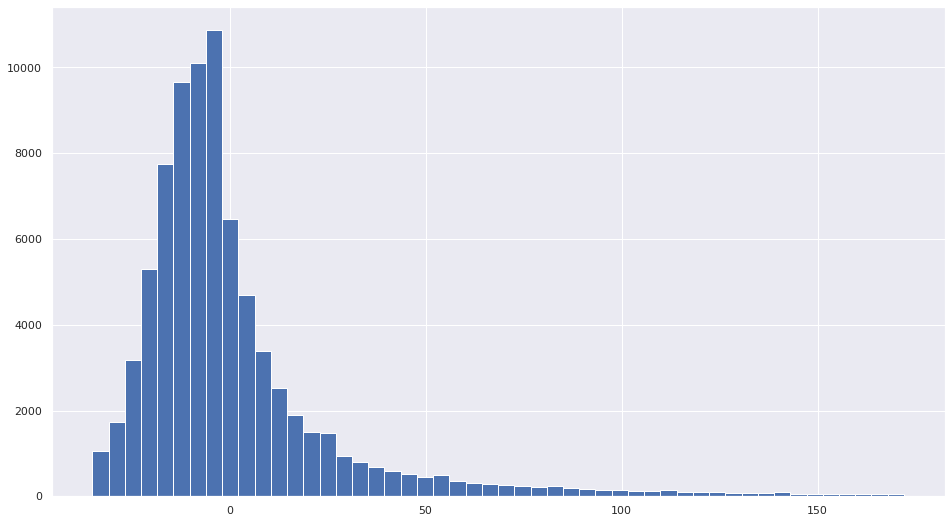

In [55]:
plt.hist(df_test[model1_label], bins=50)

### Degree 2

In [156]:
nb_instances = df_train_transformed.shape[0]

In [157]:
poly = PolynomialFeaturesUnivariateAdder(n_degrees = 2)

In [158]:
df_train_transformed = poly.fit_transform(df_train_transformed)
df_test_transformed = poly.fit_transform(df_test_transformed)

Adding polynomial features


Adding polynomial features


RMSE : 26.866943988702417


Calculating learning curve for 73 iterations


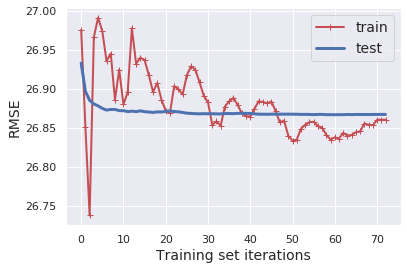

In [159]:
lin_reg = LinearRegression()

lin_reg.fit(df_train_transformed, df_train[model1_label])

df_test_predictions = lin_reg.predict(df_test_transformed)
evaluate_model(lin_reg, df_test_transformed, df_test[model1_label])
plot_learning_curves(lin_reg, df_train_transformed, df_test_transformed, df_train[model1_label], df_test[model1_label], LEARNING_CURVE_STEP_SIZE)

# Random forest

In [160]:
from sklearn.ensemble import RandomForestRegressor

if (EXECUTE_INTERMEDIATE_MODELS == True):
    random_reg = RandomForestRegressor(n_estimators=10, max_depth=10, random_state=42)
    random_reg.fit(df_train_transformed, df_train[model1_label])

In [161]:
random_reg.feature_importances_

array([2.02984164e-01, 2.80952704e-02, 3.47982862e-02, 2.10164992e-02,
       1.63267792e-02, 1.41735737e-02, 1.94920433e-02, 1.61153155e-02,
       1.43738814e-02, 1.58826150e-02, 2.68846087e-02, 2.51733800e-02,
       5.80146024e-04, 9.18183348e-04, 7.71168596e-04, 6.33680023e-04,
       6.69576242e-04, 8.55763785e-04, 9.10039785e-04, 1.03744405e-03,
       1.33137205e-03, 1.53849020e-03, 3.09823497e-03, 2.23622775e-03,
       1.37482662e-03, 1.53863107e-03, 2.42268054e-03, 3.07069400e-03,
       8.66101839e-03, 1.22609527e-02, 6.78391389e-03, 5.64387450e-03,
       1.00691835e-03, 1.35117095e-03, 1.65651175e-03, 1.05088741e-03,
       1.08921320e-03, 1.70222912e-03, 3.19029939e-03, 3.53182461e-03,
       1.66996656e-03, 1.59681336e-03, 3.39499235e-03, 4.92337368e-03,
       9.31374513e-04, 1.40289441e-03, 1.19127176e-03, 1.01359851e-03,
       8.53736839e-04, 7.08388035e-04, 5.63967426e-04, 6.83292743e-04,
       3.07769357e-03, 4.77923237e-03, 3.28966420e-04, 9.17829469e-04,
      

=> feature importance : 25% for CRS_ARR_TIME and 14% for UNIQUE_CARRIER  in previous model  (not this one)

In [162]:
random_reg.estimators_[0]

DecisionTreeRegressor(criterion='mse', max_depth=10, max_features='auto',
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=1608637542, splitter='best')

In [163]:
'''
from sklearn.tree import export_graphviz
export_graphviz(random_reg.estimators_[0], out_file="tree.dot", rounded=True, filled=True)
'''

RMSE : 26.499238113136474


Calculating learning curve for 73 iterations


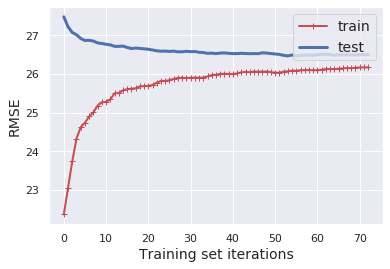

In [164]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    df_test_predictions = random_reg.predict(df_test_transformed)
    evaluate_model(random_reg, df_test_transformed, df_test[model1_label])
    plot_learning_curves(random_reg, df_train_transformed, df_test_transformed, df_train[model1_label], df_test[model1_label], LEARNING_CURVE_STEP_SIZE)

Calculating learning curve for 73 iterations


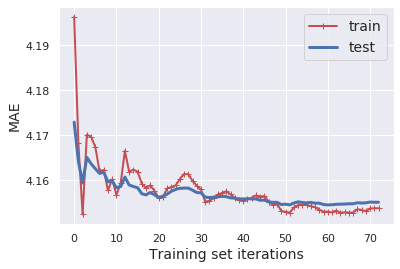

In [165]:
plot_learning_curves(lin_reg, df_train_transformed, df_test_transformed, df_train[model1_label], df_test[model1_label], LEARNING_CURVE_STEP_SIZE, evaluation_method='MAE')

# Cheat model : give access to the model to the ARR_DELAY variable ! it should now learn

In [69]:
if (DATA_LOADED == True):
    del df
    del df_train
    del df_test
    del df_train_transformed
    del df_test_transformed

In [70]:
df = load_data()

In [71]:
all_features, model1_features, model1_label, quantitative_features, qualitative_features = identify_features(df)

Quantitative features : ['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'DISTANCE', 'CRS_ELAPSED_TIME', 'ARR_DELAY', 'DEP_DELAY', 'TAXI_OUT', 'NBFLIGHTS_FORDAYHOUR_FORAIRPORT', 'NBFLIGHTS_FORDAY_FORAIRPORT'] 

Qualitative features : ['ORIGIN', 'CRS_DEP_TIME', 'UNIQUE_CARRIER', 'DEST', 'CRS_ARR_TIME', 'TAIL_NUM'] 



In [72]:
df, df_train, df_test = custom_train_test_split_sample(df)

In [73]:
df_train_transformed = preparation_pipeline_meansort.fit_transform(df_train, categoricalfeatures_1hotencoder__categorical_features_totransform=['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK'])
df_train_transformed = prediction_pipeline_cheat_without_sparse.fit_transform(df_train_transformed)

df_test_transformed = preparation_pipeline_meansort.transform(df_test)
df_test_transformed = prediction_pipeline_cheat_without_sparse.transform(df_test_transformed)
DATA_LOADED = True
df_test_transformed.shape

Converting feature CRS_DEP_TIME

Converting feature CRS_ARR_TIME

Fit data
Fitting feature ORIGIN
Fitting feature UNIQUE_CARRIER
Fitting feature DEST
Encode categorical features...
Encoding feature ORIGIN ...
Encoding feature UNIQUE_CARRIER ...
Encoding feature DEST ...
Fit data
!! categorical_features_totransform['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK']
Transform data
1hot encode categorical features...
Column values that were in fitted data but not in current data: []
Column values that were in fitted data but not in current data: []
Column values that were in fitted data but not in current data: []
type of df : <class 'pandas.core.frame.DataFrame'>
Features selected (in order): Index(['ARR_DELAY', 'CRS_ARR_TIME', 'CRS_DEP_TIME', 'CRS_ELAPSED_TIME',
       'DAY_OF_MONTH_1', 'DAY_OF_MONTH_10', 'DAY_OF_MONTH_11',
       'DAY_OF_MONTH_12', 'DAY_OF_MONTH_13', 'DAY_OF_MONTH_14',
       'DAY_OF_MONTH_15', 'DAY_OF_MONTH_16', 'DAY_OF_MONTH_17',
       'DAY_OF_MONTH_18', 'DAY_OF_MONTH_19', 'DA

(80000, 60)

In [74]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()

lin_reg.fit(df_train_transformed, df_train[model1_label])

df_test_predictions = lin_reg.predict(df_test_transformed)
evaluate_model(lin_reg, df_test_transformed, df_test[model1_label])

RMSE : 5.683864469696559e-13


=> RMSE : 41.98  
=> RMSE without outliers : 26.88

In [75]:
evaluate_model(lin_reg, df_train_transformed, df_train[model1_label])

RMSE : 5.682513733898601e-13


=> RMSE on training set : 41.12  
=> RMSE training set without outliers : 26.89

In [76]:
lin_reg.coef_

array([ 2.75697442e+01,  5.07605441e-15,  5.21920152e-15, -4.09881462e-15,
       -1.25186163e-14,  3.89995219e-15,  6.33844754e-16,  1.00481621e-03,
        1.00481621e-03,  1.00481621e-03,  1.00481621e-03,  1.00481621e-03,
        1.00481621e-03,  1.00481621e-03,  1.00481621e-03,  1.00481621e-03,
        1.00481621e-03,  1.00481621e-03,  1.00481621e-03,  1.00481621e-03,
        1.00481621e-03,  1.00481621e-03,  1.00481621e-03,  1.00481621e-03,
        1.00481621e-03,  1.00481621e-03,  1.00481621e-03,  1.00481621e-03,
        1.00481621e-03,  1.00481621e-03,  1.00481621e-03,  1.00481621e-03,
        1.00481621e-03,  1.00481621e-03,  1.00481621e-03,  1.00481621e-03,
        1.00481621e-03,  1.00481621e-03, -7.61868267e-04, -7.61868267e-04,
       -7.61868267e-04, -7.61868267e-04, -7.61868267e-04, -7.61868267e-04,
       -7.61868267e-04,  2.45008007e-15, -1.73526500e-03, -1.73526500e-03,
       -1.73526500e-03, -1.73526500e-03, -1.73526500e-03, -1.73526500e-03,
       -1.73526500e-03, -

In [77]:
# Feature importances :
(abs(lin_reg.coef_) / (abs(lin_reg.coef_).sum()))

array([9.97925744e-01, 1.83734943e-16, 1.88916354e-16, 1.48362371e-16,
       4.53128960e-16, 1.41164266e-16, 2.29429041e-17, 3.63707388e-05,
       3.63707388e-05, 3.63707388e-05, 3.63707388e-05, 3.63707388e-05,
       3.63707388e-05, 3.63707388e-05, 3.63707388e-05, 3.63707388e-05,
       3.63707388e-05, 3.63707388e-05, 3.63707388e-05, 3.63707388e-05,
       3.63707388e-05, 3.63707388e-05, 3.63707388e-05, 3.63707388e-05,
       3.63707388e-05, 3.63707388e-05, 3.63707388e-05, 3.63707388e-05,
       3.63707388e-05, 3.63707388e-05, 3.63707388e-05, 3.63707388e-05,
       3.63707388e-05, 3.63707388e-05, 3.63707388e-05, 3.63707388e-05,
       3.63707388e-05, 3.63707388e-05, 2.75768956e-05, 2.75768956e-05,
       2.75768956e-05, 2.75768956e-05, 2.75768956e-05, 2.75768956e-05,
       2.75768956e-05, 8.86841010e-17, 6.28103622e-05, 6.28103622e-05,
       6.28103622e-05, 6.28103622e-05, 6.28103622e-05, 6.28103622e-05,
       6.28103622e-05, 6.28103622e-05, 6.28103622e-05, 6.28103622e-05,
      

In [78]:
df_train_transformed.shape

(720000, 60)

In [79]:
df_train_transformed

array([[ 1.04155039e-01,  4.04563321e-02,  1.87331067e-01, ...,
         0.00000000e+00,  2.65000000e+02,  7.00000000e+00],
       [-2.22289775e-01,  4.68399791e-01,  7.40081245e-01, ...,
         0.00000000e+00,  2.31000000e+02,  4.00000000e+00],
       [ 3.16117470e-02, -1.97290034e-01,  1.17646296e+00, ...,
         0.00000000e+00,  2.95000000e+02,  7.00000000e+00],
       ...,
       [ 1.40993429e+00,  2.34744488e-02,  1.30899371e+00, ...,
         1.00000000e+00,  1.75000000e+02,  1.10000000e+01],
       [-5.48734588e-01, -1.06336608e+00, -1.01837546e+00, ...,
         1.00000000e+00,  2.95000000e+02,  4.00000000e+00],
       [-4.39919650e-01,  1.29711569e+00,  1.38980514e+00, ...,
         0.00000000e+00,  2.32000000e+02,  6.00000000e+00]])

Calculating learning curve for 15 iterations


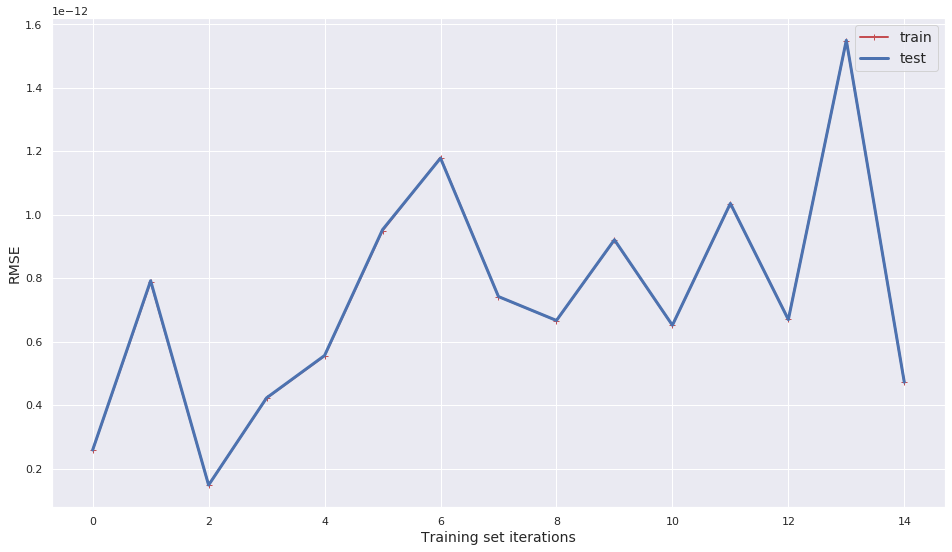

In [80]:
plot_learning_curves(lin_reg, df_train_transformed, df_test_transformed, df_train[model1_label], df_test[model1_label], LEARNING_CURVE_STEP_SIZE)

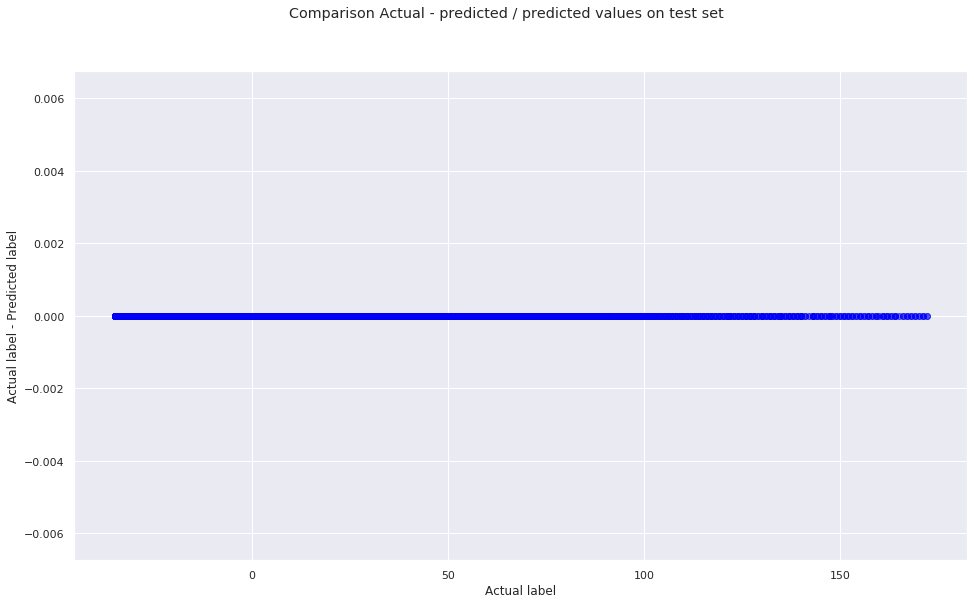

In [81]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison Actual - predicted / predicted values on test set')
    plt.xlabel("Actual label")
    plt.ylabel("Actual label - Predicted label")
    plt.scatter(df_test[model1_label], df_test[model1_label] - df_test_predictions, color='blue', alpha=0.1)

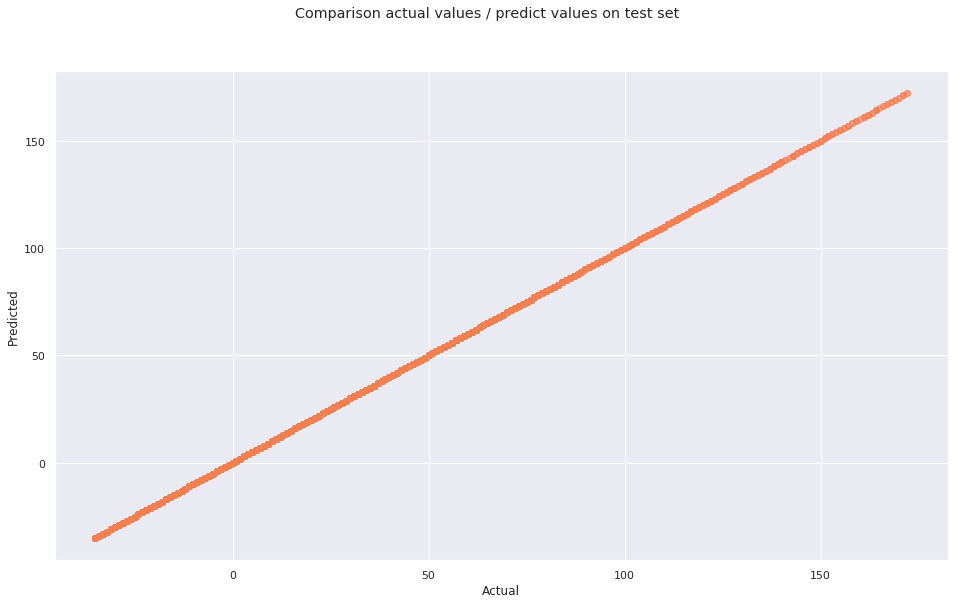

In [82]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison actual values / predict values on test set')
    plt.ylabel("Predicted")
    plt.xlabel("Actual")
    plt.scatter(df_test[model1_label], df_test_predictions, color='coral', alpha=0.1)

# Random forest without polynomial feature

In [231]:
if (DATA_LOADED == True):
    del df
    del df_train
    del df_test
    del df_train_transformed
    del df_test_transformed

In [232]:
df = load_data()

In [233]:
all_features, model1_features, model1_label, quantitative_features, qualitative_features = identify_features(df)

Quantitative features : ['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'DISTANCE', 'CRS_ELAPSED_TIME', 'ARR_DELAY', 'DEP_DELAY', 'TAXI_OUT', 'NBFLIGHTS_FORDAYHOUR_FORAIRPORT', 'NBFLIGHTS_FORDAY_FORAIRPORT'] 

Qualitative features : ['ORIGIN', 'CRS_DEP_TIME', 'UNIQUE_CARRIER', 'DEST', 'CRS_ARR_TIME', 'TAIL_NUM'] 



In [234]:
df, df_train, df_test = custom_train_test_split_sample(df)

In [235]:
df_train_transformed = preparation_pipeline_meansort.fit_transform(df_train, categoricalfeatures_1hotencoder__categorical_features_totransform=['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK'])
df_train_transformed = prediction_pipeline_1hotall_without_sparse.fit_transform(df_train_transformed)

df_test_transformed = preparation_pipeline_meansort.transform(df_test)
df_test_transformed = prediction_pipeline_1hotall_without_sparse.transform(df_test_transformed)
DATA_LOADED = True
df_test_transformed.shape

Converting feature CRS_DEP_TIME

Converting feature CRS_ARR_TIME

Fit data
Fitting feature ORIGIN
Fitting feature UNIQUE_CARRIER
Fitting feature DEST
Encode categorical features...
Encoding feature ORIGIN ...
Encoding feature UNIQUE_CARRIER ...
Encoding feature DEST ...
Fit data
!! categorical_features_totransform['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK']
Transform data
1hot encode categorical features...
Column values that were in fitted data but not in current data: []
Column values that were in fitted data but not in current data: []
Column values that were in fitted data but not in current data: []
type of df : <class 'pandas.core.frame.DataFrame'>
Features selected (in order): Index(['CRS_ARR_TIME', 'CRS_DEP_TIME', 'CRS_ELAPSED_TIME', 'DAY_OF_MONTH_1',
       'DAY_OF_MONTH_10', 'DAY_OF_MONTH_11', 'DAY_OF_MONTH_12',
       'DAY_OF_MONTH_13', 'DAY_OF_MONTH_14', 'DAY_OF_MONTH_15',
       'DAY_OF_MONTH_16', 'DAY_OF_MONTH_17', 'DAY_OF_MONTH_18',
       'DAY_OF_MONTH_19', 'DAY_OF_MONTH_2'

(80000, 59)

In [236]:
%%time
from sklearn.ensemble import RandomForestRegressor

if (EXECUTE_INTERMEDIATE_MODELS == True):
    random_reg = RandomForestRegressor(n_estimators=100, max_depth=100, n_jobs=-1, random_state=42)
    random_reg.fit(df_train_transformed, df_train[model1_label])

CPU times: user 54min 3s, sys: 10.2 s, total: 54min 14s
Wall time: 7min 20s


In [237]:
print("Evaluation on test set :")
evaluate_model(random_reg, df_test_transformed, df_test[model1_label])

print('\n')

print("Evaluation on training set :")
evaluate_model(random_reg, df_train_transformed, df_train[model1_label])

Evaluation on test set :
RMSE : 25.688478031845328


Evaluation on training set :
RMSE : 9.623992685309045


=> n_estimators=10, max_depth=10 : RMSE = 26.489032357237143  
=> n_estimators=100, max_depth=10 : RMSE = 26.452279766206914  
=> n_estimators=100, max_depth=100 : RMSE train = 9.623992685309045, RMSE test = 25.688478031845328

In [240]:
df_test_predictions = random_reg.predict(df_test_transformed)

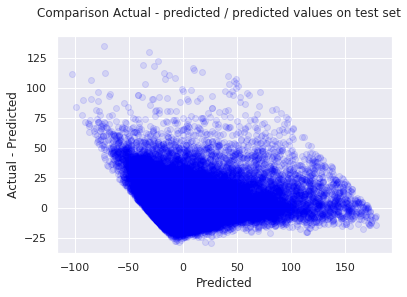

In [243]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison Actual - predicted / predicted values on test set')
    plt.xlabel("Predicted")
    plt.ylabel("Actual - Predicted")
    plt.scatter(df_test[model1_label] - df_test_predictions, df_test_predictions, color='blue', alpha=0.1)

In [23]:
random_reg.feature_importances_

array([0.10071234, 0.09244768, 0.06079729, 0.07713412, 0.07257125,
       0.09888103, 0.00670222, 0.00680237, 0.0068136 , 0.00639287,
       0.00694074, 0.00813558, 0.0083177 , 0.00813019, 0.00907532,
       0.0088766 , 0.00793789, 0.00714432, 0.00652994, 0.00815357,
       0.00765488, 0.00763167, 0.00768319, 0.00689554, 0.00786885,
       0.00674774, 0.00736529, 0.00704907, 0.00578431, 0.00689985,
       0.00482444, 0.00662366, 0.00712427, 0.00692974, 0.00648133,
       0.00813818, 0.00716885, 0.00872767, 0.00789323, 0.00787579,
       0.00819434, 0.00827806, 0.00533251, 0.00727083, 0.06851414,
       0.00600277, 0.00437264, 0.00504068, 0.00456455, 0.00564331,
       0.00537132, 0.00457294, 0.00423125, 0.00509148, 0.00724596,
       0.00603303, 0.00452757, 0.05162468, 0.03622378])

In [25]:
random_reg.feature_importances_.cumsum()

array([0.10071234, 0.19316003, 0.25395732, 0.33109144, 0.40366269,
       0.50254372, 0.50924594, 0.51604831, 0.5228619 , 0.52925477,
       0.53619552, 0.54433109, 0.55264879, 0.56077898, 0.5698543 ,
       0.5787309 , 0.58666879, 0.59381311, 0.60034305, 0.60849662,
       0.6161515 , 0.62378317, 0.63146636, 0.63836191, 0.64623075,
       0.65297849, 0.66034379, 0.66739285, 0.67317716, 0.68007701,
       0.68490145, 0.69152511, 0.69864938, 0.70557911, 0.71206045,
       0.72019863, 0.72736747, 0.73609514, 0.74398837, 0.75186416,
       0.7600585 , 0.76833655, 0.77366906, 0.78093989, 0.84945403,
       0.8554568 , 0.85982944, 0.86487012, 0.86943467, 0.87507799,
       0.88044931, 0.88502225, 0.8892535 , 0.89434498, 0.90159094,
       0.90762397, 0.91215154, 0.96377622, 1.        ])

=> feature importance : 25% for CRS_ARR_TIME and 14% for UNIQUE_CARRIER  in previous model  (not this one)

In [ ]:
random_reg.estimators_[0]

In [24]:
'''
from sklearn.tree import export_graphviz
export_graphviz(random_reg.estimators_[0], out_file="tree.dot", rounded=True, filled=True)
'''

'\nfrom sklearn.tree import export_graphviz\nexport_graphviz(random_reg.estimators_[0], out_file="tree.dot", rounded=True, filled=True)\n'

In [27]:
LEARNING_CURVE_STEP_SIZE

10000

RMSE : 25.688478031845328


Calculating learning curve for 15 iterations


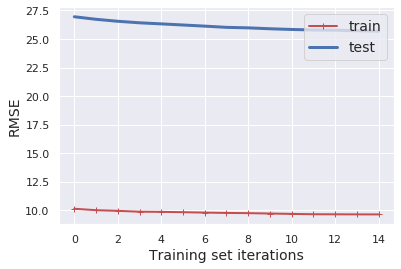

In [28]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    df_test_predictions = random_reg.predict(df_test_transformed)
    evaluate_model(random_reg, df_test_transformed, df_test[model1_label])
    plot_learning_curves(random_reg, df_train_transformed, df_test_transformed, df_train[model1_label], df_test[model1_label], LEARNING_CURVE_STEP_SIZE*5)

In [ ]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison actual values / predict values')
    plt.ylabel("Predicted")
    plt.xlabel("Actual")
    plt.scatter(df_test[model1_label], df_test_predictions, color='coral', alpha=0.1)

In [ ]:
df_train_predictions = lin_reg.predict(df_train_transformed)

if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison actual values / predict values on training set')
    plt.ylabel("Predicted")
    plt.xlabel("Actual")
    plt.scatter(df_train[model1_label], df_train_predictions, color='coral', alpha=0.1)

(array([1.9000e+01, 1.7200e+02, 1.8880e+03, 5.1800e+03, 1.1746e+04,
        1.4684e+04, 1.0657e+04, 1.0545e+04, 7.5750e+03, 6.6700e+03,
        4.1730e+03, 2.1050e+03, 1.1380e+03, 1.2280e+03, 9.5400e+02,
        3.6000e+02, 2.6000e+02, 1.8600e+02, 1.1200e+02, 4.1000e+01,
        5.6000e+01, 4.6000e+01, 4.1000e+01, 2.1000e+01, 2.3000e+01,
        2.3000e+01, 1.8000e+01, 1.3000e+01, 1.2000e+01, 1.2000e+01,
        1.2000e+01, 5.0000e+00, 5.0000e+00, 5.0000e+00, 1.0000e+00,
        2.0000e+00, 2.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 2.0000e+00, 2.0000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([-15.50538836, -13.17166769, -10.83794703,  -8.50422637,
         -6.1705057 ,  -3.83678504,  -1.50306438,   0.83065629,
          3.16437695,   5.49809762,   7.83181828,  10.16553894,
         12.49925961,  14.83298027,  17.16670093,  19.5004216 ,
         21.83414226,  24.16786293,  26.50158359,  28.83530425

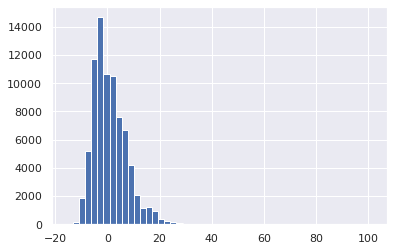

In [27]:
plt.hist(df_test_predictions, bins=50)

(array([ 1046.,  1721.,  3172.,  5307.,  7748.,  9662., 10103., 10864.,
         6464.,  4682.,  3390.,  2532.,  1891.,  1494.,  1477.,   941.,
          795.,   674.,   591.,   511.,   447.,   499.,   350.,   316.,
          284.,   262.,   239.,   221.,   248.,   183.,   165.,   154.,
          144.,   134.,   123.,   146.,   105.,    97.,    91.,    88.,
           80.,    78.,    89.,    65.,    60.,    58.,    53.,    52.,
           47.,    57.]),
 array([-35.  , -30.86, -26.72, -22.58, -18.44, -14.3 , -10.16,  -6.02,
         -1.88,   2.26,   6.4 ,  10.54,  14.68,  18.82,  22.96,  27.1 ,
         31.24,  35.38,  39.52,  43.66,  47.8 ,  51.94,  56.08,  60.22,
         64.36,  68.5 ,  72.64,  76.78,  80.92,  85.06,  89.2 ,  93.34,
         97.48, 101.62, 105.76, 109.9 , 114.04, 118.18, 122.32, 126.46,
        130.6 , 134.74, 138.88, 143.02, 147.16, 151.3 , 155.44, 159.58,
        163.72, 167.86, 172.  ]),
 <a list of 50 Patch objects>)

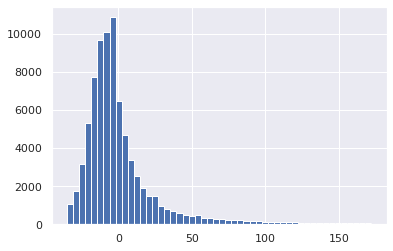

In [28]:
plt.hist(df_test[model1_label], bins=50)

# New try with 1 hot encode of : 'ORIGIN', 'CARRIER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'CRS_DEP_TIME' (scheduled dep hour)

In [18]:
if (DATA_LOADED == True):
    del df
    del df_train
    del df_test
    del df_train_transformed
    del df_test_transformed

NameError: name 'DATA_LOADED' is not defined

In [19]:
df = load_data()

In [20]:
df

,ORIGIN,CRS_DEP_TIME,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,DEST,CRS_ARR_TIME,DISTANCE,CRS_ELAPSED_TIME,ARR_DELAY,DEP_DELAY,TAXI_OUT,TAIL_NUM,NBFLIGHTS_FORDAY_FORAIRPORT,NBFLIGHTS_FORDAYHOUR_FORAIRPORT
0,BOS,0600,9,1,4,AA,JFK,0715,187.0,75.0,-23.0,-9.0,13.0,N798AA,370,30
1,BOS,0600,9,2,5,AA,JFK,0715,187.0,75.0,-6.0,-8.0,26.0,N797AA,369,32
2,BOS,0600,9,6,2,AA,JFK,0715,187.0,75.0,-19.0,-4.0,12.0,N797AA,355,28
3,BOS,0600,9,8,4,AA,JFK,0715,187.0,75.0,-27.0,-8.0,12.0,N784AA,351,32
4,BOS,0600,9,9,5,AA,JFK,0715,187.0,75.0,-21.0,-8.0,17.0,N798AA,352,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5547823,MEM,0600,8,31,3,WN,HOU,0735,484.0,95.0,21.0,-5.0,8.0,N7876A,40,6
5547824,MEM,0750,8,31,3,WN,MCO,1045,684.0,115.0,-3.0,-5.0,12.0,N7832A,40,5
5547825,MEM,1015,8,31,3,WN,MDW,1150,480.0,95.0,-5.0,-10.0,15.0,N942WN,40,2
5547826,MEM,1825,8,31,3,WN,MDW,1955,480.0,90.0,-14.0,-6.0,8.0,N965WN,40,3


In [21]:
all_features, model1_features, model1_label, quantitative_features, qualitative_features = identify_features(df)

Quantitative features : ['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'DISTANCE', 'CRS_ELAPSED_TIME', 'ARR_DELAY', 'DEP_DELAY', 'TAXI_OUT', 'NBFLIGHTS_FORDAYHOUR_FORAIRPORT', 'NBFLIGHTS_FORDAY_FORAIRPORT'] 

Qualitative features : ['ORIGIN', 'CRS_DEP_TIME', 'UNIQUE_CARRIER', 'DEST', 'CRS_ARR_TIME', 'TAIL_NUM'] 



In [22]:
df, df_train, df_test = custom_train_test_split_sample_random(df)

In [23]:
#df_train_transformed = preparation_pipeline_meansort_standardscale.fit_transform(df_train, categoricalfeatures_1hotencoder__categorical_features_totransform=None)

In [24]:
df_train_transformed = preparation_pipeline_1hotall_minmax.fit_transform(df_train, categoricalfeatures_1hotencoder__categorical_features_totransform=['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'ORIGIN', 'UNIQUE_CARRIER', 'CRS_DEP_TIME'])
df_test_transformed = preparation_pipeline_1hotall_minmax.transform(df_test)
DATA_LOADED = True
df_test_transformed.shape

Fit high percentile filter...
Total number of ORIGIN values : 308
Number of ORIGIN high percentile (> 80%) values : 45
Number of ORIGIN low percentile values : 263
Sum of high percentile + low percentile values : 308
Total number of DEST values : 308
Number of DEST high percentile (> 80%) values : 45
Number of DEST low percentile values : 263
Sum of high percentile + low percentile values : 308
End of high percentile filter fit
Apply high percentile filter...
Apply filter on feature ORIGIN
Apply filter on feature DEST
Converting feature CRS_DEP_TIME

Converting feature CRS_ARR_TIME

Fit data
!! categorical_features_totransform['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'ORIGIN', 'UNIQUE_CARRIER', 'CRS_DEP_TIME']
Transform data
1hot encode categorical features...
Column values that were in fitted data but not in current data: []
Column values that were in fitted data but not in current data: []
Column values that were in fitted data but not in current data: []
Column values that were in fi

(80000, 136)

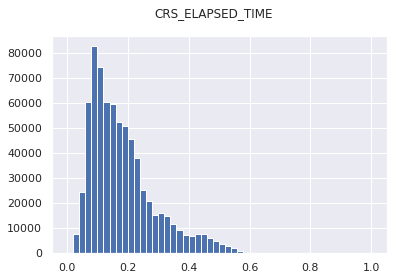

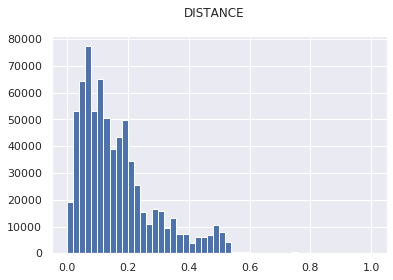

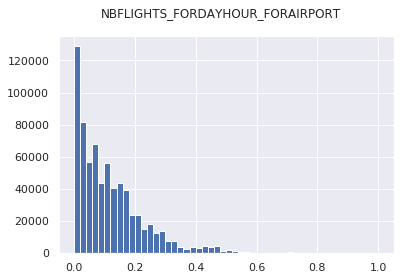

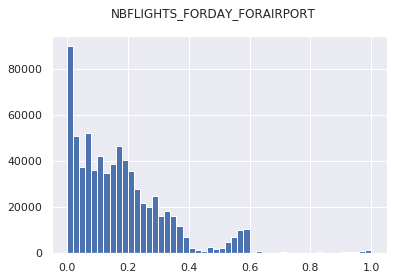

In [25]:
for feat_name in df_train_transformed.columns:
    if (feat_name in MODEL_1HOTALL_FEATURES_QUANTITATIVE):
        fig = plt.figure()
        fig.suptitle(feat_name)
        plt.hist(df_train_transformed[feat_name], bins=50)
        plt.plot()

## Linear regression

In [26]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()

lin_reg.fit(df_train_transformed, df_train[model1_label])

df_test_predictions = lin_reg.predict(df_test_transformed)

print("Evaluation on test set :")
evaluate_model(lin_reg, df_test_transformed, df_test[model1_label])

print('\n')

print("Evaluation on training set :")
evaluate_model(lin_reg, df_train_transformed, df_train[model1_label])

Evaluation on test set :
RMSE : 26.926526678300238


Evaluation on training set :
RMSE : 26.865377694769087


(array([4.000e+00, 1.400e+01, 2.300e+01, 7.400e+01, 1.130e+02, 1.490e+02,
        2.010e+02, 3.280e+02, 4.580e+02, 6.040e+02, 8.020e+02, 9.480e+02,
        1.279e+03, 1.523e+03, 1.687e+03, 2.030e+03, 2.237e+03, 2.530e+03,
        2.937e+03, 3.154e+03, 3.435e+03, 3.627e+03, 3.815e+03, 3.892e+03,
        4.043e+03, 4.047e+03, 3.960e+03, 3.973e+03, 3.691e+03, 3.567e+03,
        3.305e+03, 3.087e+03, 2.689e+03, 2.364e+03, 2.028e+03, 1.759e+03,
        1.371e+03, 1.148e+03, 9.010e+02, 6.800e+02, 5.460e+02, 3.770e+02,
        2.510e+02, 1.410e+02, 1.060e+02, 5.500e+01, 2.200e+01, 2.000e+01,
        3.000e+00, 2.000e+00]),
 array([-18.86035156, -18.0571875 , -17.25402344, -16.45085938,
        -15.64769531, -14.84453125, -14.04136719, -13.23820313,
        -12.43503906, -11.631875  , -10.82871094, -10.02554687,
         -9.22238281,  -8.41921875,  -7.61605469,  -6.81289062,
         -6.00972656,  -5.2065625 ,  -4.40339844,  -3.60023437,
         -2.79707031,  -1.99390625,  -1.19074219,  -0.38

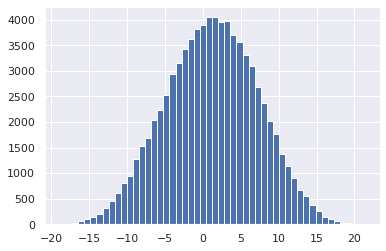

In [27]:
plt.hist(df_test_predictions, bins=50)

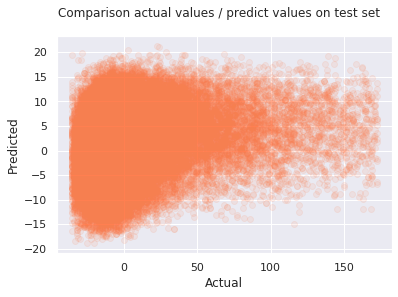

In [28]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison actual values / predict values on test set')
    plt.ylabel("Predicted")
    plt.xlabel("Actual")
    plt.scatter(df_test[model1_label], df_test_predictions, color='coral', alpha=0.1)

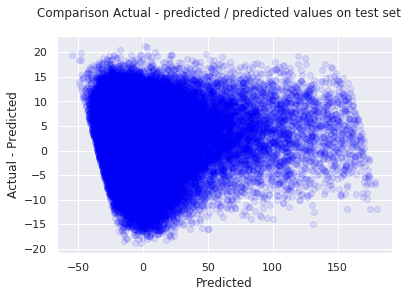

In [29]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison Actual - predicted / predicted values on test set')
    plt.xlabel("Predicted")
    plt.ylabel("Actual - Predicted")
    plt.scatter(df_test_predictions, df_test[model1_label] - df_test_predictions, color='blue', alpha=0.1)

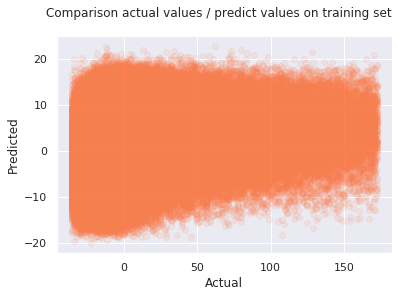

In [30]:
df_train_predictions = lin_reg.predict(df_train_transformed)

if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison actual values / predict values on training set')
    plt.ylabel("Predicted")
    plt.xlabel("Actual")
    plt.scatter(df_train[model1_label], df_train_predictions, color='coral', alpha=0.1)

In [31]:
lin_reg.coef_

array([ 7.52421110e+11,  7.52421110e+11,  7.52421110e+11,  7.52421110e+11,
        7.52421110e+11,  7.52421110e+11,  7.52421110e+11,  7.52421110e+11,
        7.52421110e+11,  7.52421110e+11,  7.52421110e+11,  7.52421110e+11,
        7.52421110e+11,  7.52421110e+11,  7.52421110e+11,  7.52421110e+11,
        7.52421110e+11,  7.52421110e+11,  7.52421110e+11,  7.52421110e+11,
        7.52421110e+11,  7.52421110e+11,  7.52421110e+11,  7.52421110e+11,
       -4.49857483e+01, -3.49085260e+13, -3.49085260e+13, -3.49085260e+13,
       -3.49085260e+13, -3.49085260e+13, -3.49085260e+13, -3.49085260e+13,
       -3.49085260e+13, -3.49085260e+13, -3.49085260e+13, -3.49085260e+13,
       -3.49085260e+13, -3.49085260e+13, -3.49085260e+13, -3.49085260e+13,
       -3.49085260e+13, -3.49085260e+13, -3.49085260e+13, -3.49085260e+13,
       -3.49085260e+13, -3.49085260e+13, -3.49085260e+13, -3.49085260e+13,
       -3.49085260e+13, -3.49085260e+13, -3.49085260e+13, -3.49085260e+13,
       -3.49085260e+13, -

In [32]:
coef_feature_importances = (abs(lin_reg.coef_) / (abs(lin_reg.coef_).sum()))

In [33]:
coef_feature_importances.sum()

1.0

In [34]:
df_feature_importances = pd.DataFrame(data = {'Feature name' : df_train_transformed.columns, 'Feature importance' : coef_feature_importances})

In [35]:
pd.concat([df_feature_importances.sort_values(by='Feature importance', ascending=False), \
           df_feature_importances[['Feature importance']].sort_values(by='Feature importance', ascending=False).cumsum()], axis=1)

,Feature name,Feature importance,Feature importance
53,DAY_OF_MONTH_7,1.337311e-02,0.013373
47,DAY_OF_MONTH_3,1.337311e-02,0.026746
42,DAY_OF_MONTH_25,1.337311e-02,0.040119
50,DAY_OF_MONTH_4,1.337311e-02,0.053492
52,DAY_OF_MONTH_6,1.337311e-02,0.066866
...,...,...,...
4,CRS_DEP_TIME_04,2.882450e-04,1.000000
24,CRS_ELAPSED_TIME,1.723359e-14,1.000000
63,DISTANCE,1.368308e-14,1.000000
77,NBFLIGHTS_FORDAY_FORAIRPORT,3.381475e-15,1.000000


## Random forest

In [36]:
%%time
from sklearn.ensemble import RandomForestRegressor

if (EXECUTE_INTERMEDIATE_MODELS == True):
    random_reg = RandomForestRegressor(n_estimators=100, max_depth=100, n_jobs=-1, random_state=42)
    random_reg.fit(df_train_transformed, df_train[model1_label])

CPU times: user 1h 43min 16s, sys: 13.4 s, total: 1h 43min 29s
Wall time: 13min 47s


In [37]:
print("Evaluation on test set :")
evaluate_model(random_reg, df_test_transformed, df_test[model1_label])

print('\n')

print("Evaluation on training set :")
evaluate_model(random_reg, df_train_transformed, df_train[model1_label])

Evaluation on test set :
RMSE : 26.10779323185514


Evaluation on training set :
RMSE : 9.733177680530055


=> n_estimators=10, max_depth=10 : RMSE = 26.489032357237143  
=> n_estimators=100, max_depth=10 : RMSE = 26.452279766206914  
=> n_estimators=100, max_depth=100 : RMSE train = 9.763346955508453, RMSE test = 25.84449542291657

In [38]:
df_test_predictions = random_reg.predict(df_test_transformed)

In [39]:
df_train_predictions = random_reg.predict(df_train_transformed)

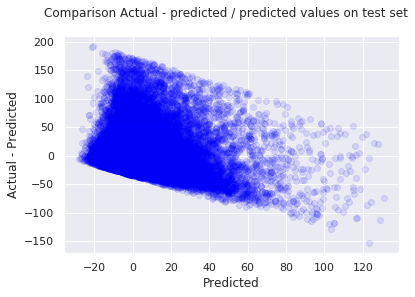

In [40]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison Actual - predicted / predicted values on test set')
    plt.xlabel("Predicted")
    plt.ylabel("Actual - Predicted")
    plt.scatter(df_test_predictions, df_test[model1_label] - df_test_predictions, color='blue', alpha=0.1)

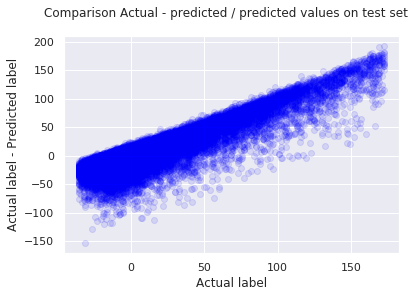

In [41]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison Actual - predicted / predicted values on test set')
    plt.xlabel("Actual label")
    plt.ylabel("Actual label - Predicted label")
    plt.scatter(df_test[model1_label], df_test[model1_label] - df_test_predictions, color='blue', alpha=0.1)

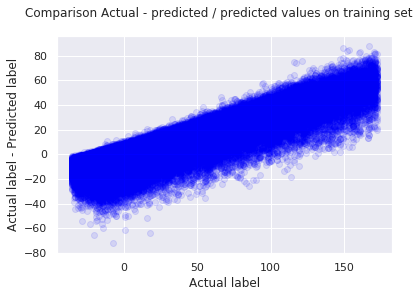

In [42]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison Actual - predicted / predicted values on training set')
    plt.xlabel("Actual label")
    plt.ylabel("Actual label - Predicted label")
    plt.scatter(df_train[model1_label], df_train[model1_label] - df_train_predictions, color='blue', alpha=0.1)

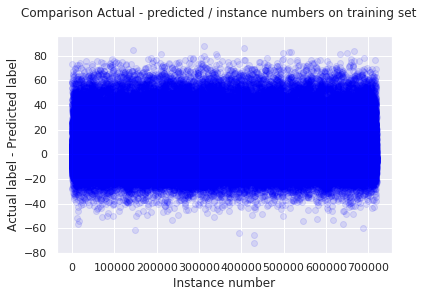

In [43]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison Actual - predicted / instance numbers on training set')
    plt.xlabel("Instance number")
    plt.ylabel("Actual label - Predicted label")
    plt.scatter(range(df_train.shape[0]), df_train[model1_label] - df_train_predictions, color='blue', alpha=0.1)

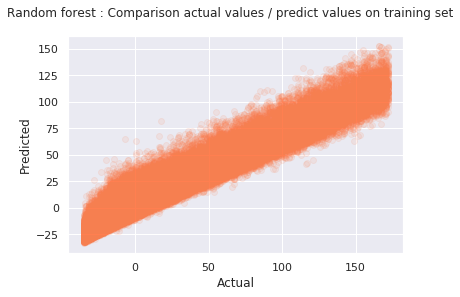

In [44]:
df_train_predictions = random_reg.predict(df_train_transformed)

if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Random forest : Comparison actual values / predict values on training set')
    plt.ylabel("Predicted")
    plt.xlabel("Actual")
    plt.scatter(df_train[model1_label], df_train_predictions, color='coral', alpha=0.1)

In [45]:
df_train_transformed.columns

Index(['CRS_DEP_TIME_00', 'CRS_DEP_TIME_01', 'CRS_DEP_TIME_02',
       'CRS_DEP_TIME_03', 'CRS_DEP_TIME_04', 'CRS_DEP_TIME_05',
       'CRS_DEP_TIME_06', 'CRS_DEP_TIME_07', 'CRS_DEP_TIME_08',
       'CRS_DEP_TIME_09',
       ...
       'UNIQUE_CARRIER_B6', 'UNIQUE_CARRIER_DL', 'UNIQUE_CARRIER_EV',
       'UNIQUE_CARRIER_F9', 'UNIQUE_CARRIER_HA', 'UNIQUE_CARRIER_NK',
       'UNIQUE_CARRIER_OO', 'UNIQUE_CARRIER_UA', 'UNIQUE_CARRIER_VX',
       'UNIQUE_CARRIER_WN'],
      dtype='object', length=136)

In [46]:
pd.set_option('display.max_rows', 200)

In [47]:
df_feature_importances = pd.DataFrame(data = {'Feature name' : df_train_transformed.columns, 'Feature importance' : random_reg.feature_importances_})

In [48]:
pd.concat([df_feature_importances.sort_values(by='Feature importance', ascending=False), \
           df_feature_importances[['Feature importance']].sort_values(by='Feature importance', ascending=False).cumsum()], axis=1)

,Feature name,Feature importance,Feature importance
24,CRS_ELAPSED_TIME,0.125664,0.125664
63,DISTANCE,0.118949,0.244613
77,NBFLIGHTS_FORDAY_FORAIRPORT,0.101403,0.346016
76,NBFLIGHTS_FORDAYHOUR_FORAIRPORT,0.083236,0.429252
17,CRS_DEP_TIME_17,0.009487,0.438739
16,CRS_DEP_TIME_16,0.009278,0.448017
15,CRS_DEP_TIME_15,0.009053,0.457070
19,CRS_DEP_TIME_19,0.009031,0.466102
18,CRS_DEP_TIME_18,0.008596,0.474698
33,DAY_OF_MONTH_17,0.008461,0.483159


In [49]:
random_reg.feature_importances_

array([3.94077861e-04, 2.56042636e-04, 1.10954616e-04, 7.14783701e-05,
       1.53307769e-05, 2.67437440e-03, 5.45232420e-03, 4.09073957e-03,
       3.71108515e-03, 5.61149164e-03, 5.98674777e-03, 6.04010472e-03,
       7.92747160e-03, 7.80449824e-03, 8.40071479e-03, 9.05328834e-03,
       9.27820256e-03, 9.48735294e-03, 8.59610771e-03, 9.03134950e-03,
       8.20052362e-03, 6.25080627e-03, 4.61471682e-03, 1.60073978e-03,
       1.25663922e-01, 6.29405637e-03, 6.27415172e-03, 6.36881008e-03,
       5.64545699e-03, 6.40371551e-03, 6.76901402e-03, 7.39889610e-03,
       7.07611982e-03, 8.46061750e-03, 8.21253391e-03, 6.96377186e-03,
       6.33811938e-03, 6.82066856e-03, 7.61514922e-03, 7.13641614e-03,
       5.92975583e-03, 7.13524739e-03, 6.30195945e-03, 7.21579108e-03,
       6.35083409e-03, 6.92103044e-03, 6.72016208e-03, 5.41862573e-03,
       6.23364366e-03, 4.36253992e-03, 5.91782628e-03, 6.55921299e-03,
       6.35603838e-03, 5.70513859e-03, 8.01865601e-03, 7.25519320e-03,
      

In [50]:
random_reg.feature_importances_.cumsum()

array([3.94077861e-04, 6.50120497e-04, 7.61075113e-04, 8.32553483e-04,
       8.47884260e-04, 3.52225866e-03, 8.97458286e-03, 1.30653224e-02,
       1.67764076e-02, 2.23878992e-02, 2.83746470e-02, 3.44147517e-02,
       4.23422233e-02, 5.01467215e-02, 5.85474363e-02, 6.76007247e-02,
       7.68789272e-02, 8.63662802e-02, 9.49623879e-02, 1.03993737e-01,
       1.12194261e-01, 1.18445067e-01, 1.23059784e-01, 1.24660524e-01,
       2.50324446e-01, 2.56618503e-01, 2.62892654e-01, 2.69261464e-01,
       2.74906921e-01, 2.81310637e-01, 2.88079651e-01, 2.95478547e-01,
       3.02554667e-01, 3.11015284e-01, 3.19227818e-01, 3.26191590e-01,
       3.32529709e-01, 3.39350378e-01, 3.46965527e-01, 3.54101943e-01,
       3.60031699e-01, 3.67166947e-01, 3.73468906e-01, 3.80684697e-01,
       3.87035531e-01, 3.93956562e-01, 4.00676724e-01, 4.06095349e-01,
       4.12328993e-01, 4.16691533e-01, 4.22609359e-01, 4.29168572e-01,
       4.35524611e-01, 4.41229749e-01, 4.49248405e-01, 4.56503598e-01,
      

=> feature importance : 

In [51]:
random_reg.estimators_[0]

DecisionTreeRegressor(criterion='mse', max_depth=100, max_features='auto',
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=1608637542, splitter='best')

In [52]:
'''
from sklearn.tree import export_graphviz
export_graphviz(random_reg.estimators_[0], out_file="tree.dot", rounded=True, filled=True)
'''

'\nfrom sklearn.tree import export_graphviz\nexport_graphviz(random_reg.estimators_[0], out_file="tree.dot", rounded=True, filled=True)\n'

In [53]:
LEARNING_CURVE_STEP_SIZE

50000

In [54]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    #df_test_predictions = random_reg.predict(df_test_transformed)
    #evaluate_model(random_reg, df_test_transformed, df_test[model1_label])
    plot_learning_curves(random_reg, df_train_transformed, df_test_transformed, df_train[model1_label], df_test[model1_label], LEARNING_CURVE_STEP_SIZE*5)

Calculating learning curve for 3 iterations


KeyboardInterrupt: 

## Linear regression with degree 8 polynomial

In [78]:
poly = PolynomialFeaturesUnivariateAdder_DataFrame(n_degrees = 8)

In [79]:
MODEL_1HOTALL_FEATURES_QUANTITATIVE

['DISTANCE',
 'CRS_ELAPSED_TIME',
 'NBFLIGHTS_FORDAY_FORAIRPORT',
 'NBFLIGHTS_FORDAYHOUR_FORAIRPORT']

In [80]:
df_train_transformed

,CRS_DEP_TIME_00,CRS_DEP_TIME_01,CRS_DEP_TIME_02,CRS_DEP_TIME_03,CRS_DEP_TIME_04,CRS_DEP_TIME_05,CRS_DEP_TIME_06,CRS_DEP_TIME_07,CRS_DEP_TIME_08,CRS_DEP_TIME_09,...,UNIQUE_CARRIER_B6,UNIQUE_CARRIER_DL,UNIQUE_CARRIER_EV,UNIQUE_CARRIER_F9,UNIQUE_CARRIER_HA,UNIQUE_CARRIER_NK,UNIQUE_CARRIER_OO,UNIQUE_CARRIER_UA,UNIQUE_CARRIER_VX,UNIQUE_CARRIER_WN
767340,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1472096,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
258445,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4817204,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2891625,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4369898,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2942032,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1749085,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2932549,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [81]:
df_test_transformed

,CRS_DEP_TIME_00,CRS_DEP_TIME_01,CRS_DEP_TIME_02,CRS_DEP_TIME_03,CRS_DEP_TIME_04,CRS_DEP_TIME_05,CRS_DEP_TIME_06,CRS_DEP_TIME_07,CRS_DEP_TIME_08,CRS_DEP_TIME_09,...,UNIQUE_CARRIER_B6,UNIQUE_CARRIER_DL,UNIQUE_CARRIER_EV,UNIQUE_CARRIER_F9,UNIQUE_CARRIER_HA,UNIQUE_CARRIER_NK,UNIQUE_CARRIER_OO,UNIQUE_CARRIER_UA,UNIQUE_CARRIER_VX,UNIQUE_CARRIER_WN
2262040,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
244472,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5289780,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2790340,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1765820,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4917578,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1030745,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4215544,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4028077,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [82]:
df_train_transformed = poly.fit_transform(df_train_transformed, features_toadd=MODEL_1HOTALL_FEATURES_QUANTITATIVE)

fit
Features to add :
['DISTANCE', 'CRS_ELAPSED_TIME', 'NBFLIGHTS_FORDAY_FORAIRPORT', 'NBFLIGHTS_FORDAYHOUR_FORAIRPORT']
transform


Adding polynomial features


In [83]:
df_test_transformed = poly.transform(df_test_transformed)

transform


Adding polynomial features


In [84]:
df_test_transformed

,CRS_DEP_TIME_00,CRS_DEP_TIME_01,CRS_DEP_TIME_02,CRS_DEP_TIME_03,CRS_DEP_TIME_04,CRS_DEP_TIME_05,CRS_DEP_TIME_06,CRS_DEP_TIME_07,CRS_DEP_TIME_08,CRS_DEP_TIME_09,...,NBFLIGHTS_FORDAY_FORAIRPORT_DEG6,NBFLIGHTS_FORDAY_FORAIRPORT_DEG7,NBFLIGHTS_FORDAY_FORAIRPORT_DEG8,NBFLIGHTS_FORDAYHOUR_FORAIRPORT_DEG2,NBFLIGHTS_FORDAYHOUR_FORAIRPORT_DEG3,NBFLIGHTS_FORDAYHOUR_FORAIRPORT_DEG4,NBFLIGHTS_FORDAYHOUR_FORAIRPORT_DEG5,NBFLIGHTS_FORDAYHOUR_FORAIRPORT_DEG6,NBFLIGHTS_FORDAYHOUR_FORAIRPORT_DEG7,NBFLIGHTS_FORDAYHOUR_FORAIRPORT_DEG8
2262040,0,0,0,0,0,0,0,0,0,0,...,8.148586e-08,5.365324e-09,3.532724e-10,0.000126,1.418502e-06,1.593823e-08,1.790812e-10,2.012148e-12,2.260841e-14,2.540270e-16
244472,0,0,0,0,0,0,0,0,0,0,...,1.384493e-03,4.622097e-04,1.543077e-04,0.069720,1.840914e-02,4.860841e-03,1.283481e-03,3.388965e-04,8.948392e-05,2.362778e-05
5289780,0,0,0,0,0,0,0,0,0,0,...,1.350672e-17,2.084371e-20,3.216621e-23,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2790340,0,0,0,0,0,0,1,0,0,0,...,1.934554e-06,2.159456e-07,2.410504e-08,0.023008,3.490047e-03,5.293892e-04,8.030060e-05,1.218043e-05,1.847593e-06,2.802529e-07
1765820,0,0,0,0,0,0,0,0,0,0,...,7.413883e-08,4.805294e-09,3.114543e-10,0.001136,3.829956e-05,1.290996e-06,4.351673e-08,1.466856e-09,4.944459e-11,1.666671e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4917578,0,0,0,0,0,0,0,0,0,0,...,7.502537e-04,2.261567e-04,6.817275e-05,0.066784,1.725891e-02,4.460169e-03,1.152628e-03,2.978701e-04,7.697768e-05,1.989311e-05
1030745,0,0,0,0,0,0,0,0,0,0,...,3.178916e-05,5.657947e-06,1.007021e-06,0.015276,1.888026e-03,2.333516e-04,2.884120e-05,3.564643e-06,4.405739e-07,5.445295e-08
4215544,0,0,0,0,0,0,0,0,0,0,...,6.620381e-05,1.331568e-05,2.678206e-06,0.043208,8.981423e-03,1.866925e-03,3.880687e-04,8.066596e-05,1.676764e-05,3.485409e-06
4028077,0,0,0,0,0,0,0,0,0,0,...,1.671643e-02,8.452804e-03,4.274232e-03,0.024744,3.892370e-03,6.122829e-04,9.631416e-05,1.515054e-05,2.383231e-06,3.748903e-07


In [85]:
df_train_transformed

,CRS_DEP_TIME_00,CRS_DEP_TIME_01,CRS_DEP_TIME_02,CRS_DEP_TIME_03,CRS_DEP_TIME_04,CRS_DEP_TIME_05,CRS_DEP_TIME_06,CRS_DEP_TIME_07,CRS_DEP_TIME_08,CRS_DEP_TIME_09,...,NBFLIGHTS_FORDAY_FORAIRPORT_DEG6,NBFLIGHTS_FORDAY_FORAIRPORT_DEG7,NBFLIGHTS_FORDAY_FORAIRPORT_DEG8,NBFLIGHTS_FORDAYHOUR_FORAIRPORT_DEG2,NBFLIGHTS_FORDAYHOUR_FORAIRPORT_DEG3,NBFLIGHTS_FORDAYHOUR_FORAIRPORT_DEG4,NBFLIGHTS_FORDAYHOUR_FORAIRPORT_DEG5,NBFLIGHTS_FORDAYHOUR_FORAIRPORT_DEG6,NBFLIGHTS_FORDAYHOUR_FORAIRPORT_DEG7,NBFLIGHTS_FORDAYHOUR_FORAIRPORT_DEG8
767340,0,0,0,0,0,0,0,0,0,0,...,3.522033e-02,2.016473e-02,1.154493e-02,0.154652,0.060818,2.391730e-02,9.405680e-03,3.698863e-03,1.454609e-03,5.720372e-04
1472096,0,0,0,0,0,0,0,0,0,0,...,1.172346e-07,8.201599e-09,5.737744e-10,0.000789,0.000022,6.225869e-07,1.748840e-08,4.912471e-10,1.379908e-11,3.876145e-13
258445,0,0,0,0,0,0,0,0,0,0,...,2.742770e-12,3.245047e-14,3.839305e-16,0.000126,0.000001,1.593823e-08,1.790812e-10,2.012148e-12,2.260841e-14,2.540270e-16
4817204,0,0,0,0,0,0,0,0,0,1,...,2.373409e-09,8.668314e-11,3.165896e-12,0.000789,0.000022,6.225869e-07,1.748840e-08,4.912471e-10,1.379908e-11,3.876145e-13
2891625,0,0,0,0,0,0,0,1,0,0,...,3.464696e-05,6.255701e-06,1.129502e-06,0.016696,0.002157,2.787606e-04,3.601962e-05,4.654221e-06,6.013881e-07,7.770745e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4369898,0,0,0,0,0,0,1,0,0,0,...,1.273217e-09,4.191659e-11,1.379970e-12,0.002020,0.000091,4.080186e-06,1.833791e-07,8.241759e-09,3.704161e-10,1.664792e-11
2942032,0,0,0,0,0,0,0,0,0,0,...,4.855137e-04,1.361137e-04,3.815943e-05,0.078904,0.022164,6.225869e-03,1.748840e-03,4.912471e-04,1.379908e-04,3.876145e-05
1749085,0,0,0,0,0,0,0,0,0,0,...,1.559128e-04,3.617112e-05,8.391551e-06,0.011394,0.001216,1.298178e-04,1.385696e-05,1.479114e-06,1.578829e-07,1.685267e-08
2932549,0,0,0,0,0,0,0,0,0,1,...,1.296578e-06,1.353937e-07,1.413833e-08,0.010226,0.001034,1.045707e-04,1.057457e-05,1.069338e-06,1.081353e-07,1.093503e-08


In [86]:
for col_name in df_test_transformed.columns:
    print(col_name)

CRS_DEP_TIME_00
CRS_DEP_TIME_01
CRS_DEP_TIME_02
CRS_DEP_TIME_03
CRS_DEP_TIME_04
CRS_DEP_TIME_05
CRS_DEP_TIME_06
CRS_DEP_TIME_07
CRS_DEP_TIME_08
CRS_DEP_TIME_09
CRS_DEP_TIME_10
CRS_DEP_TIME_11
CRS_DEP_TIME_12
CRS_DEP_TIME_13
CRS_DEP_TIME_14
CRS_DEP_TIME_15
CRS_DEP_TIME_16
CRS_DEP_TIME_17
CRS_DEP_TIME_18
CRS_DEP_TIME_19
CRS_DEP_TIME_20
CRS_DEP_TIME_21
CRS_DEP_TIME_22
CRS_DEP_TIME_23
CRS_ELAPSED_TIME
DAY_OF_MONTH_1
DAY_OF_MONTH_10
DAY_OF_MONTH_11
DAY_OF_MONTH_12
DAY_OF_MONTH_13
DAY_OF_MONTH_14
DAY_OF_MONTH_15
DAY_OF_MONTH_16
DAY_OF_MONTH_17
DAY_OF_MONTH_18
DAY_OF_MONTH_19
DAY_OF_MONTH_2
DAY_OF_MONTH_20
DAY_OF_MONTH_21
DAY_OF_MONTH_22
DAY_OF_MONTH_23
DAY_OF_MONTH_24
DAY_OF_MONTH_25
DAY_OF_MONTH_26
DAY_OF_MONTH_27
DAY_OF_MONTH_28
DAY_OF_MONTH_29
DAY_OF_MONTH_3
DAY_OF_MONTH_30
DAY_OF_MONTH_31
DAY_OF_MONTH_4
DAY_OF_MONTH_5
DAY_OF_MONTH_6
DAY_OF_MONTH_7
DAY_OF_MONTH_8
DAY_OF_MONTH_9
DAY_OF_WEEK_1
DAY_OF_WEEK_2
DAY_OF_WEEK_3
DAY_OF_WEEK_4
DAY_OF_WEEK_5
DAY_OF_WEEK_6
DAY_OF_WEEK_7
DISTANCE
MONTH

In [87]:
lin_reg = LinearRegression()

lin_reg.fit(df_train_transformed, df_train[model1_label])

df_test_predictions = lin_reg.predict(df_test_transformed)

print("Evaluation on test set :")
evaluate_model(lin_reg, df_test_transformed, df_test[model1_label])

print('\n')

print("Evaluation on training set :")
evaluate_model(lin_reg, df_train_transformed, df_train[model1_label])

Evaluation on test set :
RMSE : 26.706816999983914


Evaluation on training set :
RMSE : 26.939735102746305


In [88]:
coef_feature_importances = (abs(lin_reg.coef_) / (abs(lin_reg.coef_).sum()))

In [89]:
df_feature_importances = pd.DataFrame(data = {'Feature name' : df_train_transformed.columns, 'Feature importance' : coef_feature_importances})

In [90]:
pd.concat([df_feature_importances.sort_values(by='Feature importance', ascending=False), \
           df_feature_importances[['Feature importance']].sort_values(by='Feature importance', ascending=False).cumsum()], axis=1)

,Feature name,Feature importance,Feature importance
66,MONTH_11,2.262675e-02,0.022627
65,MONTH_10,2.262675e-02,0.045254
75,MONTH_9,2.262675e-02,0.067880
68,MONTH_2,2.262675e-02,0.090507
69,MONTH_3,2.262675e-02,0.113134
71,MONTH_5,2.262675e-02,0.135761
70,MONTH_4,2.262675e-02,0.158387
64,MONTH_1,2.262675e-02,0.181014
72,MONTH_6,2.262675e-02,0.203641
74,MONTH_8,2.262675e-02,0.226268


# New try with 3 quantitative features including DEP_DELAY

In [55]:
if (DATA_LOADED == True):
    del df
    del df_train
    del df_test
    del df_train_transformed
    del df_test_transformed

In [18]:
df = load_data()

In [19]:
df

,ORIGIN,CRS_DEP_TIME,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,DEST,CRS_ARR_TIME,DISTANCE,CRS_ELAPSED_TIME,ARR_DELAY,DEP_DELAY,TAXI_OUT,TAIL_NUM,NBFLIGHTS_FORDAY_FORAIRPORT,NBFLIGHTS_FORDAYHOUR_FORAIRPORT
0,BOS,0600,9,1,4,AA,JFK,0715,187.0,75.0,-23.0,-9.0,13.0,N798AA,370,30
1,BOS,0600,9,2,5,AA,JFK,0715,187.0,75.0,-6.0,-8.0,26.0,N797AA,369,32
2,BOS,0600,9,6,2,AA,JFK,0715,187.0,75.0,-19.0,-4.0,12.0,N797AA,355,28
3,BOS,0600,9,8,4,AA,JFK,0715,187.0,75.0,-27.0,-8.0,12.0,N784AA,351,32
4,BOS,0600,9,9,5,AA,JFK,0715,187.0,75.0,-21.0,-8.0,17.0,N798AA,352,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5547823,MEM,0600,8,31,3,WN,HOU,0735,484.0,95.0,21.0,-5.0,8.0,N7876A,40,6
5547824,MEM,0750,8,31,3,WN,MCO,1045,684.0,115.0,-3.0,-5.0,12.0,N7832A,40,5
5547825,MEM,1015,8,31,3,WN,MDW,1150,480.0,95.0,-5.0,-10.0,15.0,N942WN,40,2
5547826,MEM,1825,8,31,3,WN,MDW,1955,480.0,90.0,-14.0,-6.0,8.0,N965WN,40,3


In [20]:
all_features, model1_features, model1_label, quantitative_features, qualitative_features = identify_features(df)

Quantitative features : ['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'DISTANCE', 'CRS_ELAPSED_TIME', 'ARR_DELAY', 'DEP_DELAY', 'TAXI_OUT', 'NBFLIGHTS_FORDAYHOUR_FORAIRPORT', 'NBFLIGHTS_FORDAY_FORAIRPORT'] 

Qualitative features : ['ORIGIN', 'CRS_DEP_TIME', 'UNIQUE_CARRIER', 'DEST', 'CRS_ARR_TIME', 'TAIL_NUM'] 



In [21]:
df, df_train, df_test = custom_train_test_split_sample_random(df)

In [22]:
#df_train_transformed = preparation_pipeline_meansort_standardscale.fit_transform(df_train, categoricalfeatures_1hotencoder__categorical_features_totransform=None)

In [23]:
#df_train_transformed = preparation_pipeline_2feats_stdscale.fit_transform(df_train, categoricalfeatures_1hotencoder__categorical_features_totransform=None)
df_train_transformed = preparation_pipeline_2feats_stdscale.fit_transform(df_train)
df_test_transformed = preparation_pipeline_2feats_stdscale.transform(df_test)
DATA_LOADED = True
df_test_transformed.shape

Features selected (in order): Index(['DEP_DELAY', 'DISTANCE', 'NBFLIGHTS_FORDAYHOUR_FORAIRPORT'], dtype='object')
Features selected (in order): Index(['DEP_DELAY', 'DISTANCE', 'NBFLIGHTS_FORDAYHOUR_FORAIRPORT'], dtype='object')


(80000, 3)

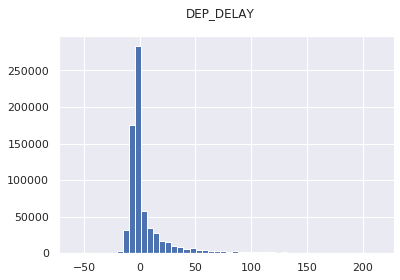

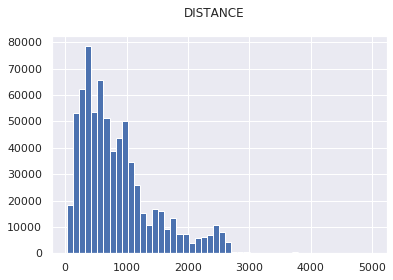

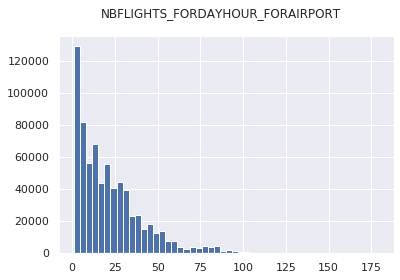

In [24]:
for feat_name in df_train_transformed.columns:
    if (feat_name in MODEL1_2FEATS_QUANTITATIVE):
        fig = plt.figure()
        fig.suptitle(feat_name)
        plt.hist(df_train_transformed[feat_name], bins=50)
        plt.plot()

## Linear regression

In [52]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()

lin_reg.fit(df_train_transformed, df_train[model1_label])

df_test_predictions = lin_reg.predict(df_test_transformed)

print("Evaluation on test set :")
evaluate_model(lin_reg, df_test_transformed, df_test[model1_label])

print('\n')

print("Evaluation on training set :")
evaluate_model(lin_reg, df_train_transformed, df_train[model1_label])

Evaluation on test set :
RMSE : 12.35018772843483


Evaluation on training set :
RMSE : 12.325423884404382


(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00,
        9.0000e+00, 4.3000e+01, 3.1400e+02, 2.5750e+03, 1.7524e+04,
        3.0648e+04, 9.2230e+03, 4.2630e+03, 2.8660e+03, 2.1890e+03,
        1.5690e+03, 1.2220e+03, 9.8700e+02, 8.0700e+02, 6.8100e+02,
        6.0400e+02, 4.8100e+02, 4.6000e+02, 3.9500e+02, 3.6100e+02,
        3.2700e+02, 2.5400e+02, 2.5600e+02, 2.1600e+02, 2.2200e+02,
        1.6200e+02, 1.6200e+02, 1.4800e+02, 1.4400e+02, 1.2100e+02,
        1.0500e+02, 1.0000e+02, 1.0300e+02, 9.1000e+01, 8.1000e+01,
        5.3000e+01, 6.4000e+01, 4.8000e+01, 3.4000e+01, 3.5000e+01,
        2.8000e+01, 1.7000e+01, 2.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([-61.55570566, -56.39928946, -51.24287326, -46.08645705,
        -40.93004085, -35.77362464, -30.61720844, -25.46079223,
        -20.30437603, -15.14795982,  -9.99154362,  -4.83512741,
          0.32128879,   5.47770499,  10.6341212 ,  15.7905374 ,
         20.94695361,  26.10336981,  31.25978602,  36.41620222

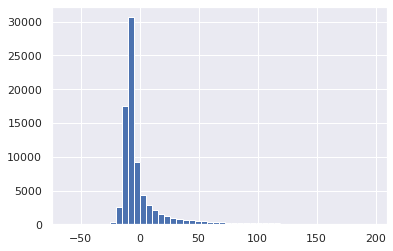

In [53]:
plt.hist(df_test_predictions, bins=50)

(array([ 1005.,  1684.,  3202.,  5362.,  7767.,  9677., 10065., 10843.,
         6424.,  4628.,  3355.,  2545.,  1916.,  1484.,  1493.,   998.,
          791.,   657.,   597.,   480.,   447.,   530.,   354.,   325.,
          302.,   247.,   236.,   231.,   261.,   186.,   174.,   158.,
          141.,   142.,   116.,   169.,   115.,   101.,    90.,    96.,
           67.,    89.,    82.,    61.,    63.,    58.,    48.,    43.,
           37.,    58.]),
 array([-35.  , -30.86, -26.72, -22.58, -18.44, -14.3 , -10.16,  -6.02,
         -1.88,   2.26,   6.4 ,  10.54,  14.68,  18.82,  22.96,  27.1 ,
         31.24,  35.38,  39.52,  43.66,  47.8 ,  51.94,  56.08,  60.22,
         64.36,  68.5 ,  72.64,  76.78,  80.92,  85.06,  89.2 ,  93.34,
         97.48, 101.62, 105.76, 109.9 , 114.04, 118.18, 122.32, 126.46,
        130.6 , 134.74, 138.88, 143.02, 147.16, 151.3 , 155.44, 159.58,
        163.72, 167.86, 172.  ]),
 <a list of 50 Patch objects>)

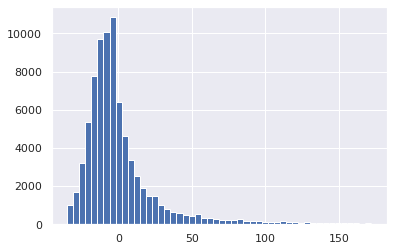

In [54]:
plt.hist(df_test[MODEL1_LABEL], bins=50)

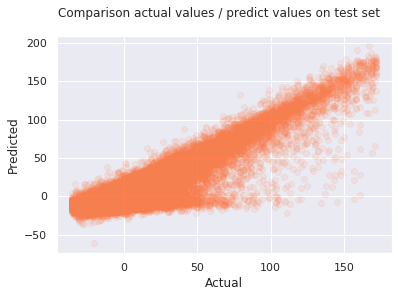

In [55]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison actual values / predict values on test set')
    plt.ylabel("Predicted")
    plt.xlabel("Actual")
    plt.scatter(df_test[model1_label], df_test_predictions, color='coral', alpha=0.1)

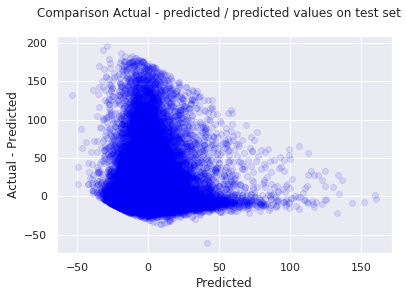

In [29]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison Actual - predicted / predicted values on test set')
    plt.xlabel("Predicted")
    plt.ylabel("Actual - Predicted")
    plt.scatter(df_test_predictions, df_test[model1_label] - df_test_predictions, color='blue', alpha=0.1)

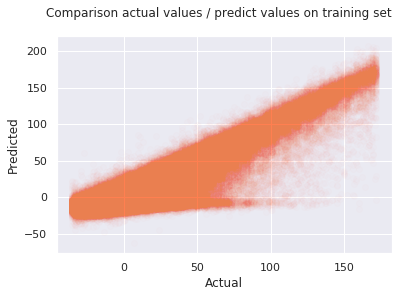

In [30]:
df_train_predictions = lin_reg.predict(df_train_transformed)

if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison actual values / predict values on training set')
    plt.ylabel("Predicted")
    plt.xlabel("Actual")
    plt.scatter(df_train[model1_label], df_train_predictions, color='coral', alpha=0.01)

In [31]:
lin_reg.coef_

array([ 0.9946638 , -0.00204304, -0.01062105])

In [32]:
coef_feature_importances = (abs(lin_reg.coef_) / (abs(lin_reg.coef_).sum()))

In [33]:
coef_feature_importances.sum()

0.9999999999999999

In [34]:
df_feature_importances = pd.DataFrame(data = {'Feature name' : df_train_transformed.columns, 'Feature importance' : coef_feature_importances})

In [35]:
pd.concat([df_feature_importances.sort_values(by='Feature importance', ascending=False), \
           df_feature_importances[['Feature importance']].sort_values(by='Feature importance', ascending=False).cumsum()], axis=1)

,Feature name,Feature importance,Feature importance
0,DEP_DELAY,0.987428,0.987428
2,NBFLIGHTS_FORDAYHOUR_FORAIRPORT,0.010544,0.997972
1,DISTANCE,0.002028,1.000000


## Random forest

In [36]:
%%time
from sklearn.ensemble import RandomForestRegressor

if (EXECUTE_INTERMEDIATE_MODELS == True):
    random_reg = RandomForestRegressor(n_estimators=200, max_depth=500, n_jobs=-1, random_state=42)
    random_reg.fit(df_train_transformed, df_train[model1_label])

CPU times: user 12min 41s, sys: 8.43 s, total: 12min 49s
Wall time: 1min 42s


In [37]:
print("Evaluation on test set :")
evaluate_model(random_reg, df_test_transformed, df_test[model1_label])

print('\n')

print("Evaluation on training set :")
evaluate_model(random_reg, df_train_transformed, df_train[model1_label])

Evaluation on test set :
RMSE : 13.545349283796279


Evaluation on training set :
RMSE : 7.877451850265639


In [38]:
df_test_predictions = random_reg.predict(df_test_transformed)

In [39]:
df_train_predictions = random_reg.predict(df_train_transformed)

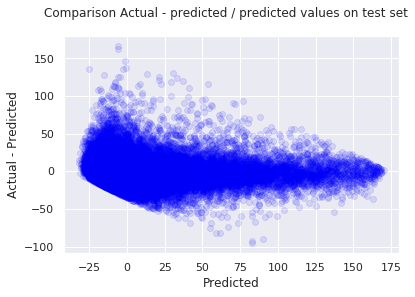

In [40]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison Actual - predicted / predicted values on test set')
    plt.xlabel("Predicted")
    plt.ylabel("Actual - Predicted")
    plt.scatter(df_test_predictions, df_test[model1_label] - df_test_predictions, color='blue', alpha=0.1)

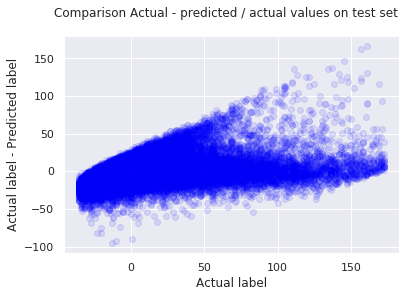

In [41]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison Actual - predicted / actual values on test set')
    plt.xlabel("Actual label")
    plt.ylabel("Actual label - Predicted label")
    plt.scatter(df_test[model1_label], df_test[model1_label] - df_test_predictions, color='blue', alpha=0.1)

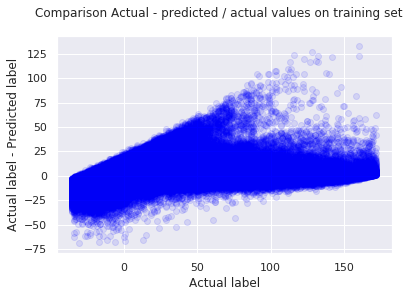

In [42]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison Actual - predicted / actual values on training set')
    plt.xlabel("Actual label")
    plt.ylabel("Actual label - Predicted label")
    plt.scatter(df_train[model1_label], df_train[model1_label] - df_train_predictions, color='blue', alpha=0.1)

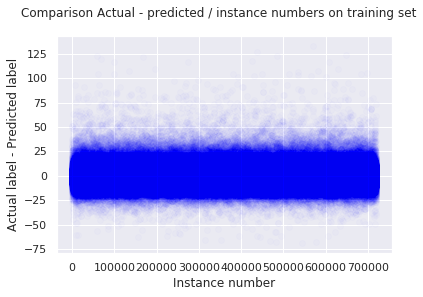

In [43]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison Actual - predicted / instance numbers on training set')
    plt.xlabel("Instance number")
    plt.ylabel("Actual label - Predicted label")
    plt.scatter(range(df_train.shape[0]), df_train[model1_label] - df_train_predictions, color='blue', alpha=0.01)

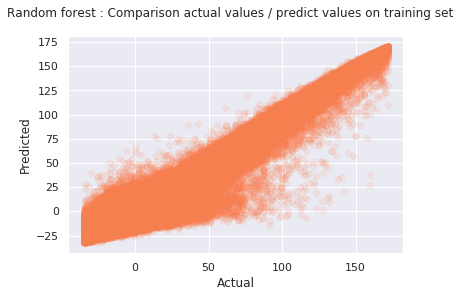

In [44]:
df_train_predictions = random_reg.predict(df_train_transformed)

if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Random forest : Comparison actual values / predict values on training set')
    plt.ylabel("Predicted")
    plt.xlabel("Actual")
    plt.scatter(df_train[model1_label], df_train_predictions, color='coral', alpha=0.1)

In [45]:
df_train_transformed.columns

Index(['DEP_DELAY', 'DISTANCE', 'NBFLIGHTS_FORDAYHOUR_FORAIRPORT'], dtype='object')

In [46]:
pd.set_option('display.max_rows', 200)

In [47]:
df_feature_importances = pd.DataFrame(data = {'Feature name' : df_train_transformed.columns, 'Feature importance' : random_reg.feature_importances_})

In [48]:
pd.concat([df_feature_importances.sort_values(by='Feature importance', ascending=False), \
           df_feature_importances[['Feature importance']].sort_values(by='Feature importance', ascending=False).cumsum()], axis=1)

,Feature name,Feature importance,Feature importance
0,DEP_DELAY,0.849804,0.849804
1,DISTANCE,0.084259,0.934063
2,NBFLIGHTS_FORDAYHOUR_FORAIRPORT,0.065937,1.000000


In [49]:
random_reg.feature_importances_

array([0.84980365, 0.08425901, 0.06593734])

In [50]:
random_reg.feature_importances_.cumsum()

array([0.84980365, 0.93406266, 1.        ])

Calculating learning curve for 15 iterations


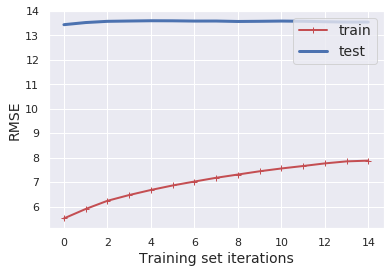

In [51]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    plot_learning_curves(random_reg, df_train_transformed, df_test_transformed, df_train[model1_label], df_test[model1_label], LEARNING_CURVE_STEP_SIZE)

# Annex : unused code

In [166]:
'''from sklearn import linear_model

regressor = linear_model.SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)
regressor.fit(df_transformed, df_train[model1_label])
'''

'from sklearn import linear_model\n\nregressor = linear_model.SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)\nregressor.fit(df_transformed, df_train[model1_label])\n'

In [167]:
'''
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(df_train_transformed, df_train[model1_label])
'''

'\nfrom sklearn.svm import SVR\n\nsvm_reg = SVR(kernel="linear")\nsvm_reg.fit(df_train_transformed, df_train[model1_label])\n'

In [168]:
'''
df_test_predictions = svm_reg.predict(df_test_transformed)
svm_mse = mean_squared_error(df_test[model1_label], df_test_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse
'''

'\ndf_test_predictions = svm_reg.predict(df_test_transformed)\nsvm_mse = mean_squared_error(df_test[model1_label], df_test_predictions)\nsvm_rmse = np.sqrt(svm_mse)\nsvm_rmse\n'

In [169]:
'''
from sklearn.model_selection import StratifiedShuffleSplit

stratified_split_train = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
'''

'\nfrom sklearn.model_selection import StratifiedShuffleSplit\n\nstratified_split_train = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)\n'

poly = PolynomialFeatures(degree=3)
poly.fit(df_train_transformed)
df_train_transformed = poly.transform(df_train_transformed)
df_test_transformed = poly.transform(df_test_transformed)

df_train_transformed.shape

if (EXECUTE_INTERMEDIATE_MODELS == True):
    lin_reg = LinearRegression()
    lin_reg.fit(df_train_transformed, df_train[model1_label])

if (EXECUTE_INTERMEDIATE_MODELS == True):
    evaluate_model(lin_reg, df_test_transformed, df_test[model1_label])

evaluate_model_MAE(lin_reg, df_test_transformed, df_test[model1_label])

# This code is now in a transformer function :
n_degrees = 3
n_features = df_train_transformed.shape[1]

nb_instances = df_train_transformed.shape[0]
df_poly = np.empty((nb_instances, 0)) # Create empty array of nb_instances line and 0 features yet (we'll concatenate polynomial features to it)

progbar = tqdm(range(n_features))
print('Adding polynomial features')

for feature_index in range(n_features):    
    df_1feature = df_train_transformed[:,feature_index]  # Reshape 
    
    for n_degree in range(n_degrees):
        df_poly = np.c_[df_poly, np.power(df_1feature, n_degree + 1)]
    
    progbar.update(1)
    
# Add bias (intercept)
df_poly = np.c_[df_poly, np.ones((len(df_poly), 1))]  # add x0 = 1 feature

X_train, X_test, income_train, income_test = tts( other_colums, income_column,
                         shuffle = True, stratify = Income_column)`

df.shape

df_labels_discrete = pd.cut(df['ARR_DELAY'], bins=50)

df_labels_discrete.head(50)

df[['ARR_DELAY']]

display_freq_table(df, ['ARR_DELAY'])

df['ARR_DELAY'].quantile([0,1])

df.ARR_DELAY.quantile(.01)

df[df['ARR_DELAY'] > df.ARR_DELAY.quantile(.99)]

df.loc[(df['ARR_DELAY'] < df.ARR_DELAY.quantile(.01)) | (df['ARR_DELAY'] > df.ARR_DELAY.quantile(.99)) , :]

((df['ARR_DELAY'] < df.ARR_DELAY.quantile(.01)) | (df['ARR_DELAY'] > df.ARR_DELAY.quantile(.99))).index

((df['ARR_DELAY'] < df.ARR_DELAY.quantile(.01)) | (df['ARR_DELAY'] > df.ARR_DELAY.quantile(.99)))

df.shape

df_labels_discrete.shape

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df, df[model1_label], test_size=0.1, random_state=42, shuffle = True, stratify = df_labels_discrete)

from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(df, test_size=0.1, random_state=42, shuffle = True, stratify = df_labels_discrete)

X_test

split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_index, test_index in split.split(df, df_labels_discrete):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

df_labels_discrete.value_counts()

df[['DEST']]

df_train, df_test = train_test_split(df, test_size=0.1, random_state=42)

poly = ColumnTransformer([
                                ('poly', PolynomialFeatures(degree=2), [0, 1, 2, 3, 4, 5, 6])     
                                ], remainder='passthrough', sparse_threshold=1)

poly.fit(df_train_transformed, df_train[model1_label])

'''
#Too slow

from sklearn.ensemble import RandomForestRegressor

if (EXECUTE_INTERMEDIATE_MODELS == True):
    random_reg = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=42)
    random_reg.fit(df_train_transformed, df_train[model1_label])
    
'''

'''
if (EXECUTE_INTERMEDIATE_MODELS == True):
    df_test_predictions = random_reg.predict(df_test_transformed)
    evaluate_model(random_reg, df_test_transformed, df_test[model1_label])
'''

# Add bias :
# Bias has been removed: its linear regression coeficient was 0
'''
df_train_transformed = np.c_[np.ones((len(df_train_transformed), 1)), df_train_transformed]  # add x0 = 1 to each instance
df_test_transformed = np.c_[np.ones((len(df_test_transformed), 1)), df_test_transformed]  # add x0 = 1 to each instance
'''

'''
# Commented out because memory error
polynomial_reg = Pipeline([('poly', PolynomialFeatures(degree=3)),
                          ('linear', LinearRegression(fit_intercept=False))])

polynomial_reg.fit(df_train_transformed, df_train[model1_label])
'''

for feat_indice in range(df_train_transformed.shape[1]):
    fig = plt.figure()
    plt.hist(df_train_transformed.iloc[:, feat_indice], bins=50)